In [1]:
# Enable auto reload for imports
%load_ext autoreload
%autoreload 2

import subprocess
import os
import sys
from pathlib import Path
import itertools
import time
import json
from datetime import datetime
import pandas as pd
from loguru import logger
import concurrent.futures

# Import the DOT to Verilog converter
from dot_to_verilog_converter import DotToVerilogConverter, convertAllMicrobenchGraphs

# Configure loguru logger - output only to stdout
logger.remove()  # Remove default handler
logger.add(sys.stdout, format="{time} | {level} | {message}", level="INFO")

logger.info("Imported required libraries for nextpnr parameter sweep and DOT conversion")
logger.info("Auto-reload enabled for module imports")

def analyze_nextpnr_logs(stdout: str, stderr: str) -> dict:
    """
    Analyze nextpnr logs to detect synthesis errors, placement success, routing success, and other failure types
    
    Parameters
    ----------
    stdout : str
        Standard output from nextpnr execution
    stderr : str
        Standard error from nextpnr execution
        
    Returns
    -------
    dict
        Dictionary containing analysis results:
        - placementSuccess: bool - Whether placement succeeded
        - routingSuccess: bool - Whether routing succeeded  
        - routingFailed: bool - Whether routing specifically failed
        - synthesisSuccess: bool - Whether synthesis succeeded
        - synthesisError: str - Synthesis error message if any
        - arcQueueSize: int or None - Arc queue size if available
        - failureType: str - Type of failure ('none', 'synthesis', 'placement', 'routing', 'timeout', 'exception')
    """
    
    # Combine stdout and stderr for analysis
    combinedLogs = stdout + "\n" + stderr
    
    # Initialize results
    result = {
        "placementSuccess": False,
        "routingSuccess": False,
        "routingFailed": False,
        "synthesisSuccess": False,
        "synthesisError": "none",
        "arcQueueSize": None,
        "failureType": "none"
    }
    
    # Check for synthesis errors first
    synthesisErrorPatterns = [
        "Error: Failed to parse JSON file",
        "Error: JSON parsing failed",
        "Error: Cannot read JSON",
        "Error: Invalid JSON format",
        "Error: Synthesis failed",
        "Error: Yosys synthesis error",
        "Error: Cannot load design",
        "Error: Design elaboration failed",
        "Error: Netlist parsing error",
        "json11: parse error",
        "ERROR: Failed to load JSON",
        "ERROR: Synthesis error"
    ]
    
    for pattern in synthesisErrorPatterns:
        if pattern.lower() in combinedLogs.lower():
            result["synthesisError"] = pattern
            result["failureType"] = "synthesis"
            return result  # Early return for synthesis errors
    
    # If no synthesis errors found, assume synthesis succeeded
    result["synthesisSuccess"] = True
    
    # Check for placement success
    placementSuccessPatterns = [
        "placement completed successfully",
        "Placement completed",
        "placement finished",
        "Info: Placement...",
        "Checksum: 0x"  # Often indicates successful placement
    ]
    
    for pattern in placementSuccessPatterns:
        if pattern.lower() in combinedLogs.lower():
            result["placementSuccess"] = True
            break
    
    # Check for placement failures
    placementFailurePatterns = [
        "ERROR: Unable to place cell",
        "ERROR: Placement failed",
        "Error: Cannot place",
        "Error: Placement error",
        "FATAL: Placement failed",
        "failed to place"
    ]
    
    for pattern in placementFailurePatterns:
        if pattern.lower() in combinedLogs.lower():
            result["placementSuccess"] = False
            result["failureType"] = "placement"
            return result
    
    # Check for routing success (only if placement succeeded)
    if result["placementSuccess"]:
        routingSuccessPatterns = [
            "routing completed successfully",
            "Routing completed",
            "routing finished",
            "Info: Routing graph solver",
            "routing complete"
        ]
        
        for pattern in routingSuccessPatterns:
            if pattern.lower() in combinedLogs.lower():
                result["routingSuccess"] = True
                break
        
        # Check for routing failures
        routingFailurePatterns = [
            "ERROR: Failed to route",
            "ERROR: Routing failed", 
            "Error: Cannot route",
            "Error: Routing error",
            "FATAL: Routing failed",
            "failed to route",
            "routing timeout",
            "router failed"
        ]
        
        for pattern in routingFailurePatterns:
            if pattern.lower() in combinedLogs.lower():
                result["routingFailed"] = True
                result["failureType"] = "routing"
                break
        
        # If placement succeeded but routing status is unclear, check for timeout
        if not result["routingSuccess"] and not result["routingFailed"]:
            # Look for timeout or incomplete routing indicators
            if "timeout" in combinedLogs.lower() or "interrupted" in combinedLogs.lower():
                result["routingFailed"] = True
                result["failureType"] = "routing"
            elif result["placementSuccess"]:
                # If placement succeeded but no clear routing indicators, assume routing failed
                result["routingFailed"] = True
                result["failureType"] = "routing"
    else:
        # If placement failed, routing also failed
        result["routingFailed"] = True
        result["failureType"] = "placement"
    
    # Extract arc queue size if available
    import re
    arcQueueMatch = re.search(r"arc queue size[:\s]+(\d+)", combinedLogs, re.IGNORECASE)
    if arcQueueMatch:
        result["arcQueueSize"] = int(arcQueueMatch.group(1))
    
    # Determine overall failure type
    if result["synthesisSuccess"] and result["placementSuccess"] and result["routingSuccess"]:
        result["failureType"] = "none"  # Success
    elif not result["synthesisSuccess"]:
        result["failureType"] = "synthesis"
    elif not result["placementSuccess"]:
        result["failureType"] = "placement"
    elif not result["routingSuccess"]:
        result["failureType"] = "routing"
    
    return result

def run_nextpnr_himbaechel(connectivityFactor: float, congestionFactor: float, sourceFileName: str = "default") -> dict:
    """
    Run nextpnr-himbaechel with specific parameters and analyze results
    
    Parameters:
    - connectivityFactor: Placement connectivity factor 
    - congestionFactor: Placement congestion factor
    - sourceFileName: Name of source file for logging
    
    Returns:
    - dict with results including success status, timing, and failure analysis
    """
    
    try:
        startTime = time.time()
        
        # Build the command - this should be defined elsewhere in the notebook
        cmd = f"nextpnr-himbaechel --chipdb {CHIPDB_PATH} --json {JSON_INPUT} --constrain-pairs {CONSTRAIN_PAIR} --fdc {FDC_PATH} --placer-heap-alpha {BETA_VALUE} --placer-heap-connectivity-factor {connectivityFactor} --placer-heap-congestion-factor {congestionFactor} --placer-heap-trials {PLACE_TRIALS} --router-heap-timeout {ROUTER_TIMEOUT}"
        
        # Log the command for debugging
        logger.info(f"Command: {cmd}")
        
        result = subprocess.run(
            cmd, 
            shell=True,
            capture_output=True,
            text=True,
            timeout=ROUTER_TIMEOUT,
            cwd=FAB_PROJ_DIR
        )
        
        endTime = time.time()
        
        # Analyze the logs for detailed failure information
        logAnalysis = analyze_nextpnr_logs(result.stdout, result.stderr)
        
        # Enhanced result with synthesis information
        if result.returncode == 0:
            return {
                "success": True,
                "runtime": endTime - startTime,
                "returnCode": result.returncode,
                "placementSuccess": logAnalysis["placementSuccess"],
                "routingSuccess": logAnalysis["routingSuccess"], 
                "routingFailed": logAnalysis["routingFailed"],
                "synthesisSuccess": logAnalysis["synthesisSuccess"],
                "synthesisError": logAnalysis["synthesisError"],
                "arcQueueSize": logAnalysis["arcQueueSize"],
                "failureType": logAnalysis["failureType"]
            }
        else:
            # If command failed, provide detailed failure information
            failureType = logAnalysis["failureType"] if logAnalysis["failureType"] != "none" else "unknown"
            return {
                "success": False,
                "runtime": endTime - startTime,
                "returnCode": result.returncode,
                "placementSuccess": logAnalysis["placementSuccess"],
                "routingSuccess": logAnalysis["routingSuccess"],
                "routingFailed": logAnalysis["routingFailed"],
                "synthesisSuccess": logAnalysis["synthesisSuccess"],
                "synthesisError": logAnalysis["synthesisError"],
                "arcQueueSize": logAnalysis["arcQueueSize"],
                "failureType": failureType
            }
            
    except subprocess.TimeoutExpired:
        endTime = time.time()
        logger.warning(f"Router timeout after {ROUTER_TIMEOUT}s for connectivity={connectivityFactor}, congestion={congestionFactor}")
        return {
            "success": False,
            "runtime": endTime - startTime,
            "returnCode": -1,
            "placementSuccess": False,
            "routingSuccess": False,
            "routingFailed": True,
            "synthesisSuccess": False,
            "synthesisError": "Router timeout",
            "arcQueueSize": None, 
            "failureType": "timeout"
        }
        
    except Exception as e:
        endTime = time.time()
        logger.error(f"Exception during parameter test: {e}")
        return {
            "success": False,
            "runtime": endTime - startTime,
            "returnCode": -2,
            "placementSuccess": False,
            "routingSuccess": False,
            "routingFailed": True,
            "synthesisSuccess": False,
            "synthesisError": f"Exception: {str(e)}",
            "arcQueueSize": None,
            "failureType": "exception"
        }

2025-06-20T18:08:58.536816+0100 | INFO | Imported required libraries for nextpnr parameter sweep and DOT conversion
2025-06-20T18:08:58.537205+0100 | INFO | Auto-reload enabled for module imports


In [2]:
# Batch conversion of all userbench dfg benchmark dot files to Verilog
logger.info("Starting batch conversion of userbench dfg benchmark dot files...")

# Initialize converter
converter = DotToVerilogConverter()

# Set up paths for the new userbench benchmark structure
dfgBenchmarkDir = Path("/home/kelvin/FABulous_fork/benchmarks/userbench/benchmark/dfg")
outputDir = Path("/home/kelvin/FABulous_fork/myProject/PnR/generated_verilog")
outputDir.mkdir(exist_ok=True)

logger.info(f"DFG benchmark directory: {dfgBenchmarkDir}")
logger.info(f"Output directory: {outputDir}")

# Dictionary to store batch conversion results per benchmark
batchResults = {}

try:
    if not dfgBenchmarkDir.exists():
        logger.error(f"Directory {dfgBenchmarkDir} does not exist!")
        raise FileNotFoundError(f"Directory {dfgBenchmarkDir} does not exist!")
    
    # Iterate through each benchmark directory
    benchmarkDirs = [d for d in dfgBenchmarkDir.iterdir() if d.is_dir()]
    logger.info(f"Found {len(benchmarkDirs)} benchmark directories")
    
    for benchmarkDir in sorted(benchmarkDirs):
        benchmarkName = benchmarkDir.name
        logger.info(f"Processing benchmark: {benchmarkName}")
        
        # Create output subdirectory for this benchmark
        benchmarkOutputDir = outputDir / benchmarkName
        benchmarkOutputDir.mkdir(exist_ok=True)
        
        # Find all Loop directories within this benchmark
        loopDirs = [d for d in benchmarkDir.iterdir() if d.is_dir() and d.name.startswith("Loop")]
        
        for loopDir in sorted(loopDirs):
            loopName = loopDir.name
            logger.info(f"  Processing {benchmarkName}/{loopName}")
            
            # Find .dot files in this loop directory
            dotFiles = list(loopDir.glob("*.dot"))
            
            for dotFile in dotFiles:
                dotFileName = dotFile.stem
                fullBenchmarkName = f"{benchmarkName}_{loopName}_{dotFileName}"
                
                logger.info(f"    Converting {dotFile.name}")
                
                try:
                    # Convert the dot file to Verilog - pass Path object, not string
                    verilogCode, g = converter.convertDotToVerilog(dotFile)
                    
                    if verilogCode:
                        # Save Verilog file maintaining relative structure
                        verilogOutputPath = benchmarkOutputDir / f"{loopName}_{dotFileName}.v"
                        
                        with open(verilogOutputPath, 'w') as f:
                            f.write(verilogCode)
                        
                        # Save the graph as well
                        graphOutputPath = benchmarkOutputDir / f"{loopName}_{dotFileName}_graph.dot"
                        
                        try:
                            import networkx as nx
                            nx.drawing.nx_pydot.write_dot(g, str(graphOutputPath))
                            logger.info(f"    ✓ {fullBenchmarkName} converted and saved successfully")
                        except Exception as e:
                            logger.warning(f"    ✓ Verilog saved but graph save failed for {fullBenchmarkName}: {e}")
                        
                        batchResults[fullBenchmarkName] = (verilogCode, g)
                    else:
                        logger.warning(f"    ✗ {fullBenchmarkName} conversion failed or returned empty code")
                        batchResults[fullBenchmarkName] = (None, None)
                        
                except Exception as e:
                    logger.error(f"    ✗ Failed to convert {dotFile}: {e}")
                    batchResults[fullBenchmarkName] = (None, None)
    
    # Count successful conversions
    successfulCount = sum(1 for result in batchResults.values() if result[0] is not None)
    totalCount = len(batchResults)
    
    logger.info("✓ Batch conversion completed!")
    logger.info(f"Successfully converted: {successfulCount}/{totalCount} files")
    
except Exception as e:
    logger.error(f"✗ Batch conversion failed: {e}")
    import traceback
    traceback.print_exc()

logger.info("DOT to Verilog batch conversion completed.")

2025-06-20T18:08:58.555636+0100 | INFO | Starting batch conversion of userbench dfg benchmark dot files...
2025-06-20T18:08:58.556359+0100 | INFO | DFG benchmark directory: /home/kelvin/FABulous_fork/benchmarks/userbench/benchmark/dfg
2025-06-20T18:08:58.556556+0100 | INFO | Output directory: /home/kelvin/FABulous_fork/myProject/PnR/generated_verilog
2025-06-20T18:08:58.557198+0100 | INFO | Found 18 benchmark directories
2025-06-20T18:08:58.557369+0100 | INFO | Processing benchmark: aes_aes
2025-06-20T18:08:58.557665+0100 | INFO |   Processing aes_aes/Loop0
2025-06-20T18:08:58.557944+0100 | INFO |     Converting aes_aes_dfg_0.dot
2025-06-20T18:08:58.558069+0100 | INFO | Converting /home/kelvin/FABulous_fork/benchmarks/userbench/benchmark/dfg/aes_aes/Loop0/aes_aes_dfg_0.dot to Verilog module 'aes_aes_dfg_0'
2025-06-20T18:08:58.675541+0100 | INFO | Found 12 nodes and 15 edges
2025-06-20T18:08:58.675950+0100 | INFO | Found 0 phi nodes to process
2025-06-20T18:08:58.676138+0100 | INFO | Fo

## 2. Define Parameter Ranges and Configuration

Set up parameter ranges for connectivity factor and congestion-aware factor, and define file paths based on the original script.

In [3]:
import numpy as np
import os
from pathlib import Path

# Define parameter ranges
CONNECTIVITY_FACTORS = np.arange(0.0, 2.0, 0.2)  # 0.0 to 2.0 with step 0.2
CONGESTION_FACTORS = np.arange(0.0, 2.0, 0.2)    # 0.0 to 2.0 with step 0.2
# grid = list(itertools.product(CONNECTIVITY_FACTORS, CONGESTION_FACTORS))
grid = [(0, 0), (0, 1), (1, 0), (1, 1)]

# Configuration constants from the original script
MY_FAB_ROOT = Path("/home/kelvin/FABulous_fork")
FAB_PROJ_DIR = Path("/home/kelvin/FABulous_fork/myProject")
os.environ["FAB_PROJ_DIR"] = str(FAB_PROJ_DIR)
os.environ["PATH"] = f"/home/kelvin/nextpnr/build/bba:{os.environ['PATH']}"
os.environ["PATH"] = f"/home/kelvin/nextpnr/build:{os.environ['PATH']}"
os.environ["PATH"] = f"/home/kelvin/yosys:{os.environ['PATH']}"

# Generated Verilog files directory - now contains benchmark subdirectories
GENERATED_VERILOG_DIR = Path("/home/kelvin/FABulous_fork/myProject/PnR/generated_verilog")

# Get list of available generated Verilog files organized by benchmark
availableVerilogFiles = []
benchmarkStructure = {}

if GENERATED_VERILOG_DIR.exists():
    # Scan through benchmark directories 
    for benchmarkDir in GENERATED_VERILOG_DIR.iterdir():
        if benchmarkDir.is_dir():
            benchmarkName = benchmarkDir.name
            benchmarkFiles = list(benchmarkDir.glob("*.v"))
            if benchmarkFiles:
                benchmarkStructure[benchmarkName] = sorted(benchmarkFiles)
                availableVerilogFiles.extend(benchmarkFiles)
    
    availableVerilogFiles.sort()  # Sort for consistent ordering

logger.info(f"Found {len(benchmarkStructure)} benchmark directories with Verilog files:")
for benchmarkName, files in benchmarkStructure.items():
    logger.info(f"  {benchmarkName}: {len(files)} files")

logger.info(f"Total available Verilog files: {len(availableVerilogFiles)}")

# Display some examples if files exist
if availableVerilogFiles:
    logger.info("Examples of available files:")
    for vFile in availableVerilogFiles[:5]:  # Show first 5
        logger.info(f"  - {vFile.relative_to(GENERATED_VERILOG_DIR)}")
        
    if len(availableVerilogFiles) > 5:
        logger.info(f"  ... and {len(availableVerilogFiles) - 5} more files")
else:
    logger.warning("No Verilog files found. Make sure to run the batch conversion first.")

# Fallback to original source if no generated files exist
FALLBACK_SOURCE_HDL = MY_FAB_ROOT / "benchmarks/userbench/loop_array_inner/loop_array_inner.sv"

# File paths (these remain the same)
CHIPDB_PATH = FAB_PROJ_DIR / ".FABulous/hycube.bit"
JSON_INPUT = FAB_PROJ_DIR / "user_design/synth_test.json"
CONSTRAIN_PAIR = FAB_PROJ_DIR / ".FABulous/hycube_constrain_pair.inc"
FDC_PATH = FAB_PROJ_DIR / "user_design/test.fdc"

# Output directory for results
OUTPUT_DIR = Path("/home/kelvin/FABulous_fork/myProject/PnR/parameter_sweep_results")
OUTPUT_DIR.mkdir(exist_ok=True)

# Fixed parameters
BETA_VALUE = 0.9
PLACE_TRIALS = 1
ROUTER_TIMEOUT = 20000

logger.info(f"Parameter ranges defined: {len(CONNECTIVITY_FACTORS)} connectivity × {len(CONGESTION_FACTORS)} congestion = {len(CONNECTIVITY_FACTORS) * len(CONGESTION_FACTORS)} total combinations")
logger.info(f"Found {len(availableVerilogFiles)} generated Verilog files")
if availableVerilogFiles:
    logger.info("Available Verilog files:")
    for vFile in availableVerilogFiles[:5]:  # Show first 5
        logger.info(f"  - {vFile.name}")
    if len(availableVerilogFiles) > 5:
        logger.info(f"  ... and {len(availableVerilogFiles) - 5} more")
else:
    logger.warning(f"No generated Verilog files found in {GENERATED_VERILOG_DIR}")
    logger.info(f"Will use fallback source: {FALLBACK_SOURCE_HDL}")
logger.info(f"Output directory: {OUTPUT_DIR}")

2025-06-20T18:09:03.837250+0100 | INFO | Found 18 benchmark directories with Verilog files:
2025-06-20T18:09:03.837541+0100 | INFO |   kmp_kmp: 4 files
2025-06-20T18:09:03.837725+0100 | INFO |   fft_transpose: 12 files
2025-06-20T18:09:03.837893+0100 | INFO |   gemm_blocked: 2 files
2025-06-20T18:09:03.838194+0100 | INFO |   viterbi_viterbi: 10 files
2025-06-20T18:09:03.838378+0100 | INFO |   spmv_crs: 2 files
2025-06-20T18:09:03.838623+0100 | INFO |   bfs_bulk: 4 files
2025-06-20T18:09:03.839561+0100 | INFO |   sort_radix: 12 files
2025-06-20T18:09:03.839784+0100 | INFO |   md_knn: 2 files
2025-06-20T18:09:03.840009+0100 | INFO |   spmv_ellpack: 2 files
2025-06-20T18:09:03.840132+0100 | INFO |   nw_nw: 18 files
2025-06-20T18:09:03.840242+0100 | INFO |   md_grid: 4 files
2025-06-20T18:09:03.840352+0100 | INFO |   sort_merge: 8 files
2025-06-20T18:09:03.840449+0100 | INFO |   fft_strided: 4 files
2025-06-20T18:09:03.840541+0100 | INFO |   gemm_ncubed: 2 files
2025-06-20T18:09:03.840785+

## 2.1. Select Verilog Files to Process (Optional)

You can optionally filter which generated Verilog files to process. By default, all available files will be processed.

In [ ]:
# MLIR File Processing Configuration
# Process all MLIR files from the mlir directory and extract inner loop functions

import re
from pathlib import Path
import subprocess

# MLIR Directory Configuration
MLIR_DIR = Path("mlir")
GENERATED_VERILOG_DIR = Path("/home/kelvin/FABulous_fork/myProject/PnR/generated_verilog")
GENERATED_VERILOG_DIR.mkdir(exist_ok=True)

# HLS Tool Configuration
HLSTOOL_CMD = "hlstool"
HLSTOOL_ARGS = [
    "--calyx-hw",
    "--output-level=core", 
    "--ir",
    "-allow-unregistered-dialects"
]

def extractTopLevelFunctions(mlirFile: Path) -> list:
    """Extract all top-level functions matching <mlir_src_name>_inner_loop_\\d pattern.

    Parameters
    ----------
    mlirFile : Path
        Path to the MLIR file.

    Returns
    -------
    list
        List of function names matching the pattern.
    """
    funcPattern = re.compile(r"func @([a-zA-Z0-9_]+_inner_loop_\d+)\b")
    
    try:
        with mlirFile.open("r") as file:
            content = file.read()
        matches = funcPattern.findall(content)
        logger.info(f"Found inner loop functions in {mlirFile.name}: {matches}")
        return matches
    except Exception as e:
        logger.error(f"Error reading MLIR file {mlirFile}: {e}")
        return []

def generateVerilogFromMlir(mlirFile: Path, topLevelFunc: str) -> Path:
    """Generate Verilog from MLIR file using hlstool.

    Parameters
    ----------
    mlirFile : Path
        Path to the MLIR file.
    topLevelFunc : str
        Name of the top-level function.

    Returns
    -------
    Path
        Path to the generated Verilog file, or None if failed.
    """
    # Generate output filename
    verilogFileName = f"{mlirFile.stem}_{topLevelFunc}.v"
    verilogPath = GENERATED_VERILOG_DIR / verilogFileName
    
    # Build hlstool command
    cmd = [
        HLSTOOL_CMD,
        *HLSTOOL_ARGS,
        f"--top-level-function={topLevelFunc}",
        str(mlirFile)
    ]
    
    logger.info(f"Generating Verilog: {mlirFile.name} -> {verilogFileName}")
    logger.info(f"Running: {' '.join(cmd)}")
    
    try:
        # Run hlstool and capture output
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)
        
        if result.returncode == 0:
            # Save the Verilog output
            with verilogPath.open("w") as f:
                f.write(result.stdout)
            
            logger.info(f"✓ Successfully generated: {verilogFileName}")
            return verilogPath
        else:
            logger.error(f"✗ hlstool failed for {mlirFile.name} function {topLevelFunc}")
            logger.error(f"Return code: {result.returncode}")
            logger.error(f"STDERR: {result.stderr}")
            return None
            
    except subprocess.TimeoutExpired:
        logger.error(f"✗ hlstool timeout for {mlirFile.name} function {topLevelFunc}")
        return None
    except Exception as e:
        logger.error(f"✗ Error running hlstool for {mlirFile.name}: {e}")
        return None

def processAllMlirFiles() -> list:
    """Process all MLIR files and generate corresponding Verilog files.

    Returns
    -------
    list
        List of successfully generated Verilog file paths.
    """
    if not MLIR_DIR.exists():
        logger.error(f"MLIR directory {MLIR_DIR} does not exist!")
        return []
    
    mlirFiles = list(MLIR_DIR.glob("*.mlir"))
    logger.info(f"Found {len(mlirFiles)} MLIR files in {MLIR_DIR}")
    
    generatedVerilogFiles = []
    
    for mlirFile in mlirFiles:
        logger.info(f"Processing MLIR file: {mlirFile.name}")
        
        # Extract all inner loop functions from this MLIR file
        topLevelFuncs = extractTopLevelFunctions(mlirFile)
        
        if not topLevelFuncs:
            logger.warning(f"No inner loop functions found in {mlirFile.name}")
            continue
        
        # Generate Verilog for each function
        for func in topLevelFuncs:
            verilogPath = generateVerilogFromMlir(mlirFile, func)
            if verilogPath and verilogPath.exists():
                generatedVerilogFiles.append(verilogPath)
    
    logger.info(f"Successfully generated {len(generatedVerilogFiles)} Verilog files from MLIR")
    return generatedVerilogFiles

# Process all MLIR files to generate Verilog files using enhanced pipeline
logger.info("Starting enhanced MLIR to Verilog conversion process...")

# Use the enhanced processing pipeline that handles the full benchmark workflow
availableVerilogFiles = processAllMlirFilesEnhanced()

# Organize files for processing
benchmarkStructure = {}
if availableVerilogFiles:
    # Group files by MLIR source for organization
    for vFile in availableVerilogFiles:
        # Extract the base MLIR name (before the function name)
        baseName = vFile.stem.split("_inner_loop_")[0] if "_inner_loop_" in vFile.stem else vFile.stem
        
        if baseName not in benchmarkStructure:
            benchmarkStructure[baseName] = []
        benchmarkStructure[baseName].append(vFile)
    
    # Sort for consistent ordering
    for baseName in benchmarkStructure:
        benchmarkStructure[baseName].sort()

logger.info(f"Generated Verilog files organized into {len(benchmarkStructure)} groups:")
for groupName, files in benchmarkStructure.items():
    logger.info(f"  {groupName}: {len(files)} files")
    for vFile in files:
        logger.info(f"    - {vFile.name}")

logger.info(f"Total available Verilog files: {len(availableVerilogFiles)}")

if not availableVerilogFiles:
    logger.warning("No Verilog files were generated from MLIR! Check MLIR files and hlstool availability.")
    # Fallback to original source if no generated files exist
    FALLBACK_SOURCE_HDL = MY_FAB_ROOT / "benchmarks/userbench/loop_array_inner/loop_array_inner.sv"
    logger.info(f"Will use fallback source: {FALLBACK_SOURCE_HDL}")
else:
    logger.info("✓ Enhanced MLIR to Verilog conversion completed successfully")
    logger.info("Ready to proceed with parameter sweep using generated Verilog files")
    logger.info("Pipeline includes: benchmark compilation, MLIR optimization, loop extraction, and Verilog generation")

2025-06-20T18:09:03.863616+0100 | INFO | Will process all 108 available Verilog files


In [ ]:
# Comprehensive MLIR Processing Pipeline
# Implements the full benchmark processing logic from the original Makefile

def applyMlirOptimizations(mlirFile: Path) -> bool:
    """Apply comprehensive MLIR optimizations to a file.

    Parameters
    ----------
    mlirFile : Path
        Path to the MLIR file to optimize.

    Returns
    -------
    bool
        True if successful, False otherwise.
    """
    
    # Comprehensive optimization pipeline from the original Makefile
    optimizationCmd = [
        "mlir-opt",
        "--allow-unregistered-dialect",
        "--int-range-optimizations",
        "--sroa",
        "--normalize-memrefs", 
        "--flatten-memref",
        "--enable-loop-simplifycfg-term-folding",
        "--affine-loop-fusion",
        "--affine-simplify-structures",
        "--affine-loop-invariant-code-motion",
        "--affine-scalrep",
        "--affine-pipeline-data-transfer",
        "-mlir-print-op-generic",
        "-o", str(mlirFile),
        str(mlirFile)
    ]
    
    logger.info(f"Applying MLIR optimizations to {mlirFile.name}")
    logger.info("Optimizations: int-range, sroa, memref normalization, affine passes")
    
    try:
        result = subprocess.run(optimizationCmd, capture_output=True, text=True, timeout=300)
        if result.returncode != 0:
            logger.error(f"MLIR optimization failed for {mlirFile.name}")
            logger.error(f"STDERR: {result.stderr}")
            return False
        
        logger.info(f"✓ MLIR optimizations completed for {mlirFile.name}")
        return True
        
    except subprocess.TimeoutExpired:
        logger.error(f"MLIR optimization timeout for {mlirFile.name}")
        return False
    except Exception as e:
        logger.error(f"Error during MLIR optimization: {e}")
        return False

def convertInnerLoopsToFunctions(mlirFile: Path) -> bool:
    """Convert inner loops to functions using Python script.

    Parameters
    ----------
    mlirFile : Path
        Path to the MLIR file to process.

    Returns
    -------
    bool
        True if successful, False otherwise.
    """
    
    logger.info(f"Converting inner loops to functions in {mlirFile.name}")
    
    # Check if the inner_loop_to_func.py script exists
    scriptPath = Path("inner_loop_to_func.py")
    if not scriptPath.exists():
        logger.warning(f"inner_loop_to_func.py not found, skipping loop-to-function conversion")
        return True  # Continue processing even if script is missing
    
    try:
        cmd = ["python3", str(scriptPath), str(mlirFile), str(mlirFile)]
        result = subprocess.run(cmd, capture_output=True, text=True, timeout=300)
        
        if result.returncode != 0:
            logger.error(f"Inner loop conversion failed for {mlirFile.name}")
            logger.error(f"STDERR: {result.stderr}")
            return False
        
        # Run mlir-opt to finalize the conversion
        finalizeCmd = ["mlir-opt", "-o", str(mlirFile), str(mlirFile)]
        finalizeResult = subprocess.run(finalizeCmd, capture_output=True, text=True, timeout=60)
        
        if finalizeResult.returncode != 0:
            logger.error(f"MLIR finalization failed for {mlirFile.name}")
            logger.error(f"STDERR: {finalizeResult.stderr}")
            return False
        
        logger.info(f"✓ Inner loop conversion completed for {mlirFile.name}")
        return True
        
    except subprocess.TimeoutExpired:
        logger.error(f"Inner loop conversion timeout for {mlirFile.name}")
        return False
    except Exception as e:
        logger.error(f"Error during inner loop conversion: {e}")
        return False

def processBenchmarkMlir(benchmarkPath: Path, outputDir: Path) -> list:
    """Process a benchmark following the original Makefile logic.

    Parameters
    ----------
    benchmarkPath : Path
        Path to the benchmark directory containing .c and .h files.
    outputDir : Path
        Directory to store the generated MLIR files.

    Returns
    -------
    list
        List of successfully processed MLIR files.
    """
    
    benchmarkName = benchmarkPath.name
    logger.info(f"Processing benchmark: {benchmarkName}")
    
    # Find .c files in the benchmark directory  
    cFiles = list(benchmarkPath.glob("*.c"))
    if not cFiles:
        logger.warning(f"No .c files found in {benchmarkPath}")
        return []
    
    processedMlirFiles = []
    
    for cFile in cFiles:
        # Generate function name following the original logic
        funcName = str(benchmarkPath).replace("/", "_")
        mlirFileName = f"{funcName}.mlir"
        mlirOutputPath = outputDir / mlirFileName
        
        logger.info(f"Generating MLIR for {benchmarkName} -> {mlirFileName}")
        
        # Find corresponding header file
        hFile = cFile.with_suffix(".h")
        if not hFile.exists():
            logger.warning(f"Header file not found for {cFile}, trying to continue...")
        
        # Build compilation command following the original Makefile
        compileCmd = [
            os.environ.get("CC", "clang"),  # Use CC environment variable if set
            "-O3",
            "-raise-scf-to-affine", 
            "-S",
            f"--function={funcName}",
            "-I./common",
            "-o", str(mlirOutputPath),
            str(cFile)
        ]
        
        # Add header file if it exists
        if hFile.exists():
            compileCmd.append(str(hFile))
        
        try:
            logger.info(f"Running: {' '.join(compileCmd)}")
            result = subprocess.run(compileCmd, capture_output=True, text=True, timeout=300)
            
            if result.returncode != 0:
                logger.error(f"MLIR generation failed for {benchmarkName}")
                logger.error(f"STDERR: {result.stderr}")
                continue
            
            # Remove attributes following the original sed command
            if mlirOutputPath.exists():
                with mlirOutputPath.open("r") as f:
                    content = f.read()
                
                # Remove attributes {[^}]*} pattern
                cleanedContent = re.sub(r'attributes\s*\{[^}]*\}', '', content)
                
                with mlirOutputPath.open("w") as f:
                    f.write(cleanedContent)
                
                logger.info(f"✓ Removed attributes from {mlirFileName}")
            
            # Apply optimizations
            if not applyMlirOptimizations(mlirOutputPath):
                logger.error(f"Optimization failed for {mlirFileName}")
                continue
            
            # Convert inner loops to functions
            if not convertInnerLoopsToFunctions(mlirOutputPath):
                logger.error(f"Inner loop conversion failed for {mlirFileName}")
                continue
            
            processedMlirFiles.append(mlirOutputPath)
            logger.info(f"✓ Successfully processed {mlirFileName}")
            
        except subprocess.TimeoutExpired:
            logger.error(f"Compilation timeout for {benchmarkName}")
            continue
        except Exception as e:
            logger.error(f"Error processing {benchmarkName}: {e}")
            continue
    
    return processedMlirFiles

def processAllBenchmarks() -> list:
    """Process all benchmarks to generate MLIR files following the original Makefile logic.

    Returns
    -------
    list
        List of all successfully processed MLIR files.
    """
    # This would be the benchmark directories - customize based on your setup
    benchmarkRootDir = Path("benchmarks")  # Adjust path as needed
    if not benchmarkRootDir.exists():
        logger.warning(f"Benchmark directory {benchmarkRootDir} not found")
        logger.info("Assuming MLIR files are already available in the mlir directory")
        return list(MLIR_DIR.glob("*.mlir")) if MLIR_DIR.exists() else []
    
    # Create output directory for generated MLIR files
    MLIR_DIR.mkdir(exist_ok=True)
    
    allProcessedMlir = []
    
    # Find all benchmark directories
    benchmarkDirs = [d for d in benchmarkRootDir.iterdir() if d.is_dir()]
    logger.info(f"Found {len(benchmarkDirs)} benchmark directories")
    
    for benchmarkDir in benchmarkDirs:
        processedFiles = processBenchmarkMlir(benchmarkDir, MLIR_DIR)
        allProcessedMlir.extend(processedFiles)
    
    logger.info(f"Total processed MLIR files: {len(allProcessedMlir)}")
    return allProcessedMlir

# Enhanced MLIR processing function that incorporates the complete pipeline
def processAllMlirFilesEnhanced() -> list:
    """Enhanced MLIR processing that generates MLIR files from source if needed.

    Returns
    -------
    list
        List of successfully generated Verilog file paths.
    """
    
    logger.info("Starting enhanced MLIR processing pipeline...")
    
    # Step 1: Generate MLIR files from benchmarks if needed
    if not MLIR_DIR.exists() or len(list(MLIR_DIR.glob("*.mlir"))) == 0:
        logger.info("No MLIR files found, attempting to generate from benchmarks...")
        processedMlirFiles = processAllBenchmarks()
    else:
        logger.info(f"Using existing MLIR files from {MLIR_DIR}")
        processedMlirFiles = list(MLIR_DIR.glob("*.mlir"))
    
    if not processedMlirFiles:
        logger.error("No MLIR files available for processing!")
        return []
    
    logger.info(f"Processing {len(processedMlirFiles)} MLIR files for Verilog generation...")
    
    # Step 2: Generate Verilog from MLIR files
    generatedVerilogFiles = []
    
    for mlirFile in processedMlirFiles:
        logger.info(f"Processing MLIR file: {mlirFile.name}")
        
        # Extract all inner loop functions from this MLIR file
        topLevelFuncs = extractTopLevelFunctions(mlirFile)
        
        if not topLevelFuncs:
            logger.warning(f"No inner loop functions found in {mlirFile.name}")
            continue
        
        # Generate Verilog for each function
        for func in topLevelFuncs:
            verilogPath = generateVerilogFromMlir(mlirFile, func)
            if verilogPath and verilogPath.exists():
                generatedVerilogFiles.append(verilogPath)
    
    logger.info(f"Enhanced MLIR processing completed: {len(generatedVerilogFiles)} Verilog files generated")
    return generatedVerilogFiles

logger.info("Enhanced MLIR processing pipeline functions defined")
logger.info("Supports: benchmark compilation, optimization, inner loop extraction, and Verilog generation")

## 3. Build nextpnr-himbaechel Command Function

Define functions to run FABulous preprocessing and nextpnr-himbaechel with given parameter values.

In [ ]:
def run_fabulous_preprocessing(sourceHdlPath: Path) -> bool:
    """
    Run FABulous preprocessing commands to generate necessary files for a specific source HDL.
    Updated to work with generated Verilog files from MLIR processing.
    
    Parameters
    ----------
    sourceHdlPath : Path
        Path to the source HDL file to use for synthesis
    
    Returns
    -------
    bool
        True if successful, False otherwise
    """
    
    # Ensure the source file exists
    if not sourceHdlPath.exists():
        logger.error(f"Source HDL file does not exist: {sourceHdlPath}")
        return False
        
    # Run FABulous command with the specified source HDL
    fabulous_cmd = [
        "FABulous", "--debug", str(FAB_PROJ_DIR), "-p",
        "load_fabric; gen_bitStream_spec; gen_cells_and_techmaps; "
        f"gen_chipdb -routing_graph {FAB_PROJ_DIR}/.FABulous/routing_graph.dot -filter 5,1 5,2 5,3 5,4; "
        f"synthesis_script {sourceHdlPath} -tcl {FAB_PROJ_DIR}/.FABulous/arch_synth.tcl;"
    ]
    
    logger.info(f"Running FABulous preprocessing for: {sourceHdlPath.name}")
    logger.info(f"Command: {' '.join(fabulous_cmd)}")
    
    # Set environment for subprocess - generate JSON with proper naming
    env = os.environ.copy()
    synthJsonPath = GENERATED_VERILOG_DIR / f"{sourceHdlPath.stem}_synth.json"
    env["OUT_JSON_PATH"] = str(synthJsonPath)
    
    try:
        result = subprocess.run(fabulous_cmd, capture_output=True, text=True, timeout=300, env=env)
        if result.returncode != 0:
            logger.error(f"FABulous preprocessing failed with return code: {result.returncode}")
            logger.error(f"STDOUT: {result.stdout}")
            logger.error(f"STDERR: {result.stderr}")
            return False
        
        # Verify that the JSON file was created
        if not synthJsonPath.exists():
            logger.error(f"Expected synthesis JSON file was not created: {synthJsonPath}")
            return False
        
        logger.info(f"FABulous preprocessing completed successfully")
        logger.info(f"Generated synthesis JSON: {synthJsonPath}")
        return True
        
    except subprocess.TimeoutExpired:
        logger.error(f"FABulous preprocessing timed out for {sourceHdlPath.name}")
        return False
    except Exception as e:
        logger.error(f"Exception during FABulous preprocessing: {e}")
        return False


def analyze_nextpnr_logs(stdout: str, stderr: str) -> dict:
    """
    Analyze nextpnr output logs to determine failure types and extract statistics.
    Enhanced to detect synthesis failures from generated Verilog files.
    
    Parameters
    ----------
    stdout : str
        Standard output from nextpnr run
    stderr : str
        Standard error from nextpnr run
    
    Returns
    -------
    dict
        Dictionary containing analysis results:
        - synthesisSuccess: bool - Whether synthesis completed successfully
        - synthesisError: str - Synthesis error message if any
        - placementSuccess: bool - Whether placement completed successfully
        - routingSuccess: bool - Whether routing completed successfully  
        - routingFailed: bool - Whether routing explicitly failed
        - arcQueueSize: int or None - Final arc queue size if found
        - failureType: str - "none", "synthesis", "placement", "routing", or "unknown"
    """
    combinedOutput = stdout + "\n" + stderr
    
    # Initialize results
    result = {
        "synthesisSuccess": False,
        "synthesisError": "none",
        "placementSuccess": False,
        "routingSuccess": False,
        "routingFailed": False,
        "arcQueueSize": None,
        "failureType": "none"
    }
    
    # Check for synthesis errors first (these prevent everything else)
    synthesisErrorPatterns = [
        "Error: Failed to parse JSON file",
        "Error: JSON parsing failed", 
        "Error: Cannot read JSON",
        "Error: Invalid JSON format",
        "Error: Synthesis failed",
        "Error: Yosys synthesis error",
        "Error: Cannot load design",
        "Error: Design elaboration failed",
        "Error: Netlist parsing error",
        "json11: parse error",
        "ERROR: Failed to load JSON",
        "ERROR: Synthesis error",
        "Error: Module not found",
        "Error: Unresolved reference"
    ]
    
    for pattern in synthesisErrorPatterns:
        if pattern.lower() in combinedOutput.lower():
            result["synthesisError"] = pattern
            result["failureType"] = "synthesis"
            return result  # Early return for synthesis errors
    
    # If no synthesis errors found, assume synthesis succeeded
    result["synthesisSuccess"] = True
    
    # Check for placement success - look for "Final Placement" line
    placementSuccess = "Final Placement" in combinedOutput
    result["placementSuccess"] = placementSuccess
    
    # Check for placement failures
    placementFailurePatterns = [
        "ERROR: Unable to place cell",
        "ERROR: Placement failed",
        "Error: Cannot place",
        "Error: Placement error",
        "FATAL: Placement failed",
        "failed to place"
    ]
    
    for pattern in placementFailurePatterns:
        if pattern.lower() in combinedOutput.lower():
            result["placementSuccess"] = False
            result["failureType"] = "placement"
            return result
    
    # Check for routing failure - look for "ERROR: Max iteration count reached"
    routingFailed = "ERROR: Max iteration count reached" in combinedOutput
    result["routingFailed"] = routingFailed
    
    # Extract arc_queue size - look for lines containing "current arc_queue size"
    arcQueueMatches = re.findall(r"current arc_queue size[:\s]*(\d+)", combinedOutput, re.IGNORECASE)
    if arcQueueMatches:
        # Take the last (most recent) arc_queue size found
        result["arcQueueSize"] = int(arcQueueMatches[-1])
    
    # Determine routing success
    # Routing is successful if placement succeeded and routing didn't explicitly fail
    routingSuccess = placementSuccess and not routingFailed
    result["routingSuccess"] = routingSuccess
    
    # Determine failure type
    if result["synthesisSuccess"] and placementSuccess and routingSuccess:
        result["failureType"] = "none"
    elif not result["synthesisSuccess"]:
        result["failureType"] = "synthesis"
    elif not placementSuccess:
        result["failureType"] = "placement"  
    elif placementSuccess and routingFailed:
        result["failureType"] = "routing"
    else:
        result["failureType"] = "unknown"
    
    return result
        
    
def run_nextpnr_himbaechel(connectivityFactor: float, congestionFactor: float, sourceFileName: str = "default") -> dict:
    """
    Run nextpnr-himbaechel with specified parameters.
    Updated to work with generated Verilog files from MLIR processing.
    
    Parameters
    ----------
    connectivityFactor : float
        Placer heap architecture connectivity factor
    congestionFactor : float
        Placer heap congestion aware factor
    sourceFileName : str
        Name of the source file (used for output naming)
    
    Returns
    -------
    dict
        Dictionary containing run results and metadata including synthesis/placement/routing failure analysis
    """
    # Generate unique output filenames with source file name
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    conn_str = f"{connectivityFactor:.1f}".replace(".", "p")
    cong_str = f"{congestionFactor:.1f}".replace(".", "p")
    
    # Clean source file name for filename
    cleanSourceName = Path(sourceFileName).stem.replace(".", "_")
    
    output_json = OUTPUT_DIR / f"{cleanSourceName}_conn{conn_str}_cong{cong_str}.json"
    output_fasm = OUTPUT_DIR / f"{cleanSourceName}_conn{conn_str}_cong{cong_str}.fasm"
    
    # Build nextpnr command - use the synthesis JSON generated from the Verilog file
    synthJsonPath = GENERATED_VERILOG_DIR / f"{Path(sourceFileName).stem}_synth.json"
    
    nextpnr_cmd = [
        "nextpnr-himbaechel",
        "--chipdb", str(CHIPDB_PATH),
        "--device", "FABulous",
        "--json", str(synthJsonPath),
        "--write", str(output_json),
        "-o", f"constrain-pair={CONSTRAIN_PAIR}",
        # "-o", f"fasm={output_fasm}",
        "-o", f"fdc={FDC_PATH}",
        "--placer-heap-seed-placement-strategy", "graph_grid",
        "--placer-heap-beta", str(BETA_VALUE),
        "--placer-heap-arch-connectivity-factor", str(connectivityFactor),
        "--placer-heap-congestion-aware-factor", str(congestionFactor),
        "-o", f"placeTrial={PLACE_TRIALS}",
        "--router1-timeout", str(ROUTER_TIMEOUT)
    ]
    
    start_time = time.time()
    
    try:
        logger.info(f"Running nextpnr for {cleanSourceName}: connectivity={connectivityFactor:.1f}, congestion={congestionFactor:.1f}")
        
        # Set environment for subprocess
        env = os.environ.copy()
        result = subprocess.run(nextpnr_cmd, capture_output=True, text=True, timeout=600, env=env)
        end_time = time.time()
        runtime = end_time - start_time
        
        success = result.returncode == 0
        
        # Analyze logs for detailed failure information including synthesis
        logAnalysis = analyze_nextpnr_logs(result.stdout, result.stderr)
        
        return {
            "sourceFileName": sourceFileName,
            "connectivityFactor": connectivityFactor,
            "congestionFactor": congestionFactor,
            "success": success,
            "runtime": runtime,
            "returnCode": result.returncode,
            "stdout": result.stdout,
            "stderr": result.stderr,
            "outputJson": str(output_json) if success else None,
            "outputFasm": str(output_fasm) if success else None,
            "timestamp": timestamp,
            # Add detailed failure analysis including synthesis
            "synthesisSuccess": logAnalysis["synthesisSuccess"],
            "synthesisError": logAnalysis["synthesisError"],
            "placementSuccess": logAnalysis["placementSuccess"],
            "routingSuccess": logAnalysis["routingSuccess"], 
            "routingFailed": logAnalysis["routingFailed"],
            "arcQueueSize": logAnalysis["arcQueueSize"],
            "failureType": logAnalysis["failureType"]
        }
        
    except subprocess.TimeoutExpired:
        end_time = time.time()
        runtime = end_time - start_time
        logger.warning(f"nextpnr timed out for {cleanSourceName}: connectivity={connectivityFactor:.1f}, congestion={congestionFactor:.1f}")
        
        return {
            "sourceFileName": sourceFileName,
            "connectivityFactor": connectivityFactor,
            "congestionFactor": congestionFactor,
            "success": False,
            "runtime": runtime,
            "returnCode": -1,
            "stdout": "",
            "stderr": "Timeout",
            "outputJson": None,
            "outputFasm": None,
            "timestamp": timestamp,
            # Add failure analysis fields for timeout case
            "synthesisSuccess": False,
            "synthesisError": "Timeout",
            "placementSuccess": False,
            "routingSuccess": False,
            "routingFailed": False,
            "arcQueueSize": None,
            "failureType": "timeout"
        }
    except Exception as e:
        end_time = time.time()
        runtime = end_time - start_time
        logger.error(f"Error running nextpnr for {cleanSourceName}: {e}")
        
        return {
            "sourceFileName": sourceFileName,
            "connectivityFactor": connectivityFactor,
            "congestionFactor": congestionFactor,
            "success": False,
            "runtime": runtime,
            "returnCode": -2,
            "stdout": "",
            "stderr": str(e),
            "outputJson": None,
            "outputFasm": None,
            "timestamp": timestamp,
            # Add failure analysis fields for exception case
            "synthesisSuccess": False,
            "synthesisError": f"Exception: {str(e)}",
            "placementSuccess": False,
            "routingSuccess": False,
            "routingFailed": False,
            "arcQueueSize": None,
            "failureType": "exception"
        }


def run_parameter_sweep_for_source(sourceHdlPath: Path) -> list[dict]:
    """
    Run parameter sweep for a specific source HDL file.
    Updated to work with generated Verilog files from MLIR processing.
    
    Parameters
    ----------
    sourceHdlPath : Path
        Path to the source HDL file (generated from MLIR)
        
    Returns
    -------
    list[dict]
        List of results for all parameter combinations
    """
    logger.info(f"Starting parameter sweep for: {sourceHdlPath.name}")
    
    # Run preprocessing for this source file
    if not run_fabulous_preprocessing(sourceHdlPath):
        logger.error(f"Preprocessing failed for {sourceHdlPath.name}. Skipping parameter sweep.")
        return []
    
    # Run parameter combinations
    results = []
    totalCombinations = len(grid)
    
    logger.info(f"Running {totalCombinations} parameter combinations for {sourceHdlPath.name}")
    
    def run_and_log(args: tuple) -> dict:
        connectivityFactor, congestionFactor = args
        result = run_nextpnr_himbaechel(connectivityFactor, congestionFactor, sourceHdlPath.name)
        if result["success"]:
            logger.info(f"✓ {sourceHdlPath.name}: conn={connectivityFactor:.1f}, cong={congestionFactor:.1f} completed in {result['runtime']:.2f}s")
        else:
            failureInfo = ""
            if 'failureType' in result:
                failureInfo = f" ({result['failureType']})"
                if result['failureType'] == 'synthesis' and result.get('synthesisError') != 'none':
                    failureInfo += f" - {result['synthesisError']}"
                elif result.get('arcQueueSize') is not None:
                    failureInfo += f" [arc_queue: {result['arcQueueSize']}]"
            logger.warning(f"✗ {sourceHdlPath.name}: conn={connectivityFactor:.1f}, cong={congestionFactor:.1f} failed with code {result['returnCode']}{failureInfo}")
        return result

    # Use reduced concurrency to avoid overwhelming the system
    maxWorkers = min(4, os.cpu_count() or 2)  # Further reduced for stability with MLIR processing
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=maxWorkers) as executor:
        futures = [executor.submit(run_and_log, args) for args in grid]
        for future in concurrent.futures.as_completed(futures):
            results.append(future.result())
    
    successCount = sum(1 for r in results if r['success'])
    synthesisSuccessCount = sum(1 for r in results if r.get('synthesisSuccess', False))
    
    logger.info(f"Parameter sweep completed for {sourceHdlPath.name}:")  
    logger.info(f"  Synthesis: {synthesisSuccessCount}/{len(results)} successful")
    logger.info(f"  Overall: {successCount}/{len(results)} successful")
    
    return results


logger.info("Updated helper functions defined successfully with MLIR-based preprocessing")
logger.info("New features: MLIR->Verilog generation, enhanced synthesis failure detection")

2025-06-20T18:09:03.880669+0100 | INFO | Updated helper functions defined successfully with enhanced failure detection
2025-06-20T18:09:03.881039+0100 | INFO | New features: placement/routing failure distinction, arc_queue size tracking


In [6]:
# Benchmark Selection Configuration
# Leave empty to process all benchmarks, or specify a list of benchmark names to process only those

# Examples:
# selectedBenchmarks = []  # Process all benchmarks (default)
# selectedBenchmarks = ["aes_aes", "bfs_bulk"]  # Process only these benchmarks
# selectedBenchmarks = [name for name in benchmarkStructure.keys() if "fft" in name]  # Filter by name pattern

selectedBenchmarks = []  # Default: process all benchmarks

# Apply benchmark selection filter
if selectedBenchmarks:
    logger.info(f"Filtering to {len(selectedBenchmarks)} selected benchmarks:")
    filteredBenchmarkStructure = {}
    filteredVerilogFiles = []
    
    for benchmarkName in selectedBenchmarks:
        if benchmarkName in benchmarkStructure:
            filteredBenchmarkStructure[benchmarkName] = benchmarkStructure[benchmarkName]
            filteredVerilogFiles.extend(benchmarkStructure[benchmarkName])
            logger.info(f"  - {benchmarkName}: {len(benchmarkStructure[benchmarkName])} files")
        else:
            logger.warning(f"  - {benchmarkName}: NOT FOUND")
    
    # Update the structures to use
    benchmarkStructure = filteredBenchmarkStructure  
    availableVerilogFiles = filteredVerilogFiles
    
    if not filteredVerilogFiles:
        logger.warning("No files matched the selection criteria!")
else:
    logger.info(f"Will process all {len(benchmarkStructure)} benchmarks with {len(availableVerilogFiles)} total files")

# Final check
if not availableVerilogFiles:
    logger.warning("No Verilog files available for processing!")
    if GENERATED_VERILOG_DIR.exists():
        logger.info(f"Contents of {GENERATED_VERILOG_DIR}:")
        for item in GENERATED_VERILOG_DIR.iterdir():
            logger.info(f"  - {item.name}")
    else:
        logger.error(f"Directory {GENERATED_VERILOG_DIR} does not exist!")
        
logger.info(f"Final selection: {len(benchmarkStructure)} benchmarks, {len(availableVerilogFiles)} files to process")

2025-06-20T18:09:03.891098+0100 | INFO | Will process all 18 benchmarks with 108 total files
2025-06-20T18:09:03.891476+0100 | INFO | Final selection: 18 benchmarks, 108 files to process


In [7]:
# Run parameter sweep organized by benchmark
# Each benchmark will be processed separately for better organization and analysis
allResults = []
benchmarkResults = {}  # Dictionary to store results per benchmark

if availableVerilogFiles:
    logger.info(f"Running parameter sweep for {len(benchmarkStructure)} benchmarks with {len(availableVerilogFiles)} total files...")
    logger.info("Each file will undergo its own preprocessing before parameter sweep")
    
    # Process benchmarks individually for better organization
    for benchmarkName, benchmarkFiles in benchmarkStructure.items():
        logger.info(f"\n=== Processing Benchmark: {benchmarkName} ===")
        logger.info(f"Files in this benchmark: {len(benchmarkFiles)}")
        
        benchmarkSpecificResults = []
        
        for verilogFile in benchmarkFiles:
            logger.info(f"Processing {verilogFile.relative_to(GENERATED_VERILOG_DIR)}...")
            sourceResults = run_parameter_sweep_for_source(verilogFile)
            
            # Add benchmark information to each result
            for result in sourceResults:
                result['benchmarkName'] = benchmarkName
                result['loopName'] = verilogFile.stem.split('_')[0]  # Extract loop name from filename
            
            benchmarkSpecificResults.extend(sourceResults)
            allResults.extend(sourceResults)
            
            # Brief pause between files to avoid system overload
            if len(benchmarkFiles) > 1:
                time.sleep(1)
        
        # Store results for this benchmark
        benchmarkResults[benchmarkName] = benchmarkSpecificResults
        
        # Log benchmark summary
        successfulInBenchmark = sum(1 for r in benchmarkSpecificResults if r['success'])
        totalInBenchmark = len(benchmarkSpecificResults)
        logger.info(f"Benchmark {benchmarkName} completed: {successfulInBenchmark}/{totalInBenchmark} successful ({successfulInBenchmark/totalInBenchmark*100:.1f}%)")
        
        # Brief pause between benchmarks
        if len(benchmarkStructure) > 1:
            time.sleep(2)
    
    logger.info("\n=== Overall Summary ===")
    logger.info(f"Completed parameter sweep for {len(benchmarkStructure)} benchmarks")
    logger.info(f"Total results collected: {len(allResults)}")
    
    # Per-benchmark summary
    for benchmarkName, results in benchmarkResults.items():
        successful = sum(1 for r in results if r['success'])
        total = len(results)
        logger.info(f"  {benchmarkName}: {successful}/{total} successful ({successful/total*100:.1f}%)")
    
else:
    # Fallback to original source file
    logger.warning("No generated Verilog files found. Using fallback source.")
    fallbackResults = run_parameter_sweep_for_source(FALLBACK_SOURCE_HDL)
    allResults.extend(fallbackResults)

logger.info(f"\nParameter sweep completed! Total runs: {len(allResults)}")
successfulRuns = sum(1 for result in allResults if result['success'])
logger.info(f"Successful runs: {successfulRuns}/{len(allResults)} ({successfulRuns/len(allResults)*100:.1f}%)")

2025-06-20T18:09:03.901958+0100 | INFO | Running parameter sweep for 18 benchmarks with 108 total files...
2025-06-20T18:09:03.902336+0100 | INFO | Each file will undergo its own preprocessing before parameter sweep
2025-06-20T18:09:03.902553+0100 | INFO | 
=== Processing Benchmark: kmp_kmp ===
2025-06-20T18:09:03.902712+0100 | INFO | Files in this benchmark: 4
2025-06-20T18:09:03.902970+0100 | INFO | Processing kmp_kmp/Loop0_kmp_kmp_dfg_0.v...
2025-06-20T18:09:03.903157+0100 | INFO | Starting parameter sweep for: Loop0_kmp_kmp_dfg_0.v
2025-06-20T18:09:03.903351+0100 | INFO | Running FABulous preprocessing for: Loop0_kmp_kmp_dfg_0.v
2025-06-20T18:09:03.903486+0100 | INFO | Command: FABulous --debug /home/kelvin/FABulous_fork/myProject -p load_fabric; gen_bitStream_spec; gen_cells_and_techmaps; gen_chipdb -routing_graph /home/kelvin/FABulous_fork/myProject/.FABulous/routing_graph.dot -filter 5,1 5,2 5,3 5,4; synthesis_script /home/kelvin/FABulous_fork/myProject/PnR/generated_verilog/kmp

## 5. Collect and Display Results - Per Benchmark Analysis

Aggregate the results into a pandas DataFrame and analyze the outcomes both overall and per benchmark.

### Analysis Features:
- **Overall Statistics**: Combined results across all benchmarks
- **Per-Benchmark Analysis**: Individual benchmark performance analysis
- **Loop-Level Details**: Performance breakdown by Loop directories within benchmarks
- **Parameter Sensitivity**: Which parameter combinations work best for each benchmark type
- **Comparative Analysis**: Cross-benchmark performance comparisons

In [8]:
# Create DataFrame from results with enhanced benchmark analysis
results = allResults  # Use the results from the multi-benchmark parameter sweep
df = pd.DataFrame(results)

# Save raw results with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = Path("/home/kelvin/FABulous_fork/myProject/PnR/results")
OUTPUT_DIR.mkdir(exist_ok=True)

results_file = OUTPUT_DIR / f"nextpnr_parameter_sweep_results_{timestamp}.json"
with open(results_file, 'w') as f:
    json.dump(results, f, indent=2, default=str)

logger.info(f"Results saved to: {results_file}")

if df.empty:
    logger.error("No results to analyze!")
else:
    logger.info(f"Analyzing {len(df)} results from parameter sweep")
    
    # Basic statistics
    successRate = df['success'].mean() * 100
    logger.info(f"Overall success rate: {successRate:.1f}%")
    
    # Enhanced synthesis analysis
    if 'synthesisSuccess' in df.columns:
        synthesisSuccessCount = df['synthesisSuccess'].sum()
        synthesisRate = (synthesisSuccessCount / len(df)) * 100
        logger.info(f"🔧 Synthesis success rate: {synthesisRate:.1f}% ({synthesisSuccessCount}/{len(df)})")
        
        # Detailed synthesis failure analysis
        synthesisFailures = df[df['synthesisSuccess'] == False]
        if len(synthesisFailures) > 0:
            logger.info(f"💥 Synthesis failures detected: {len(synthesisFailures)} cases")
            
            # Show synthesis error breakdown
            if 'synthesisError' in df.columns:
                errorCounts = synthesisFailures['synthesisError'].value_counts()
                logger.info("   Top synthesis errors:")
                for error, count in errorCounts.head(5).items():
                    if error and str(error) != "none":
                        shortError = str(error)[:50] + "..." if len(str(error)) > 50 else str(error)
                        logger.info(f"     • {count}x: {shortError}")
            
            # Show which files have synthesis issues
            if 'sourceFileName' in df.columns:
                filesWithSynthErrors = synthesisFailures['sourceFileName'].value_counts()
                logger.info("   Files with synthesis failures:")
                for fileName, count in filesWithSynthErrors.head(5).items():
                    cleanName = Path(fileName).stem
                    totalForFile = len(df[df['sourceFileName'] == fileName])
                    percentage = (count / totalForFile) * 100
                    logger.info(f"     • {cleanName}: {count}/{totalForFile} ({percentage:.1f}%)")
    
    # Benchmark-level statistics
    if 'benchmarkName' in df.columns:
        logger.info("\n=== Per-Benchmark Statistics ===")
        benchmarkStats = df.groupby('benchmarkName').agg({
            'success': ['count', 'sum', 'mean'],
            'runtime': ['mean', 'std', 'min', 'max'],
            'failureType': lambda x: x.value_counts().to_dict()
        }).round(3)
        
        for benchmarkName in sorted(df['benchmarkName'].unique()):
            benchmarkData = df[df['benchmarkName'] == benchmarkName]
            successCount = benchmarkData['success'].sum()
            totalCount = len(benchmarkData)
            avgRuntime = benchmarkData[benchmarkData['success']]['runtime'].mean()
            
            logger.info(f"  {benchmarkName}:")
            logger.info(f"    Success: {successCount}/{totalCount} ({successCount/totalCount*100:.1f}%)")
            if successCount > 0:
                logger.info(f"    Avg Runtime: {avgRuntime:.2f}s")
            
            # Synthesis analysis per benchmark
            if 'synthesisSuccess' in df.columns:
                benchmarkSynthSuccess = benchmarkData['synthesisSuccess'].sum()
                synthRate = (benchmarkSynthSuccess / len(benchmarkData)) * 100
                logger.info(f"    Synthesis: {benchmarkSynthSuccess}/{len(benchmarkData)} ({synthRate:.1f}%)")
            
            # Loop-level breakdown
            if 'loopName' in df.columns:
                loopStats = benchmarkData.groupby('loopName')['success'].agg(['count', 'sum', 'mean']).round(3)
                for loopName, stats in loopStats.iterrows():
                    logger.info(f"      {loopName}: {int(stats['sum'])}/{int(stats['count'])} ({stats['mean']*100:.1f}%)")
    
    # Enhanced failure type analysis with emphasis on synthesis
    if 'failureType' in df.columns:
        logger.info("\n=== Failure Type Analysis ===")
        failureTypeCounts = df['failureType'].value_counts()
        for failureType, count in failureTypeCounts.items():
            percentage = (count / len(df)) * 100
            if failureType == "none":
                logger.info(f"  ✅ Success: {count} ({percentage:.1f}%)")
            elif failureType == "synthesis":
                logger.info(f"  🔧 Synthesis failures: {count} ({percentage:.1f}%) ⚠️")
            elif failureType == "placement":
                logger.info(f"  📍 Placement failures: {count} ({percentage:.1f}%)")
            elif failureType == "routing":
                logger.info(f"  🔀 Routing failures: {count} ({percentage:.1f}%)")
            else:
                logger.info(f"  ❓ {failureType.title()} failures: {count} ({percentage:.1f}%)")
    
    # Placement and routing success rates
    if 'placementSuccess' in df.columns:
        placementSuccessRate = df['placementSuccess'].mean() * 100
        routingSuccessRate = df['routingSuccess'].mean() * 100
        logger.info(f"\n📍 Placement success rate: {placementSuccessRate:.1f}%")
        logger.info(f"🔀 Routing success rate: {routingSuccessRate:.1f}%")
    
    # Arc queue size statistics
    if 'arcQueueSize' in df.columns:
        arcQueueSizes = df['arcQueueSize'].dropna()
        if len(arcQueueSizes) > 0:
            logger.info(f"\n📊 Arc queue size statistics:")
            logger.info(f"   Mean: {arcQueueSizes.mean():.1f}")
            logger.info(f"   Range: {arcQueueSizes.min()} - {arcQueueSizes.max()}")
            logger.info(f"   Median: {arcQueueSizes.median():.1f}")
    
    # Create synthesis-specific summary for easy reference
    logger.info("\n" + "="*60)
    logger.info("🔧 SYNTHESIS ERROR SUMMARY")
    logger.info("="*60)
    
    if 'synthesisSuccess' in df.columns:
        totalRuns = len(df)
        synthSuccessCount = df['synthesisSuccess'].sum()
        synthFailCount = totalRuns - synthSuccessCount
        synthSuccessRate = (synthSuccessCount / totalRuns) * 100
        
        logger.info(f"Total runs: {totalRuns}")
        logger.info(f"Synthesis successes: {synthSuccessCount} ({synthSuccessRate:.1f}%)")
        logger.info(f"Synthesis failures: {synthFailCount} ({100-synthSuccessRate:.1f}%)")
        
        if synthFailCount > 0:
            logger.info("\n🚨 ACTION REQUIRED: Synthesis failures detected!")
            logger.info("   These failures prevent the design from being processed at all.")
            logger.info("   Check the source Verilog files and nextpnr JSON input.")
            
            # Show which parameter combinations had synthesis failures
            if 'connectivityFactor' in df.columns and 'congestionFactor' in df.columns:
                synthFailData = df[df['synthesisSuccess'] == False]
                paramCombos = synthFailData[['connectivityFactor', 'congestionFactor']].drop_duplicates()
                if len(paramCombos) > 0:
                    logger.info("   Parameter combinations with synthesis failures:")
                    for _, combo in paramCombos.head(5).iterrows():
                        logger.info(f"     • Connectivity={combo['connectivityFactor']:.1f}, Congestion={combo['congestionFactor']:.1f}")
        else:
            logger.info("✅ No synthesis failures detected - all designs synthesized successfully!")
    else:
        logger.info("⚠️  Synthesis tracking not available in results")
    
    logger.info("="*60)

2025-06-20T18:14:08.278792+0100 | INFO | Results saved to: /home/kelvin/FABulous_fork/myProject/PnR/results/nextpnr_parameter_sweep_results_20250620_181408.json
2025-06-20T18:14:08.279998+0100 | INFO | Analyzing 432 results from parameter sweep
2025-06-20T18:14:08.281246+0100 | INFO | Overall success rate: 100.0%
2025-06-20T18:14:08.281429+0100 | INFO | 
=== Per-Benchmark Statistics ===
2025-06-20T18:14:08.289562+0100 | INFO |   aes_aes:
2025-06-20T18:14:08.289756+0100 | INFO |     Success: 48/48 (100.0%)
2025-06-20T18:14:08.289917+0100 | INFO |     Avg Runtime: 0.03s
2025-06-20T18:14:08.290660+0100 | INFO |       Loop0: 8/8 (100.0%)
2025-06-20T18:14:08.290853+0100 | INFO |       Loop1: 8/8 (100.0%)
2025-06-20T18:14:08.291018+0100 | INFO |       Loop2: 8/8 (100.0%)
2025-06-20T18:14:08.291177+0100 | INFO |       Loop3: 8/8 (100.0%)
2025-06-20T18:14:08.291311+0100 | INFO |       Loop4: 8/8 (100.0%)
2025-06-20T18:14:08.291449+0100 | INFO |       Loop5: 8/8 (100.0%)
2025-06-20T18:14:08.291

In [9]:
# Enhanced Synthesis Error Analysis and Visualization
logger.info("\n" + "="*80)
logger.info("🔧 DETAILED SYNTHESIS ERROR ANALYSIS")
logger.info("="*80)

if not df.empty and 'synthesisSuccess' in df.columns:
    
    # Create synthesis-focused DataFrame
    synthesisAnalysis = df.copy()
    totalRuns = len(synthesisAnalysis)
    synthesisFailures = synthesisAnalysis[synthesisAnalysis['synthesisSuccess'] == False]
    synthesisSuccesses = synthesisAnalysis[synthesisAnalysis['synthesisSuccess'] == True]
    
    print(f"\n📊 SYNTHESIS STATISTICS:")
    print(f"   Total runs analyzed: {totalRuns}")
    print(f"   Synthesis successes: {len(synthesisSuccesses)} ({len(synthesisSuccesses)/totalRuns*100:.1f}%)")
    print(f"   Synthesis failures: {len(synthesisFailures)} ({len(synthesisFailures)/totalRuns*100:.1f}%)")
    
    if len(synthesisFailures) > 0:
        print(f"\n🚨 SYNTHESIS FAILURE BREAKDOWN:")
        
        # Error message analysis
        if 'synthesisError' in df.columns:
            print(f"\n   Most Common Synthesis Errors:")
            errorCounts = synthesisFailures['synthesisError'].value_counts()
            for i, (error, count) in enumerate(errorCounts.head(5).items(), 1):
                if error and str(error) != "none":
                    percentage = (count / len(synthesisFailures)) * 100
                    shortError = str(error)[:70] + "..." if len(str(error)) > 70 else str(error)
                    print(f"   {i}. {shortError}")
                    print(f"      Count: {count} ({percentage:.1f}% of synthesis failures)")
        
        # File-specific analysis
        if 'sourceFileName' in df.columns:
            print(f"\n   Files with Synthesis Issues:")
            fileSynthStats = synthesisAnalysis.groupby('sourceFileName').agg({
                'synthesisSuccess': ['count', 'sum', 'mean']
            }).round(3)
            
            # Get files sorted by failure rate
            fileFailureRates = []
            for fileName in synthesisAnalysis['sourceFileName'].unique():
                fileData = synthesisAnalysis[synthesisAnalysis['sourceFileName'] == fileName]
                failureRate = (1 - fileData['synthesisSuccess'].mean()) * 100
                if failureRate > 0:
                    fileFailureRates.append((fileName, failureRate, len(fileData)))
            
            fileFailureRates.sort(key=lambda x: x[1], reverse=True)
            
            for fileName, failureRate, totalCount in fileFailureRates[:10]:
                cleanName = Path(fileName).stem
                successCount = synthesisAnalysis[synthesisAnalysis['sourceFileName'] == fileName]['synthesisSuccess'].sum()
                print(f"   • {cleanName}: {totalCount-successCount}/{totalCount} failures ({failureRate:.1f}% failure rate)")
        
        # Parameter combination analysis for synthesis failures
        if 'connectivityFactor' in df.columns and 'congestionFactor' in df.columns:
            print(f"\n   Parameter Impact on Synthesis:")
            
            # Check if synthesis failures are parameter-dependent
            synthFailByParams = synthesisFailures.groupby(['connectivityFactor', 'congestionFactor']).size()
            if len(synthFailByParams) > 0:
                print(f"   Parameter combinations with synthesis failures:")
                for (conn, cong), count in synthFailByParams.head(5).items():
                    totalForCombo = len(synthesisAnalysis[
                        (synthesisAnalysis['connectivityFactor'] == conn) & 
                        (synthesisAnalysis['congestionFactor'] == cong)
                    ])
                    failureRate = (count / totalForCombo) * 100
                    print(f"     Connectivity={conn:.1f}, Congestion={cong:.1f}: {count}/{totalForCombo} ({failureRate:.1f}%)")
            else:
                print("   ✅ Synthesis failures appear to be file-specific, not parameter-dependent")
        
        # Recommendations
        print("\n💡 SYNTHESIS ERROR RECOMMENDATIONS:")
        print("   1. Check the source Verilog files for syntax errors")
        print("   2. Verify JSON input format and completeness") 
        print("   3. Ensure all required modules and dependencies are available")
        print("   4. Review nextpnr synthesis logs for specific error details")
        print("   5. Consider updating or fixing problematic source files")
        
        if 'sourceFileName' in df.columns and len(fileFailureRates) > 0:
            worstFile = fileFailureRates[0][0]
            print(f"   6. Priority: Focus on fixing '{Path(worstFile).stem}' (highest failure rate)")
    
    else:
        print("\n✅ EXCELLENT: No synthesis failures detected!")
        print("   All source files synthesized successfully across all parameter combinations.")
        print("   The parameter sweep can focus on placement and routing optimization.")
    
    # Visualization of synthesis results (if matplotlib available)
    try:
        import matplotlib.pyplot as plt
        import numpy as np
        
        if len(synthesisFailures) > 0:
            print(f"\n📈 Creating synthesis error visualizations...")
            
            fig, axes = plt.subplots(2, 2, figsize=(15, 12))
            fig.suptitle('Synthesis Error Analysis Dashboard', fontsize=16, fontweight='bold')
            
            # 1. Success vs Failure Pie Chart
            ax1 = axes[0, 0]
            successCounts = [len(synthesisSuccesses), len(synthesisFailures)]
            labels = ['Synthesis Success', 'Synthesis Failure']
            colors = ['#2ecc71', '#e74c3c']
            wedges, texts, autotexts = ax1.pie(successCounts, labels=labels, autopct='%1.1f%%', 
                                              colors=colors, startangle=90)
            ax1.set_title('Overall Synthesis Success Rate')
            
            # 2. Error Type Distribution (if available)
            ax2 = axes[0, 1]
            if 'synthesisError' in df.columns and len(synthesisFailures) > 0:
                errorCounts = synthesisFailures['synthesisError'].value_counts().head(5)
                if len(errorCounts) > 0:
                    bars = ax2.bar(range(len(errorCounts)), errorCounts.values, color='#e74c3c', alpha=0.7)
                    ax2.set_xticks(range(len(errorCounts)))
                    ax2.set_xticklabels([str(e)[:20] + '...' if len(str(e)) > 20 else str(e) 
                                        for e in errorCounts.index], rotation=45, ha='right')
                    ax2.set_ylabel('Count')
                    ax2.set_title('Top Synthesis Error Types')
                    ax2.grid(True, alpha=0.3)
                    
                    # Add value labels on bars
                    for bar, value in zip(bars, errorCounts.values):
                        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
                               f'{value}', ha='center', va='bottom')
                else:
                    ax2.text(0.5, 0.5, 'No specific error\npatterns detected', 
                           ha='center', va='center', transform=ax2.transAxes)
                    ax2.set_title('Synthesis Error Types')
            else:
                ax2.text(0.5, 0.5, 'Error details\nnot available', 
                       ha='center', va='center', transform=ax2.transAxes)
                ax2.set_title('Synthesis Error Types')
            
            # 3. File-wise synthesis success rate
            ax3 = axes[1, 0]
            if 'sourceFileName' in df.columns:
                fileStats = []
                fileNames = []
                for fileName in synthesisAnalysis['sourceFileName'].unique():
                    fileData = synthesisAnalysis[synthesisAnalysis['sourceFileName'] == fileName]
                    successRate = fileData['synthesisSuccess'].mean() * 100
                    fileStats.append(successRate)
                    fileNames.append(Path(fileName).stem)
                
                # Sort by success rate
                sortedData = sorted(zip(fileNames, fileStats), key=lambda x: x[1])
                sortedNames, sortedRates = zip(*sortedData) if sortedData else ([], [])
                
                if sortedNames:
                    bars = ax3.barh(range(len(sortedNames)), sortedRates, 
                                   color=['#e74c3c' if rate < 50 else '#f39c12' if rate < 90 else '#2ecc71' 
                                         for rate in sortedRates])
                    ax3.set_yticks(range(len(sortedNames)))
                    ax3.set_yticklabels([name[:15] + '...' if len(name) > 15 else name 
                                        for name in sortedNames])
                    ax3.set_xlabel('Synthesis Success Rate (%)')
                    ax3.set_title('Synthesis Success by File')
                    ax3.grid(True, alpha=0.3, axis='x')
                    ax3.set_xlim(0, 100)
                    
                    # Add value labels
                    for bar, value in zip(bars, sortedRates):
                        ax3.text(value + 1, bar.get_y() + bar.get_height()/2, 
                               f'{value:.1f}%', ha='left', va='center', fontsize=8)
                else:
                    ax3.text(0.5, 0.5, 'No file data\navailable', 
                           ha='center', va='center', transform=ax3.transAxes)
            else:
                ax3.text(0.5, 0.5, 'File breakdown\nnot available', 
                       ha='center', va='center', transform=ax3.transAxes)
                ax3.set_title('Synthesis Success by File')
            
            # 4. Parameter combination impact (if parameters are tracked)
            ax4 = axes[1, 1]
            if 'connectivityFactor' in df.columns and 'congestionFactor' in df.columns:
                # Create heatmap of synthesis success rates by parameter combination
                paramSuccessRates = synthesisAnalysis.groupby(['connectivityFactor', 'congestionFactor'])['synthesisSuccess'].mean()
                
                if len(paramSuccessRates) > 1:
                    # Convert to pivot table for heatmap
                    pivotTable = synthesisAnalysis.pivot_table(
                        values='synthesisSuccess',
                        index='connectivityFactor', 
                        columns='congestionFactor',
                        aggfunc='mean'
                    )
                    
                    import seaborn as sns
                    sns.heatmap(pivotTable, annot=True, fmt='.2f', cmap='RdYlGn', 
                              vmin=0, vmax=1, ax=ax4, cbar_kws={'label': 'Success Rate'})
                    ax4.set_title('Synthesis Success by Parameters')
                    ax4.set_ylabel('Connectivity Factor')
                    ax4.set_xlabel('Congestion Factor')
                else:
                    ax4.text(0.5, 0.5, 'Insufficient parameter\ncombination data', 
                           ha='center', va='center', transform=ax4.transAxes)
                    ax4.set_title('Parameter Impact on Synthesis')
            else:
                ax4.text(0.5, 0.5, 'Parameter data\nnot available', 
                       ha='center', va='center', transform=ax4.transAxes)
                ax4.set_title('Parameter Impact on Synthesis')
            
            plt.tight_layout()
            
            # Save the synthesis analysis plot
            synthPlotFile = OUTPUT_DIR / f"synthesis_error_analysis_{timestamp}.png"
            plt.savefig(synthPlotFile, dpi=300, bbox_inches='tight')
            plt.show()
            
            logger.info(f"📈 Synthesis error analysis plot saved: {synthPlotFile}")
        
        else:
            # Simple success visualization when no failures
            fig, ax = plt.subplots(1, 1, figsize=(8, 6))
            ax.pie([1], labels=['100% Synthesis Success'], colors=['#2ecc71'], 
                   autopct='%1.1f%%', startangle=90)
            ax.set_title('Synthesis Results - Perfect Success Rate!', fontsize=14, fontweight='bold')
            plt.tight_layout()
            
            synthPlotFile = OUTPUT_DIR / f"synthesis_success_{timestamp}.png"
            plt.savefig(synthPlotFile, dpi=300, bbox_inches='tight')
            plt.show()
            
            logger.info(f"✅ Synthesis success plot saved: {synthPlotFile}")
    
    except ImportError:
        print("\n📊 Matplotlib not available - skipping visualizations")
        print("   Install matplotlib and seaborn for synthesis error charts:")
        print("   pip install matplotlib seaborn")

else:
    print("\n⚠️  No synthesis data available for analysis")
    print("   Make sure the parameter sweep includes synthesis tracking")

logger.info("\n" + "="*80)

2025-06-20T18:14:08.341590+0100 | INFO | 
2025-06-20T18:14:08.342046+0100 | INFO | 🔧 DETAILED SYNTHESIS ERROR ANALYSIS
2025-06-20T18:14:08.342349+0100 | INFO | ================================================================================

⚠️  No synthesis data available for analysis
   Make sure the parameter sweep includes synthesis tracking
2025-06-20T18:14:08.343359+0100 | INFO | 


In [10]:
# Save results to CSV with benchmark information
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_file = OUTPUT_DIR / f"parameter_sweep_results_{timestamp}.csv"
df.to_csv(results_file, index=False)
logger.info(f"Results saved to: {results_file}")

# Save detailed results to JSON
json_file = OUTPUT_DIR / f"parameter_sweep_detailed_{timestamp}.json"
with open(json_file, "w") as f:
    json.dump(results, f, indent=2, default=str)
logger.info(f"Detailed results saved to: {json_file}")

# Save benchmark results
benchmark_file = OUTPUT_DIR / f"benchmark_results_{timestamp}.json"
with open(benchmark_file, "w") as f:
    json.dump(benchmarkResults, f, indent=2, default=str)
logger.info(f"Benchmark results saved to: {benchmark_file}")

# Unified Analysis Function
def generateAnalysisForGroup(groupData: pd.DataFrame, groupName: str, groupType: str = "group") -> None:
    """
    Generate analysis tables for any group of data (benchmark, file, or overall).
    
    Parameters
    ----------
    groupData : pd.DataFrame
        Data for this specific group
    groupName : str
        Name of the group for display
    groupType : str
        Type of group ('benchmark', 'file', or 'overall')
    """
    successfulData = groupData[groupData['success']]
    
    if len(successfulData) > 0:
        print(f"\n--- {groupName} ---")
        
        # Runtime analysis
        if len(successfulData) > 1:  # Need at least 2 points for meaningful pivot
            try:
                runtimePivot = successfulData.pivot_table(
                    values="runtime", 
                    index="connectivityFactor", 
                    columns="congestionFactor", 
                    aggfunc="mean"
                )
                
                print(f"Runtime Pivot Table (seconds) - {groupName}")
                print("Rows: Connectivity Factor, Columns: Congestion Factor")
                print(runtimePivot.round(2))
            except Exception as e:
                print(f"Runtime analysis not available for {groupName}: {e}")
        else:
            avgRuntime = successfulData['runtime'].mean()
            print(f"Average Runtime: {avgRuntime:.2f}s (single successful run)")
        
        # Success rate analysis
        try:
            successPivot = groupData.pivot_table(
                values="success", 
                index="connectivityFactor", 
                columns="congestionFactor", 
                aggfunc="mean"
            )
            
            print(f"\nSuccess Rate Pivot Table - {groupName}")
            print("Rows: Connectivity Factor, Columns: Congestion Factor")
            print(successPivot.round(3))
        except Exception as e:
            overallSuccessRate = groupData['success'].mean()
            print(f"\nOverall Success Rate: {overallSuccessRate:.3f}")
        
        # Sub-group analysis (if applicable)
        if groupType == "benchmark" and 'loopName' in groupData.columns:
            print(f"\n  Loop-level analysis for {groupName}:")
            loops = groupData['loopName'].unique()
            for loopName in sorted(loops):
                loopData = groupData[groupData['loopName'] == loopName]
                loopSuccessRate = loopData['success'].mean() * 100
                loopSuccessCount = loopData['success'].sum()
                loopTotal = len(loopData)
                print(f"    {loopName}: {loopSuccessCount}/{loopTotal} successful ({loopSuccessRate:.1f}%)")
        
    else:
        print(f"\n--- {groupName} ---")
        print("No successful runs for analysis")

# Unified analysis approach based on data structure
if df['success'].any():  # Only if we have successful runs
    successful_df = df[df['success']]
    
    # Determine analysis structure based on available data columns
    analysisDimensions = []
    
    # Check for benchmark structure
    if 'benchmarkName' in df.columns and df['benchmarkName'].nunique() > 1:
        analysisDimensions.append('benchmarkName')
    
    # Check for multiple source files
    if 'sourceFileName' in df.columns and df['sourceFileName'].nunique() > 1:
        analysisDimensions.append('sourceFileName')
    
    # Generate analysis based on available dimensions
    if 'benchmarkName' in analysisDimensions:
        print("\n=== Analysis by Benchmark ===")
        
        for benchmarkName in sorted(df['benchmarkName'].unique()):
            benchmarkData = df[df['benchmarkName'] == benchmarkName]
            generateAnalysisForGroup(benchmarkData, benchmarkName, "benchmark")
            
    elif 'sourceFileName' in analysisDimensions:
        print("\n=== Analysis by Source File ===")
        
        for sourceFile in sorted(df['sourceFileName'].unique()):
            sourceData = df[df['sourceFileName'] == sourceFile]
            generateAnalysisForGroup(sourceData, sourceFile, "file")
            
    else:
        # Single group analysis (original single-file behavior)
        print("\n=== Overall Analysis ===")
        generateAnalysisForGroup(df, "Combined Results", "overall")
        
else:
    logger.warning("No successful runs found. Cannot create analysis tables.")

print("\n=== Analysis Complete ===")
print(f"Results saved to: {OUTPUT_DIR}")

# Unified summary generation
def generateProcessingSummary(dataFrame: pd.DataFrame) -> None:
    """Generate processing summary based on available data dimensions."""
    
    summaryDimensions = []
    
    # Determine summary structure
    if 'benchmarkName' in dataFrame.columns and dataFrame['benchmarkName'].nunique() > 1:
        summaryDimensions.append('benchmarkName')
    elif 'sourceFileName' in dataFrame.columns and dataFrame['sourceFileName'].nunique() > 1:
        summaryDimensions.append('sourceFileName')
    
    if 'benchmarkName' in summaryDimensions:
        print(f"\n=== Benchmarks Processed ===")
        for benchmarkName in sorted(dataFrame['benchmarkName'].unique()):
            benchmarkData = dataFrame[dataFrame['benchmarkName'] == benchmarkName]
            successCount = benchmarkData['success'].sum()
            totalCount = len(benchmarkData)
            successRate = successCount/totalCount*100 if totalCount > 0 else 0
            print(f"  {benchmarkName:<25} - {successCount:3d}/{totalCount:3d} successful ({successRate:5.1f}%)")
            
            # Show loop breakdown if available
            if 'loopName' in dataFrame.columns:
                loops = benchmarkData['loopName'].unique()
                for loopName in sorted(loops):
                    loopData = benchmarkData[benchmarkData['loopName'] == loopName]
                    loopSuccess = loopData['success'].sum()
                    loopTotal = len(loopData)
                    loopRate = loopSuccess/loopTotal*100 if loopTotal > 0 else 0
                    print(f"    └─ {loopName:<20} - {loopSuccess:3d}/{loopTotal:3d} successful ({loopRate:5.1f}%)")
                    
    elif 'sourceFileName' in summaryDimensions:
        print("\n=== Files Processed ===")
        uniqueFiles = dataFrame['sourceFileName'].unique()
        for i, fileName in enumerate(sorted(uniqueFiles), 1):
            fileResults = dataFrame[dataFrame['sourceFileName'] == fileName]
            successCount = fileResults['success'].sum()
            totalCount = len(fileResults)
            successRate = successCount/totalCount*100 if totalCount > 0 else 0
            # Truncate long filenames for display
            displayName = fileName if len(fileName) <= 30 else fileName[:27] + "..."
            print(f"{i:2d}. {displayName:<30} - {successCount:3d}/{totalCount:3d} successful ({successRate:5.1f}%)")
            
    else:
        # Single entity summary
        successCount = dataFrame['success'].sum()
        totalCount = len(dataFrame)
        successRate = successCount/totalCount*100 if totalCount > 0 else 0
        print("\n=== Processing Summary ===")
        print(f"Total runs: {totalCount}")
        print(f"Successful runs: {successCount} ({successRate:.1f}%)")

# Generate summary
generateProcessingSummary(df)

2025-06-20T18:14:08.372872+0100 | INFO | Results saved to: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_results_20250620_181408.csv
2025-06-20T18:14:08.379739+0100 | INFO | Detailed results saved to: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_detailed_20250620_181408.json


2025-06-20T18:14:08.386678+0100 | INFO | Benchmark results saved to: /home/kelvin/FABulous_fork/myProject/PnR/results/benchmark_results_20250620_181408.json

=== Analysis by Benchmark ===

--- aes_aes ---
Runtime Pivot Table (seconds) - aes_aes
Rows: Connectivity Factor, Columns: Congestion Factor
congestionFactor       0     1
connectivityFactor            
0                   0.03  0.03
1                   0.03  0.03

Success Rate Pivot Table - aes_aes
Rows: Connectivity Factor, Columns: Congestion Factor
congestionFactor      0    1
connectivityFactor          
0                   1.0  1.0
1                   1.0  1.0

  Loop-level analysis for aes_aes:
    Loop0: 8/8 successful (100.0%)
    Loop1: 8/8 successful (100.0%)
    Loop2: 8/8 successful (100.0%)
    Loop3: 8/8 successful (100.0%)
    Loop4: 8/8 successful (100.0%)
    Loop5: 8/8 successful (100.0%)

--- bfs_bulk ---
Runtime Pivot Table (seconds) - bfs_bulk
Rows: Connectivity Factor, Columns: Congestion Factor
congestionFa

## Optional: Visualization and Further Analysis

Add visualization capabilities if matplotlib/seaborn are available, and provide options for further analysis.

## 5.1. Enhanced Failure Analysis

The experiment now distinguishes between different types of failures using a simplified 2-category system:

### Failure Type Categories:
- **Placement Failure**: When placement fails, no "Final Placement" line appears in the logs
  - This includes all cases where placement fails to complete successfully
  - When placement fails, routing cannot proceed (implicit routing failure)
  - Includes timeouts and exceptions during placement phase
  
- **Routing Failure**: When routing fails after successful placement
  - Placement completed successfully ("Final Placement" found in logs)
  - Routing failed with "ERROR: Max iteration count reached" in the logs
  - These are routing-only failures where placement parameters were adequate

### Key Metrics:
- **Arc Queue Size**: Records the final arc_queue size as a routing performance metric
- **Success Rates**: Tracks overall success, placement success, and routing success rates
- **Parameter Sensitivity**: Identifies which parameter combinations lead to each failure type

### Benefits:
This simplified analysis helps identify whether optimization should focus on:
1. **Placement parameters** (for placement failures)
2. **Routing parameters** (for routing-only failures)

The visualization dashboard shows failure patterns across parameter combinations with all axis values rounded to 2 significant figures for clarity.

In [11]:
# Unified Enhanced Failure Analysis
def analyzeFailurePatterns(dataFrame: pd.DataFrame) -> None:
    """
    Unified failure analysis that works for any data structure.
    
    Parameters
    ----------
    dataFrame : pd.DataFrame
        DataFrame containing the results to analyze
    """
    
    if len(dataFrame) == 0 or 'failureType' not in dataFrame.columns:
        print("Enhanced failure analysis not available - no failure data found")
        return
    
    print("=== Enhanced Failure Analysis ===")
    
    # 1. Overall failure type breakdown
    print("\n1. Failure Type Distribution:")
    failureTypeCounts = dataFrame['failureType'].value_counts()
    for failureType, count in failureTypeCounts.items():
        percentage = (count / len(dataFrame)) * 100
        if failureType == 'none':
            print(f"   ✅ Success: {count} ({percentage:.1f}%)")
        elif failureType == 'synthesis':
            print(f"   🔧 Synthesis Failures: {count} ({percentage:.1f}%)")
        elif failureType == 'placement':
            print(f"   📍 Placement Failures: {count} ({percentage:.1f}%) - includes routing impact")
        elif failureType == 'routing':
            print(f"   🔀 Routing-Only Failures: {count} ({percentage:.1f}%) - placement succeeded")
        else:
            print(f"   ❓ {failureType.title()} Failures: {count} ({percentage:.1f}%)")
    
    # 2. Parameter combination analysis
    if len(dataFrame) > 1 and 'connectivityFactor' in dataFrame.columns:
        print("\n2. Failure Patterns by Parameter Combinations:")
        failureByParams = dataFrame.groupby(['connectivityFactor', 'congestionFactor'])['failureType'].agg([
            'count', 
            lambda x: x.value_counts().to_dict()
        ]).reset_index()
        
        # Show top failing parameter combinations
        failureData = dataFrame[dataFrame['failureType'] != 'none']
        if len(failureData) > 0:
            topFailingParams = failureData.groupby(['connectivityFactor', 'congestionFactor']).size().sort_values(ascending=False).head(5)
            print("   Most problematic parameter combinations:")
            for (conn, cong), count in topFailingParams.items():
                totalForCombo = len(dataFrame[(dataFrame['connectivityFactor'] == conn) & (dataFrame['congestionFactor'] == cong)])
                failureRate = (count / totalForCombo) * 100
                print(f"     Connectivity={conn:.1f}, Congestion={cong:.1f}: {count}/{totalForCombo} failures ({failureRate:.1f}%)")
    
    # 3. Specific failure type analysis
    placementFailures = dataFrame[dataFrame['failureType'] == 'placement']
    routingFailures = dataFrame[dataFrame['failureType'] == 'routing']
    synthesisFailures = dataFrame[dataFrame['failureType'] == 'synthesis']
    
    if len(placementFailures) > 0:
        print(f"\n3. Placement Failures Analysis ({len(placementFailures)} runs):")
        print("   Note: Placement failures prevent routing from running")
        if 'connectivityFactor' in dataFrame.columns:
            placementFailParams = placementFailures.groupby(['connectivityFactor', 'congestionFactor']).size().sort_values(ascending=False).head(3)
            print("   Most common parameter combinations for placement failure:")
            for (conn, cong), count in placementFailParams.items():
                print(f"     Connectivity={conn:.1f}, Congestion={cong:.1f}: {count} failures")
    
    if len(routingFailures) > 0:
        print(f"\n4. Routing-Only Failures Analysis ({len(routingFailures)} runs):")
        print("   Note: Placement succeeded but routing failed")
        if 'connectivityFactor' in dataFrame.columns:
            routingFailParams = routingFailures.groupby(['connectivityFactor', 'congestionFactor']).size().sort_values(ascending=False).head(3)
            print("   Most common parameter combinations for routing-only failure:")
            for (conn, cong), count in routingFailParams.items():
                print(f"     Connectivity={conn:.1f}, Congestion={cong:.1f}: {count} failures")
        
        # Arc queue size analysis for routing failures
        if 'arcQueueSize' in dataFrame.columns:
            routingFailuresWithArc = routingFailures['arcQueueSize'].dropna()
            if len(routingFailuresWithArc) > 0:
                print(f"   Arc Queue Sizes for Routing-Only Failures:")
                print(f"     Mean: {routingFailuresWithArc.mean():.1f}")
                print(f"     Range: {routingFailuresWithArc.min()} - {routingFailuresWithArc.max()}")
                print(f"     Median: {routingFailuresWithArc.median():.1f}")
    
    if len(synthesisFailures) > 0:
        print(f"\n5. Synthesis Failures Analysis ({len(synthesisFailures)} runs):")
        print("   Note: Synthesis failures prevent placement and routing")
        
        # Show synthesis error details if available
        if 'synthesisError' in dataFrame.columns:
            errorCounts = synthesisFailures['synthesisError'].value_counts().head(3)
            print("   Most common synthesis errors:")
            for error, count in errorCounts.items():
                if error and str(error) != "nan" and str(error) != "none":
                    shortError = str(error)[:60] + "..." if len(str(error)) > 60 else str(error)
                    print(f"     {count}x: {shortError}")
        
        # File-specific synthesis failures (if multi-file analysis)
        if 'sourceFileName' in dataFrame.columns:
            fileFailures = synthesisFailures['sourceFileName'].value_counts().head(5)
            print("   Files with most synthesis failures:")
            for fileName, count in fileFailures.items():
                cleanName = Path(fileName).stem
                totalForFile = len(dataFrame[dataFrame['sourceFileName'] == fileName])
                percentage = (count / totalForFile) * 100
                print(f"     {cleanName}: {count}/{totalForFile} ({percentage:.1f}%)")
    
    # 6. Arc queue size comparison
    if 'arcQueueSize' in dataFrame.columns:
        successfulRuns = dataFrame[dataFrame['success'] == True]['arcQueueSize'].dropna()
        failedRoutingRuns = dataFrame[dataFrame['failureType'] == 'routing']['arcQueueSize'].dropna()
        
        if len(successfulRuns) > 0 or len(failedRoutingRuns) > 0:
            print(f"\n6. Arc Queue Size Comparison:")
            if len(successfulRuns) > 0:
                print(f"   Successful runs - Mean: {successfulRuns.mean():.1f}, Median: {successfulRuns.median():.1f}")
            if len(failedRoutingRuns) > 0:
                print(f"   Failed routing  - Mean: {failedRoutingRuns.mean():.1f}, Median: {failedRoutingRuns.median():.1f}")
    
    # 7. Group-specific analysis (if grouping data is available)
    groupingColumns = []
    if 'benchmarkName' in dataFrame.columns and dataFrame['benchmarkName'].nunique() > 1:
        groupingColumns.append('benchmarkName')
    elif 'sourceFileName' in dataFrame.columns and dataFrame['sourceFileName'].nunique() > 1:
        groupingColumns.append('sourceFileName')
    
    if groupingColumns:
        groupCol = groupingColumns[0]
        print(f"\n7. Failure Analysis by {groupCol.replace('Name', '')}:")
        
        for groupValue in sorted(dataFrame[groupCol].unique()):
            groupData = dataFrame[dataFrame[groupCol] == groupValue]
            groupFailures = groupData[groupData['failureType'] != 'none']
            
            if len(groupFailures) > 0:
                displayName = Path(groupValue).stem if 'fileName' in groupCol else groupValue
                failureRate = (len(groupFailures) / len(groupData)) * 100
                print(f"   {displayName}: {len(groupFailures)}/{len(groupData)} failures ({failureRate:.1f}%)")
                
                # Show breakdown by failure type for this group
                groupFailureTypes = groupFailures['failureType'].value_counts()
                if len(groupFailureTypes) > 0:
                    typeBreakdown = []
                    for failType, count in groupFailureTypes.items():
                        emoji = "🔧" if failType == "synthesis" else "📍" if failType == "placement" else "🔀"
                        typeBreakdown.append(f"{emoji}{count}")
                    print(f"     └─ Breakdown: {', '.join(typeBreakdown)}")
    
    print("\n=== End Enhanced Analysis ===")

# Run the unified failure analysis
if len(df) > 0:
    analyzeFailurePatterns(df)
else:
    print("No data available for enhanced failure analysis")

=== Enhanced Failure Analysis ===

1. Failure Type Distribution:
   ✅ Success: 432 (100.0%)

2. Failure Patterns by Parameter Combinations:

7. Failure Analysis by benchmark:

=== End Enhanced Analysis ===


2025-06-20T18:14:08.744327+0100 | INFO | Creating visualizations for 18 benchmarks...
2025-06-20T18:14:08.745064+0100 | INFO | Creating visualization for: aes_aes


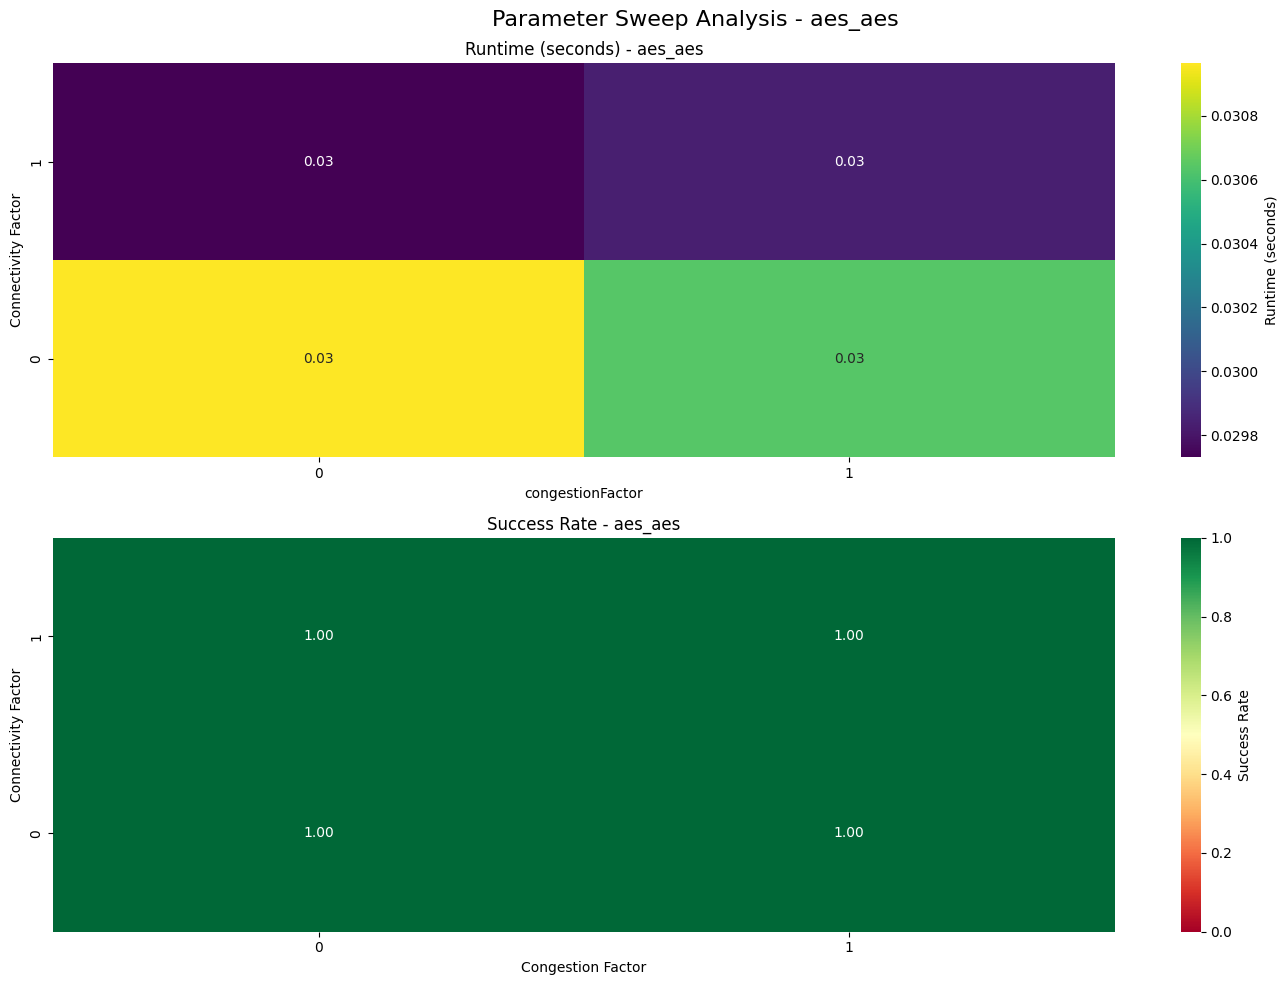

2025-06-20T18:14:09.191996+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_aes_aes_20250620_181408.png
2025-06-20T18:14:09.193619+0100 | INFO | Creating visualization for: bfs_bulk


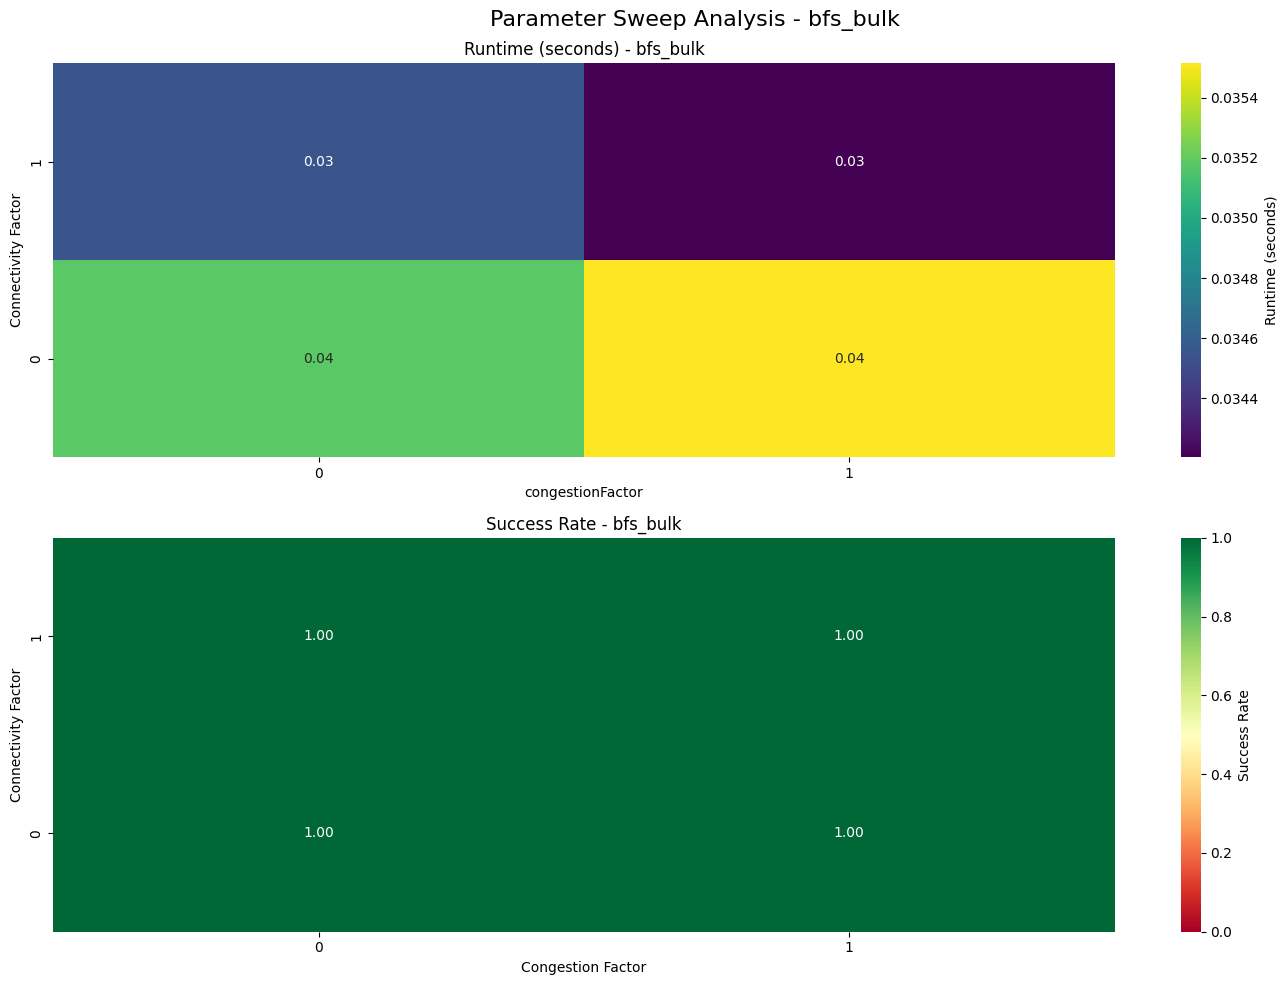

2025-06-20T18:14:09.618501+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_bfs_bulk_20250620_181408.png
2025-06-20T18:14:09.619422+0100 | INFO | Creating visualization for: bfs_queue


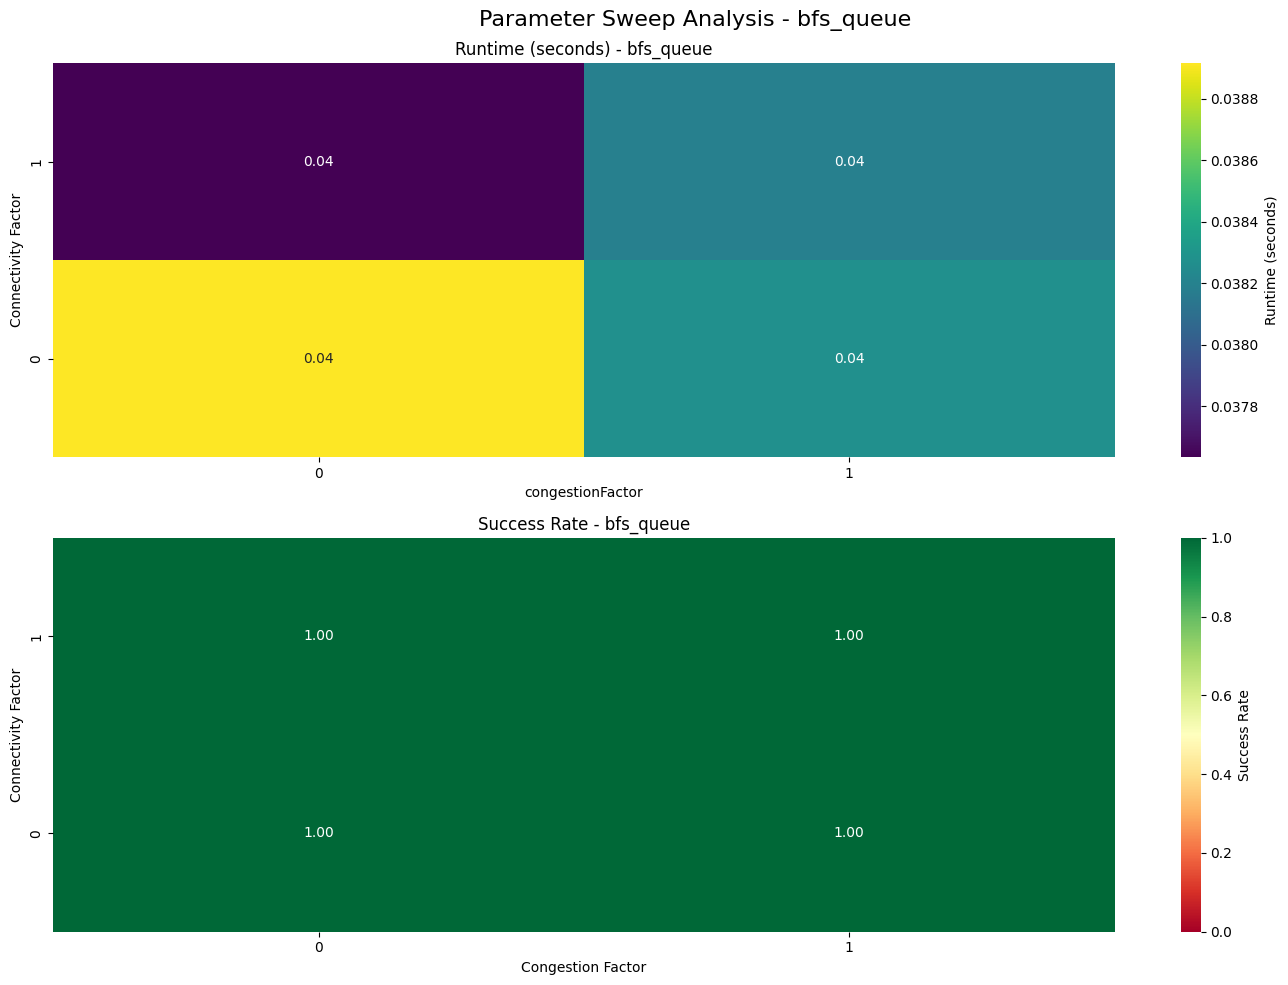

2025-06-20T18:14:10.043249+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_bfs_queue_20250620_181408.png
2025-06-20T18:14:10.044035+0100 | INFO | Creating visualization for: fft_strided


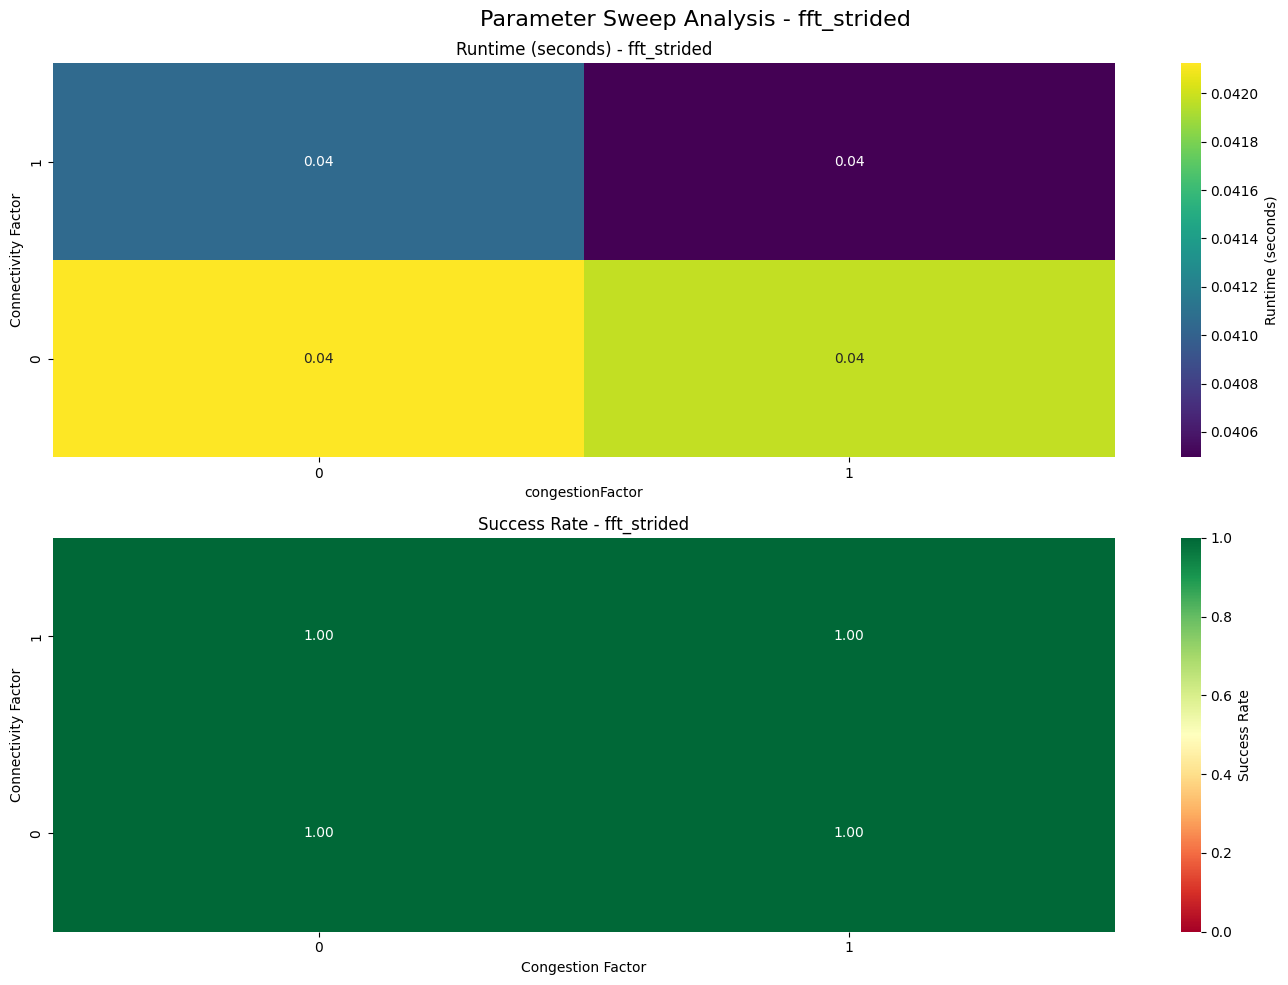

2025-06-20T18:14:10.522626+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_fft_strided_20250620_181408.png
2025-06-20T18:14:10.523455+0100 | INFO | Creating visualization for: fft_transpose


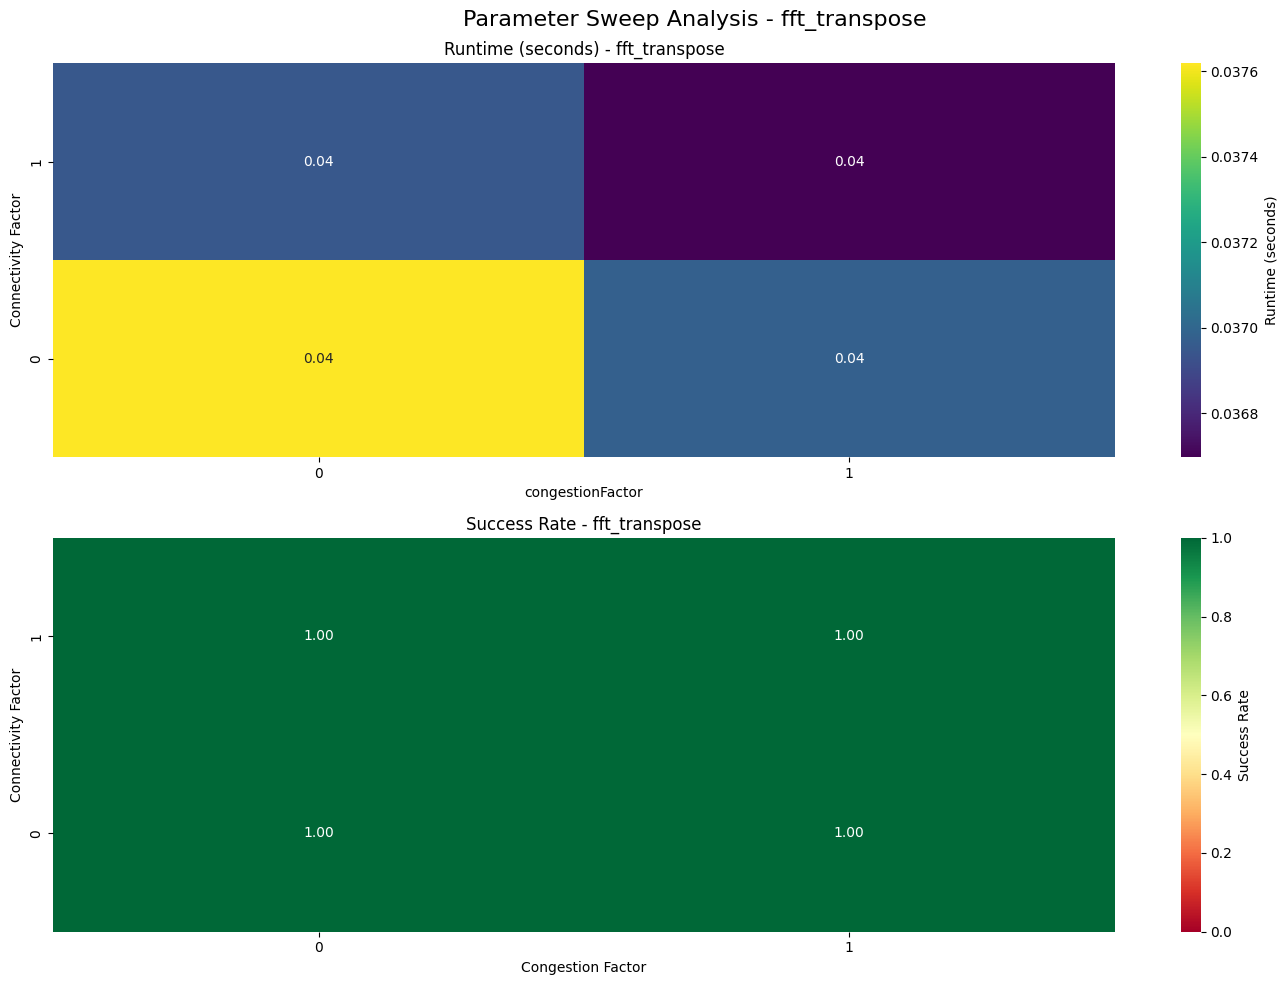

2025-06-20T18:14:10.945993+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_fft_transpose_20250620_181408.png
2025-06-20T18:14:10.946764+0100 | INFO | Creating visualization for: gemm_blocked


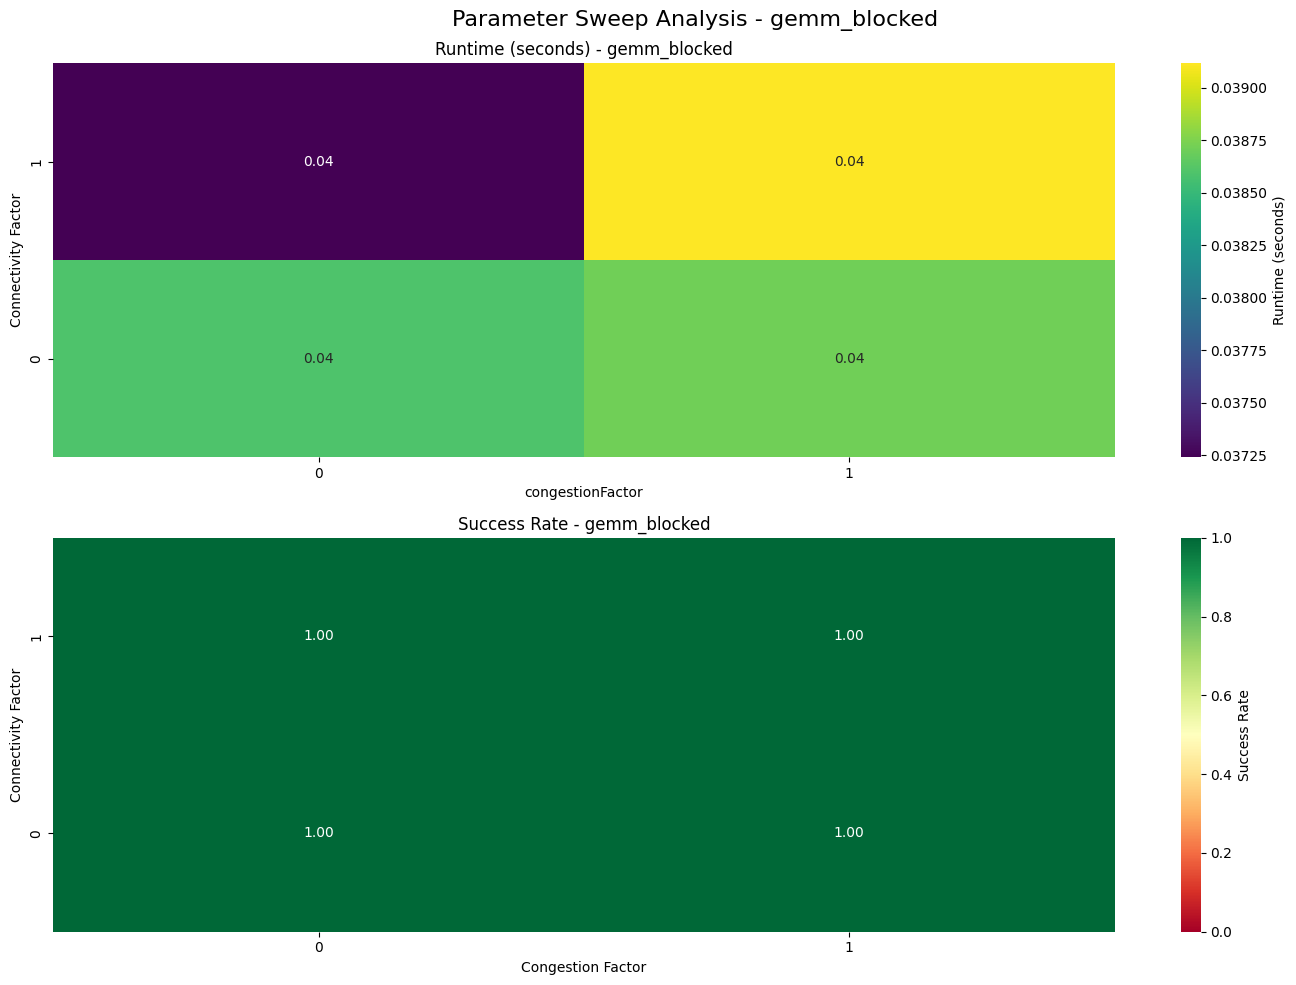

2025-06-20T18:14:11.381041+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_gemm_blocked_20250620_181408.png
2025-06-20T18:14:11.381733+0100 | INFO | Creating visualization for: gemm_ncubed


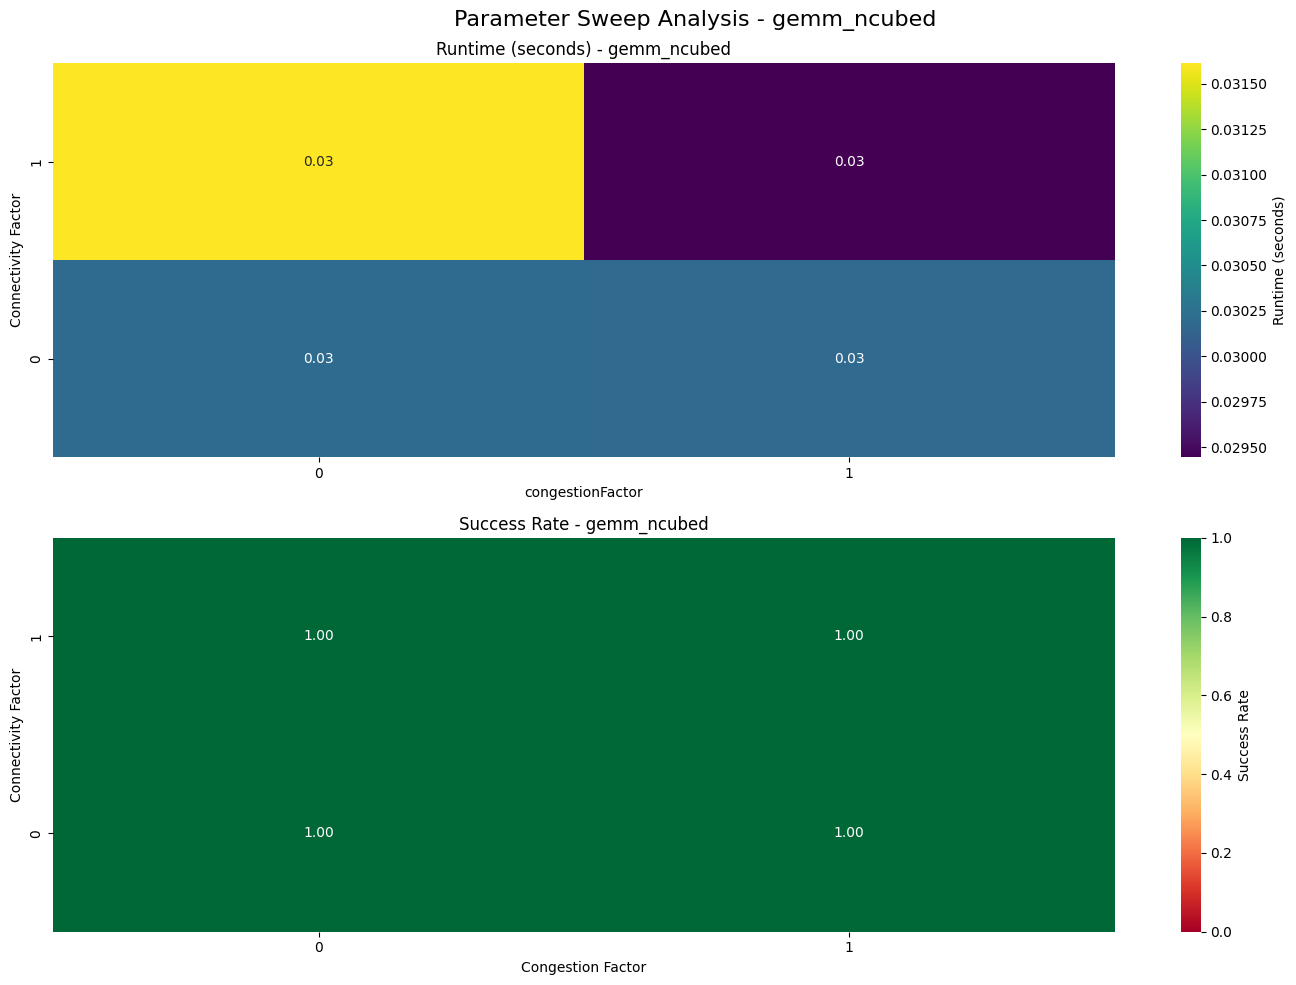

2025-06-20T18:14:11.824060+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_gemm_ncubed_20250620_181408.png
2025-06-20T18:14:11.824927+0100 | INFO | Creating visualization for: kmp_kmp


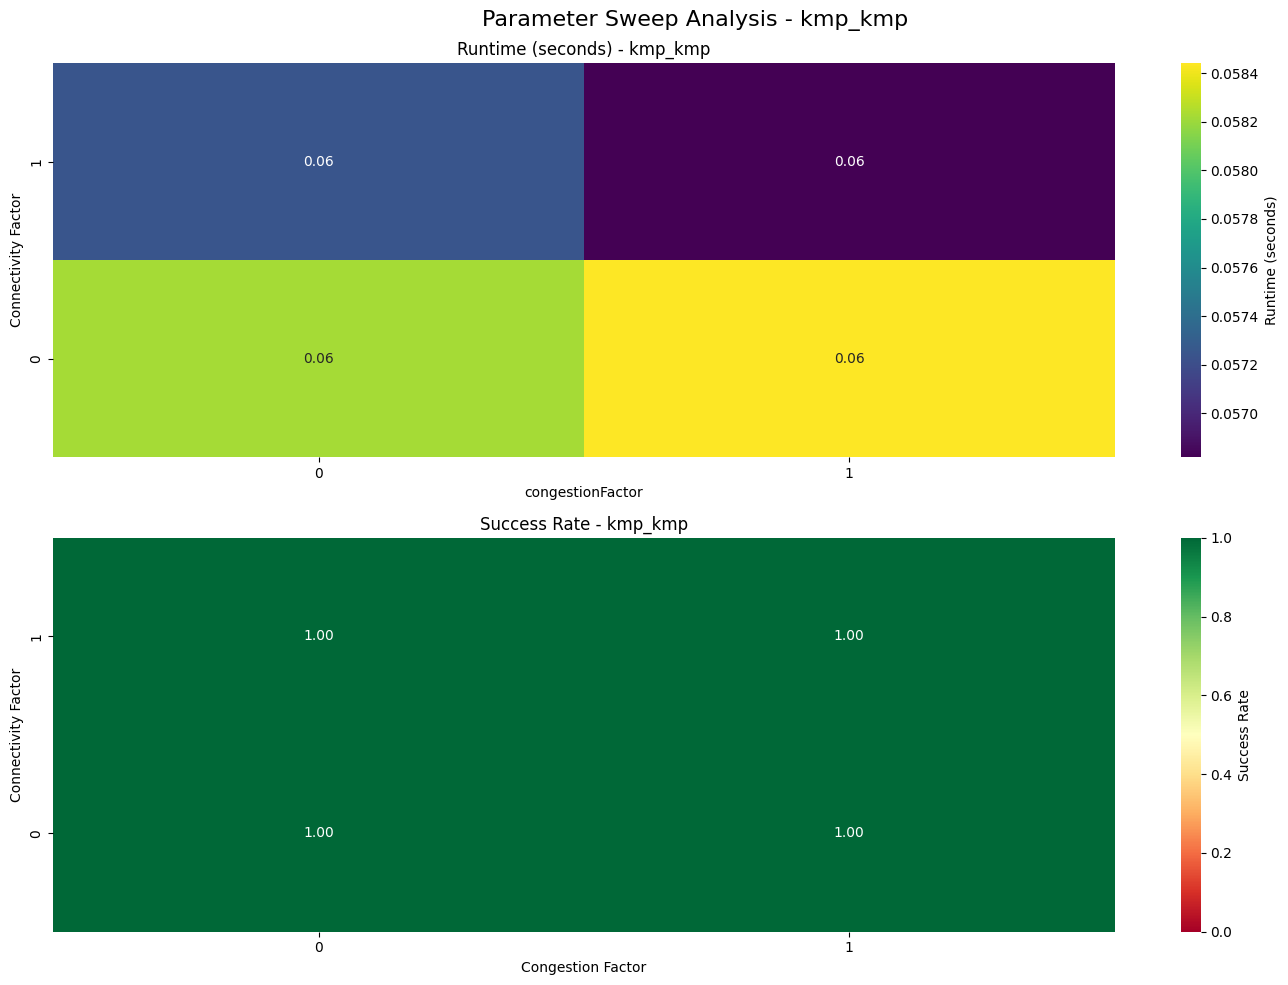

2025-06-20T18:14:12.259102+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_kmp_kmp_20250620_181408.png
2025-06-20T18:14:12.259895+0100 | INFO | Creating visualization for: md_grid


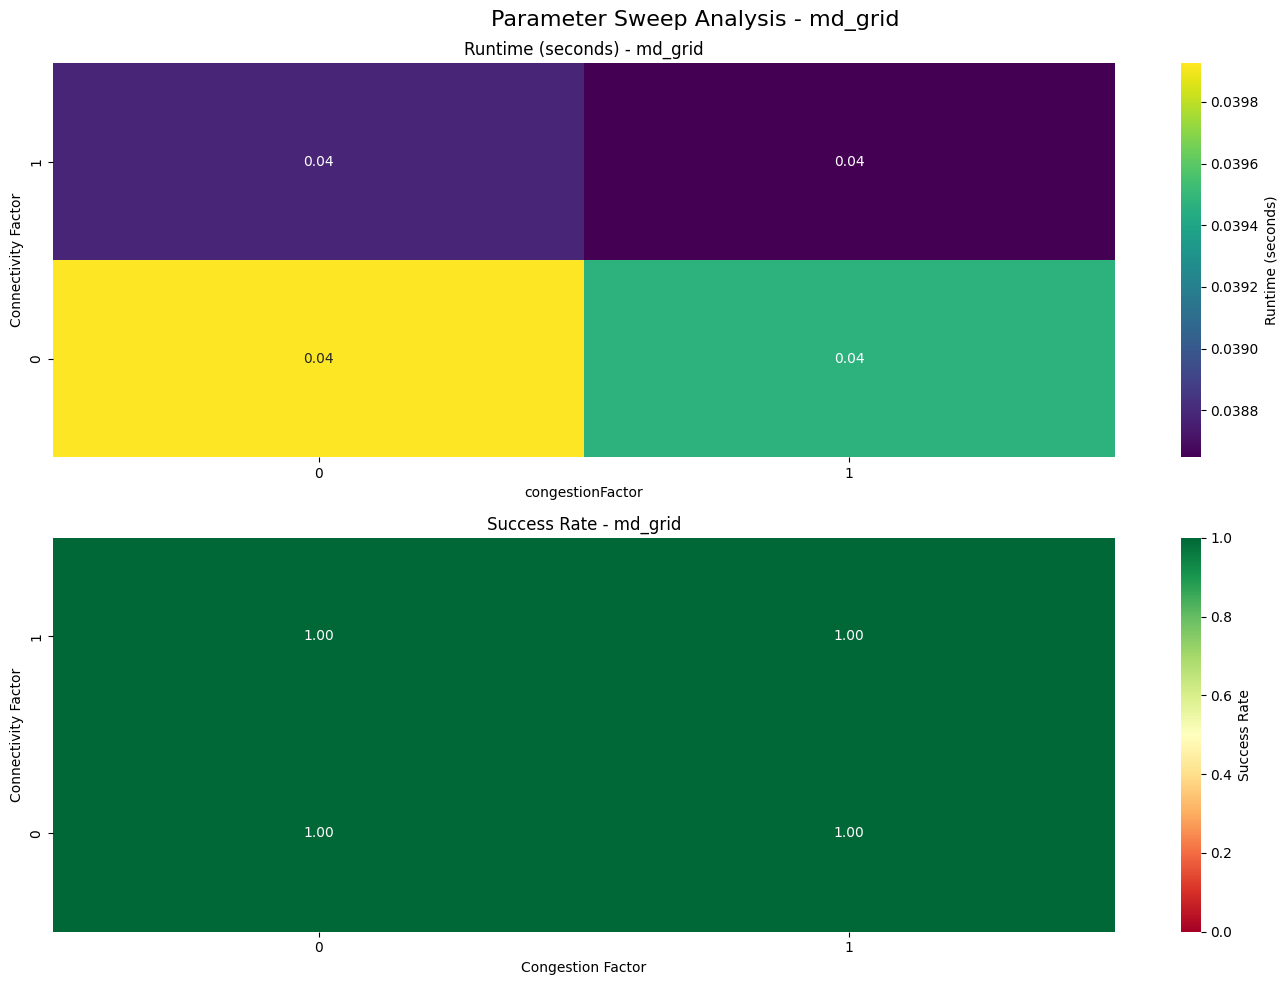

2025-06-20T18:14:12.685746+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_md_grid_20250620_181408.png
2025-06-20T18:14:12.686457+0100 | INFO | Creating visualization for: md_knn


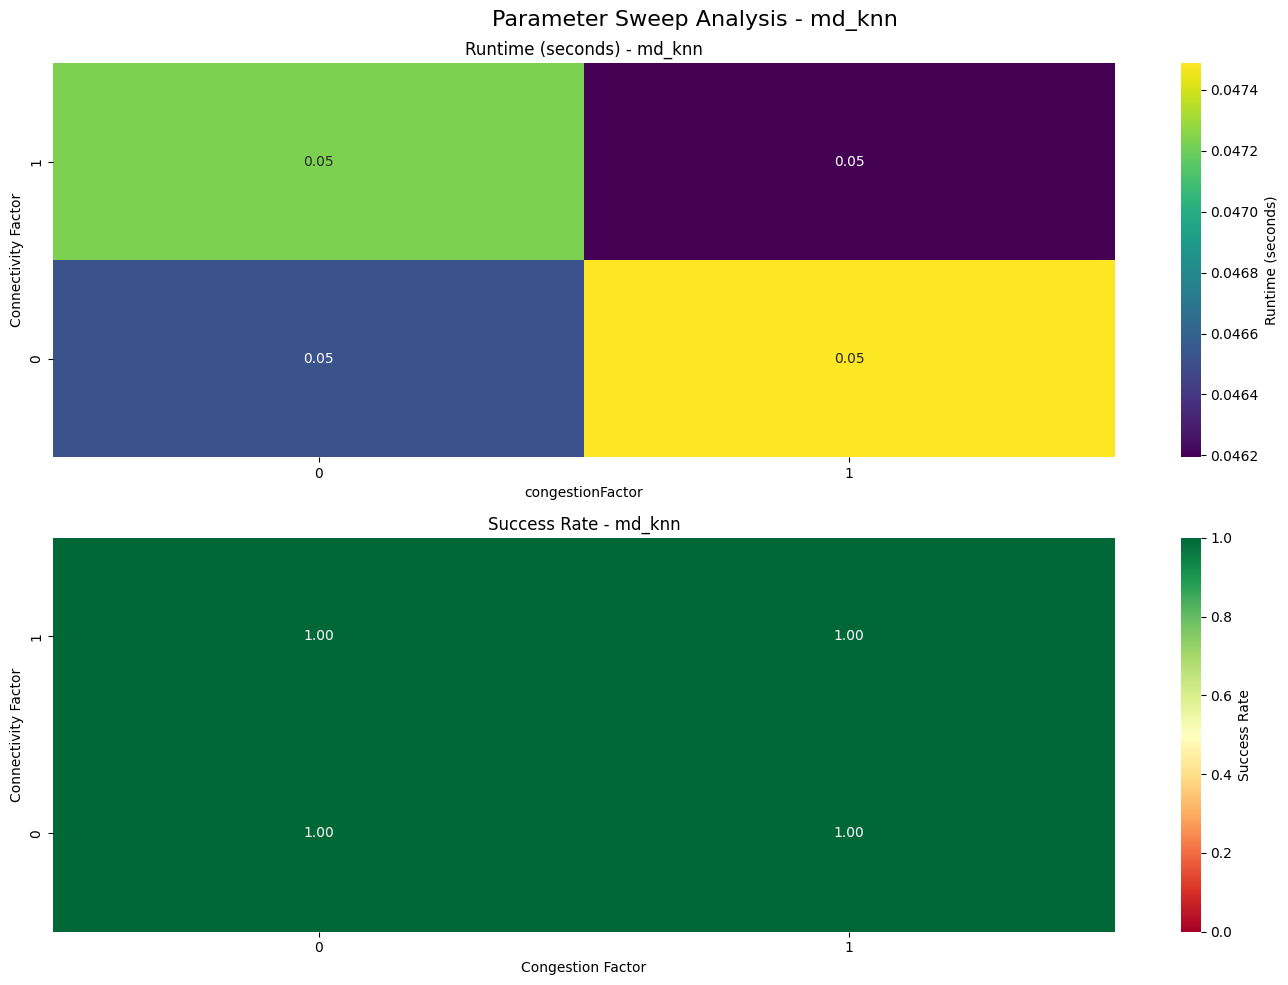

2025-06-20T18:14:13.111846+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_md_knn_20250620_181408.png
2025-06-20T18:14:13.112588+0100 | INFO | Creating visualization for: nw_nw


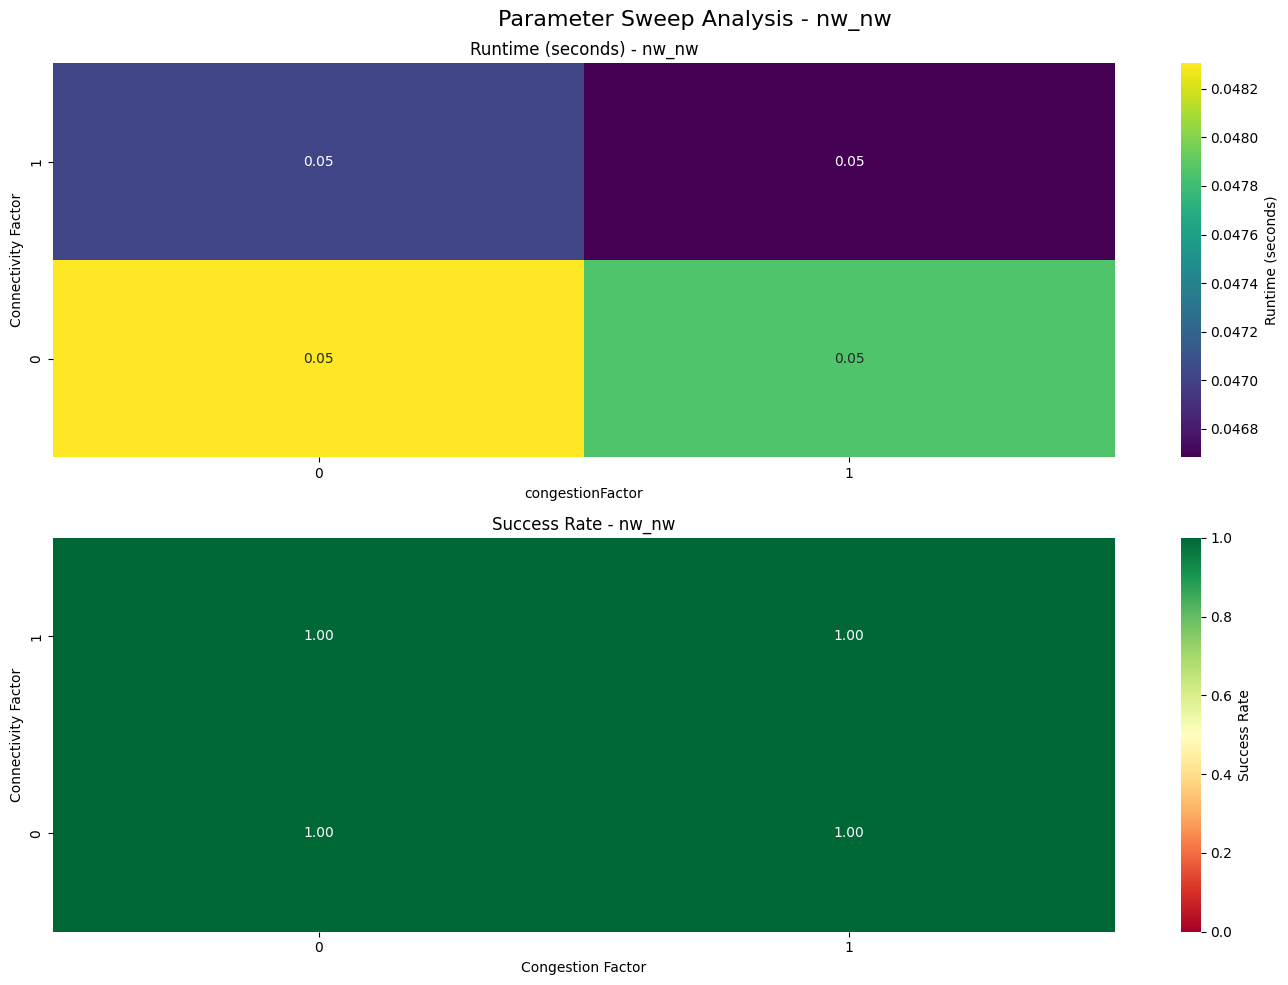

2025-06-20T18:14:13.541129+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_nw_nw_20250620_181408.png
2025-06-20T18:14:13.541911+0100 | INFO | Creating visualization for: sort_merge


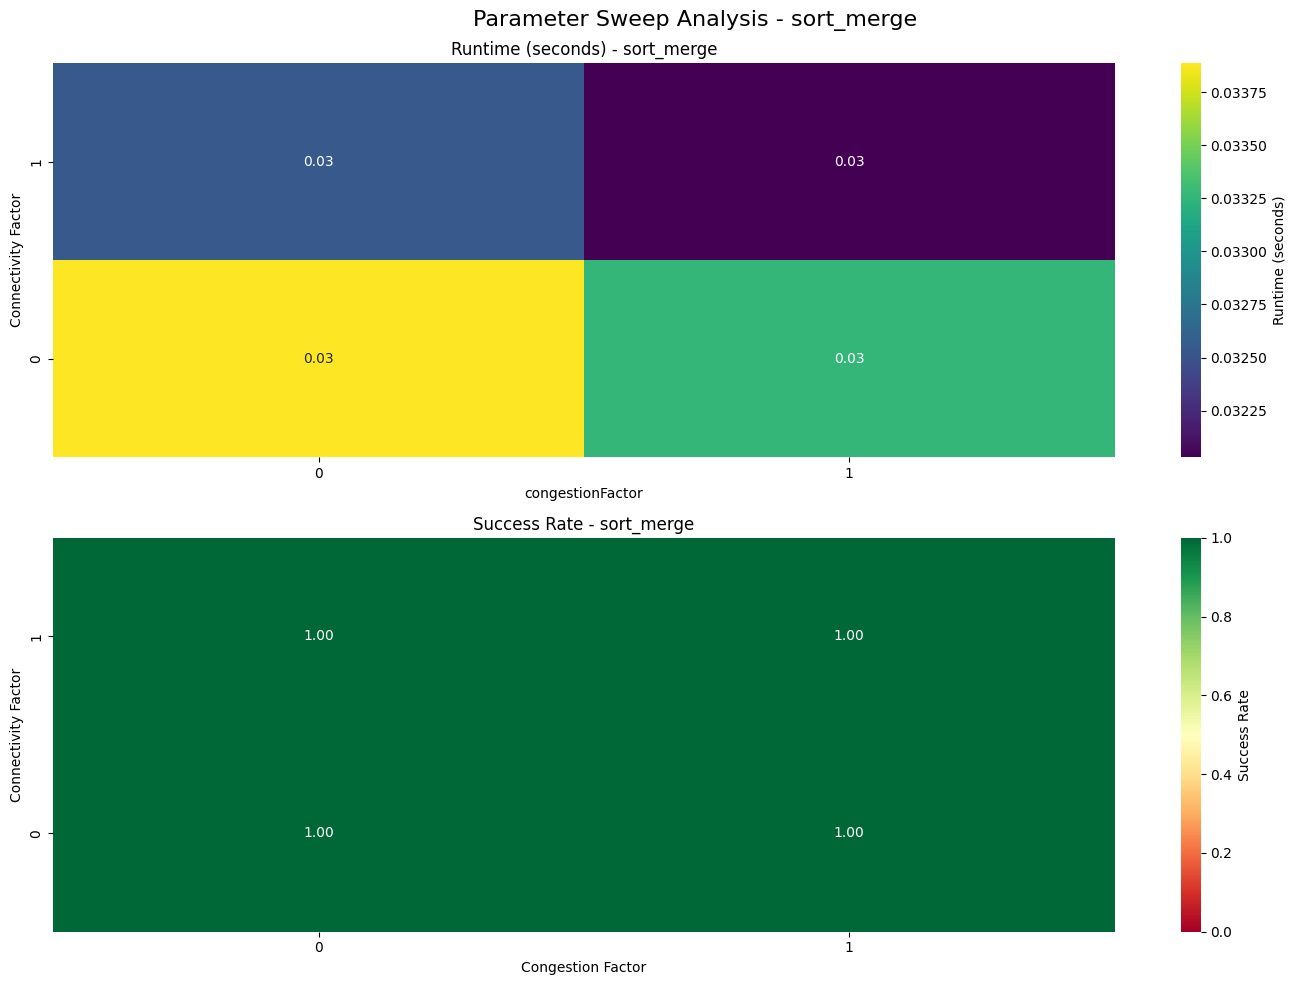

2025-06-20T18:14:14.039056+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_sort_merge_20250620_181408.png
2025-06-20T18:14:14.039852+0100 | INFO | Creating visualization for: sort_radix


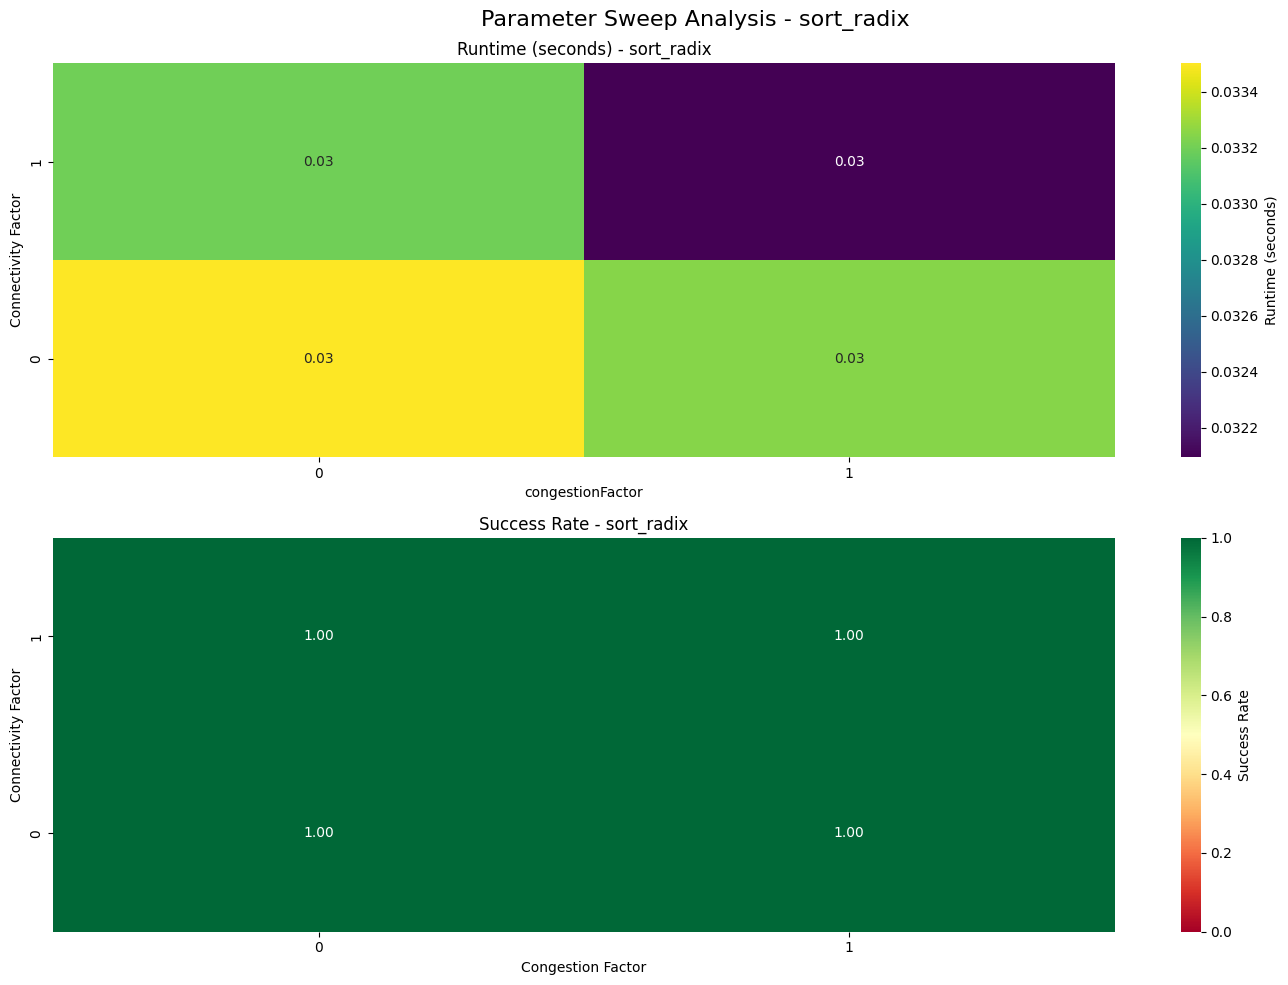

2025-06-20T18:14:14.468630+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_sort_radix_20250620_181408.png
2025-06-20T18:14:14.469482+0100 | INFO | Creating visualization for: spmv_crs


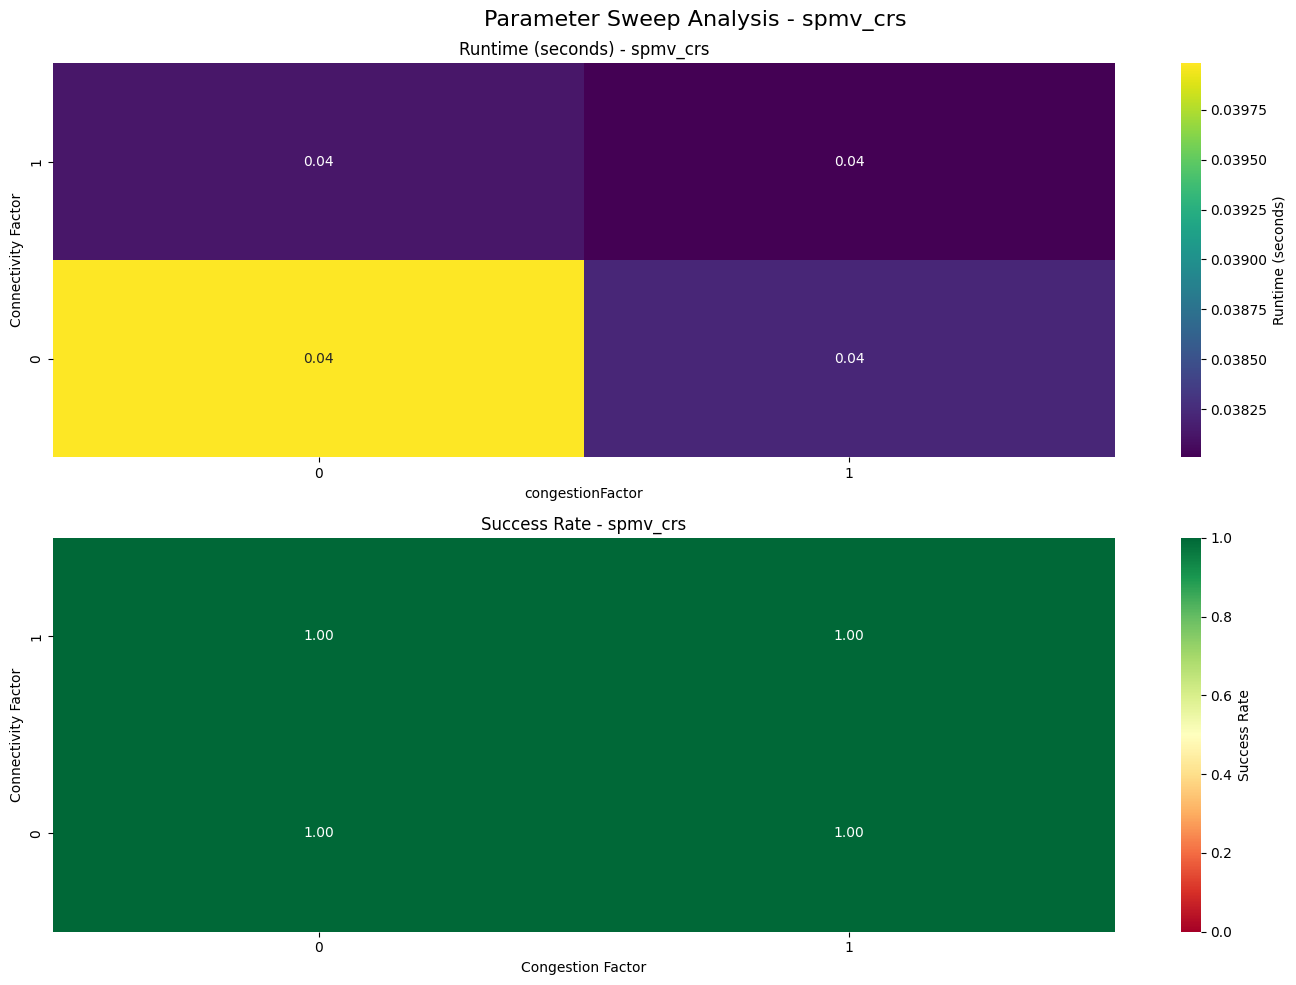

2025-06-20T18:14:14.896899+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_spmv_crs_20250620_181408.png
2025-06-20T18:14:14.897633+0100 | INFO | Creating visualization for: spmv_ellpack


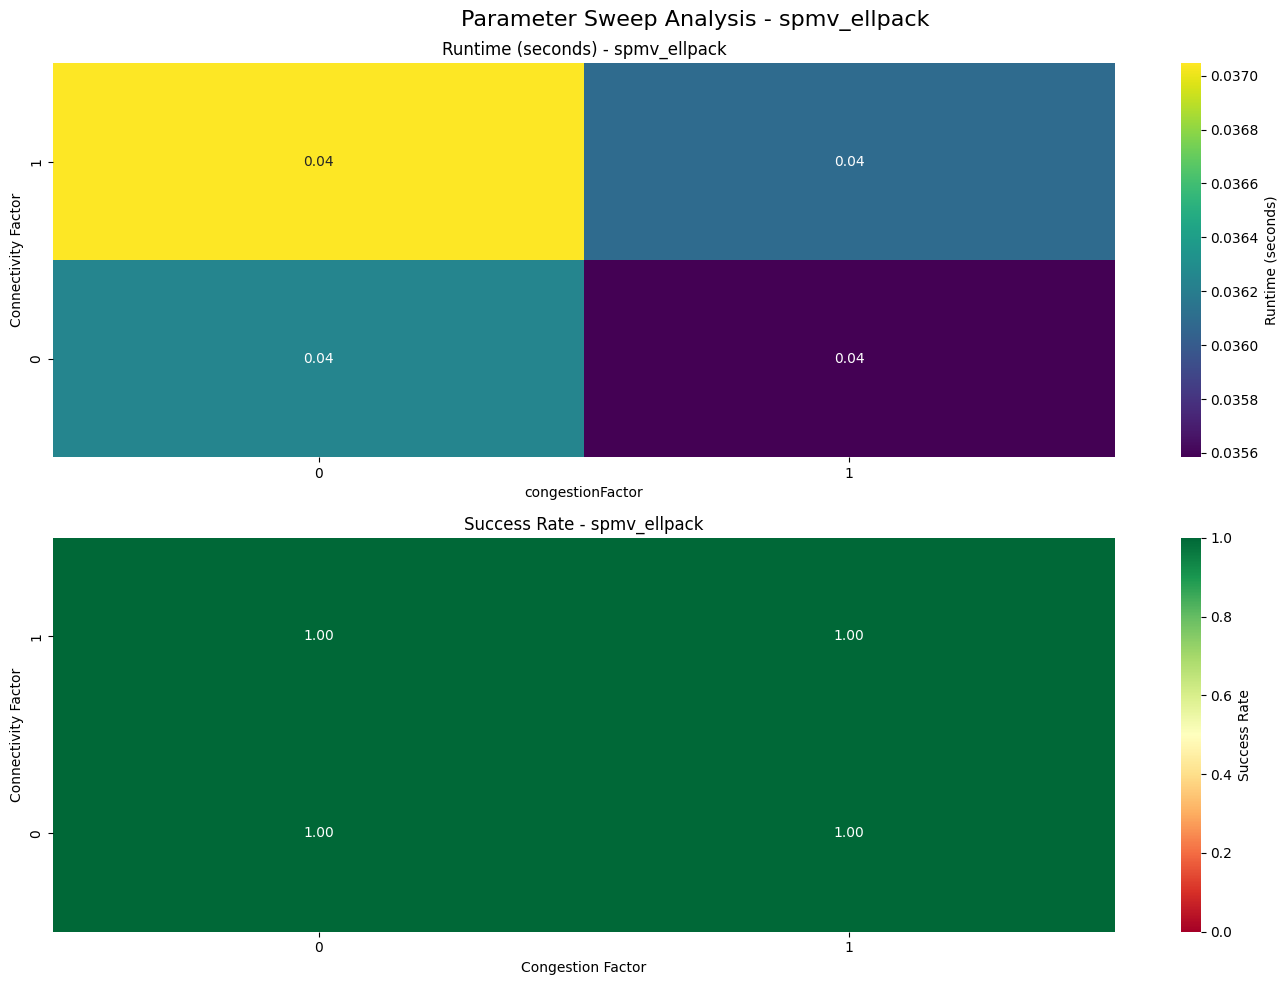

2025-06-20T18:14:15.326044+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_spmv_ellpack_20250620_181408.png
2025-06-20T18:14:15.326828+0100 | INFO | Creating visualization for: stencil_stencil2d


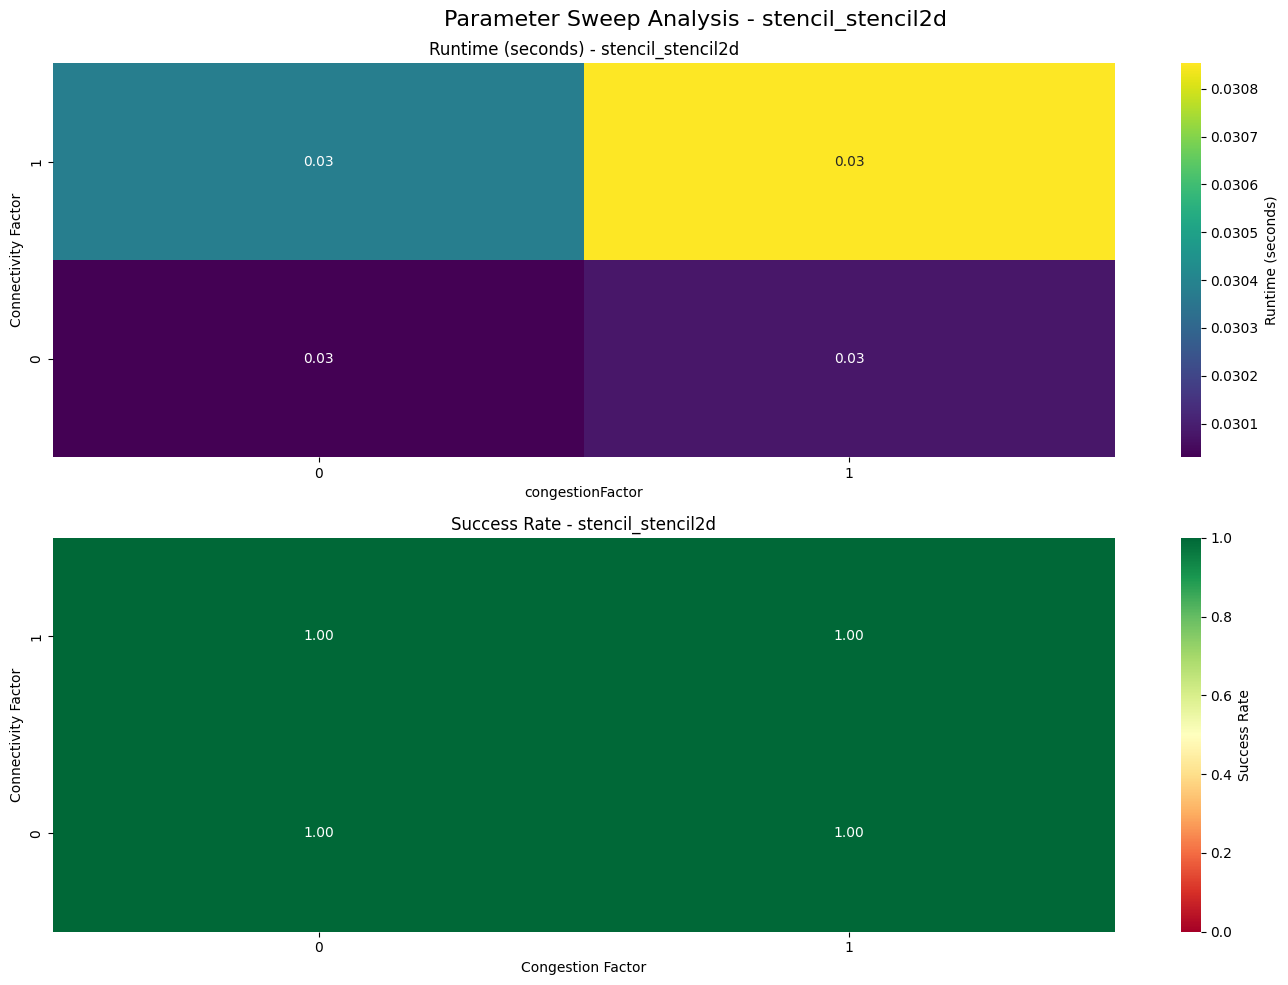

2025-06-20T18:14:15.756427+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_stencil_stencil2d_20250620_181408.png
2025-06-20T18:14:15.757216+0100 | INFO | Creating visualization for: stencil_stencil3d


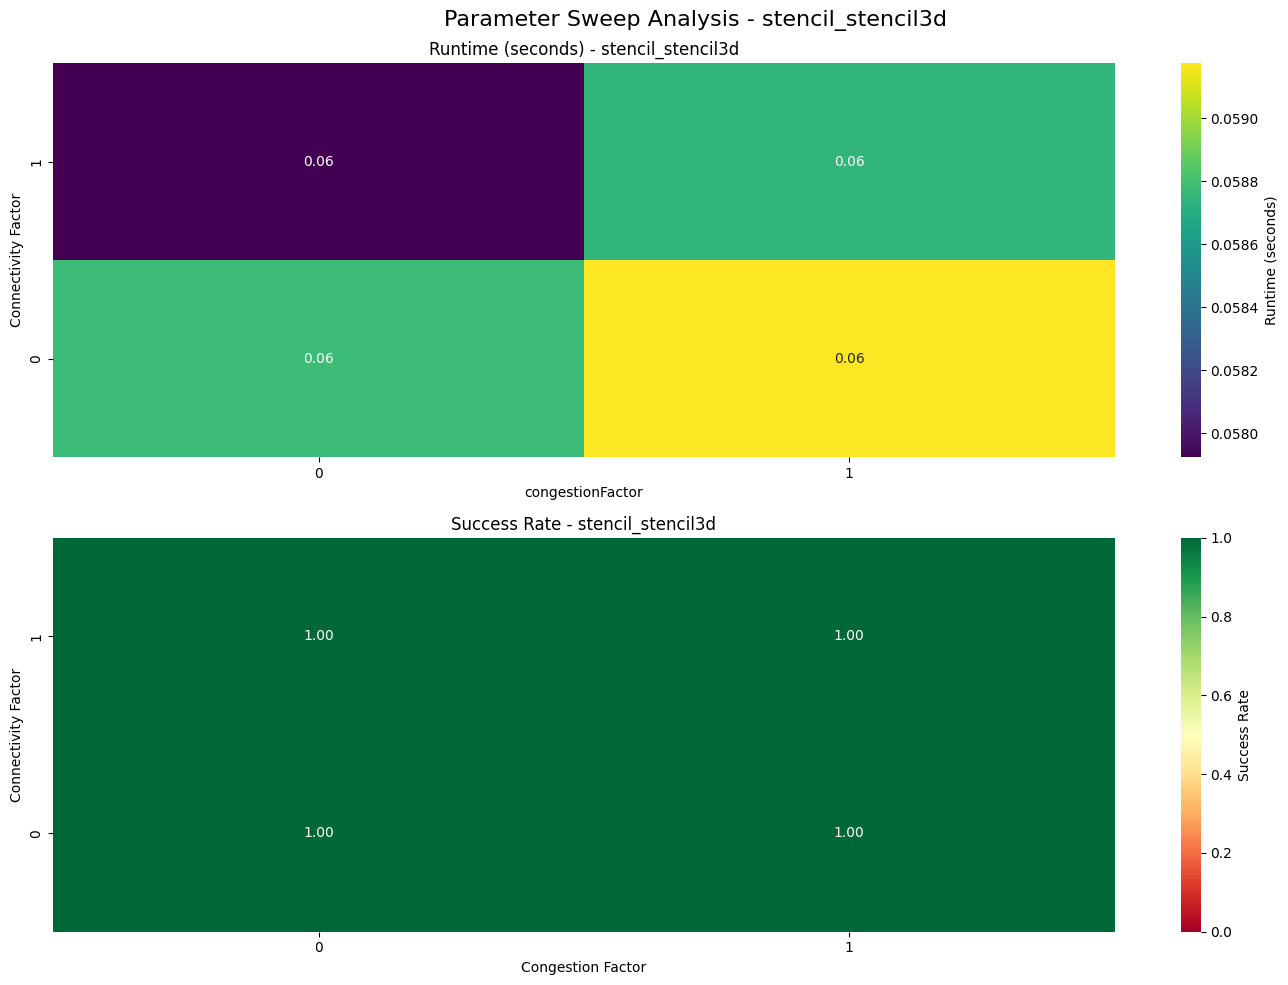

2025-06-20T18:14:16.179460+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_stencil_stencil3d_20250620_181408.png
2025-06-20T18:14:16.180250+0100 | INFO | Creating visualization for: viterbi_viterbi


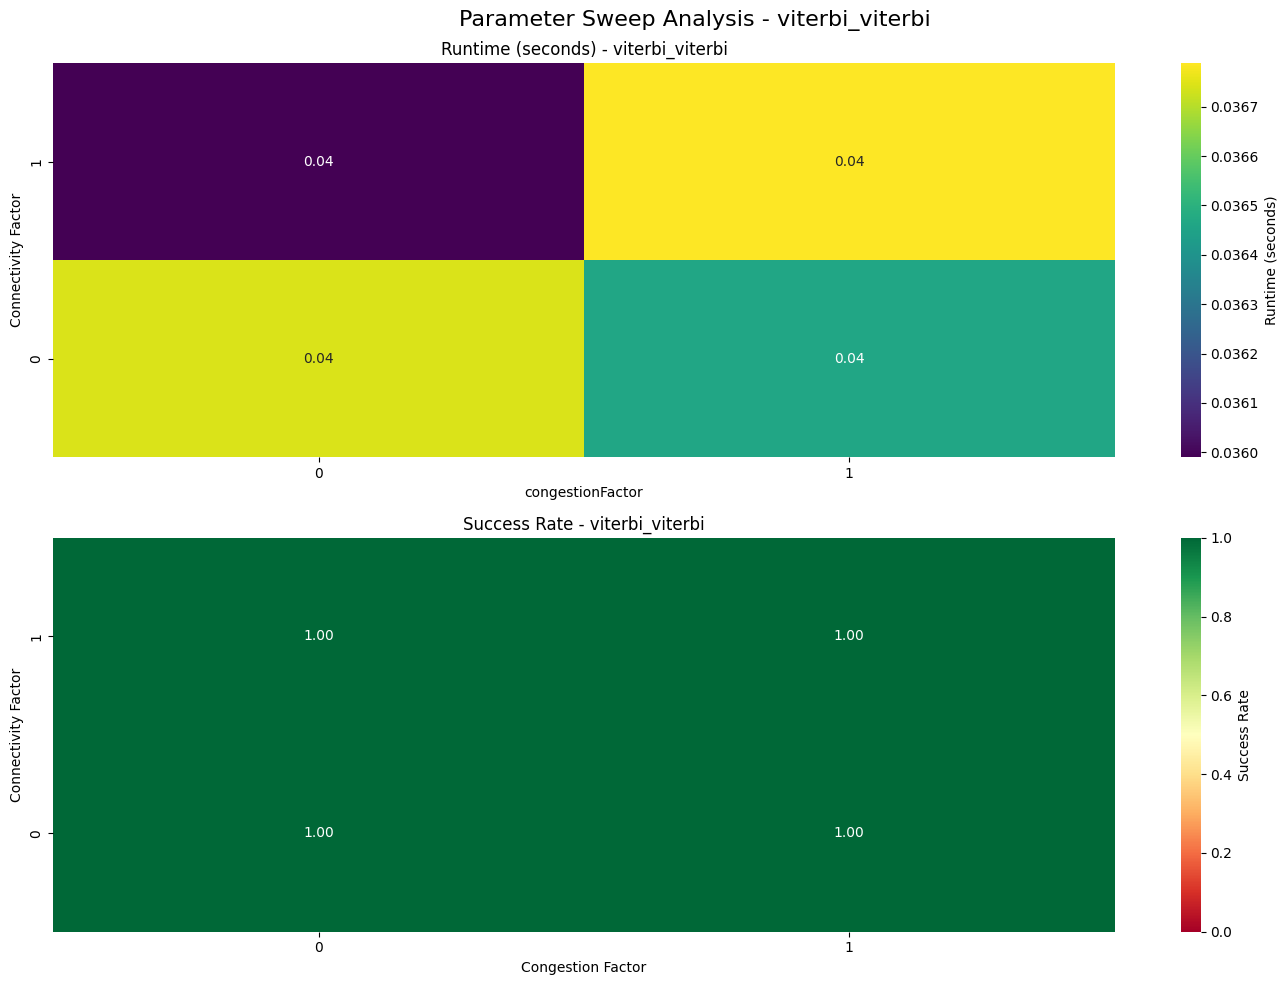

2025-06-20T18:14:16.607703+0100 | INFO | Individual visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_viterbi_viterbi_20250620_181408.png
2025-06-20T18:14:16.607963+0100 | INFO | Creating combined analysis visualization...


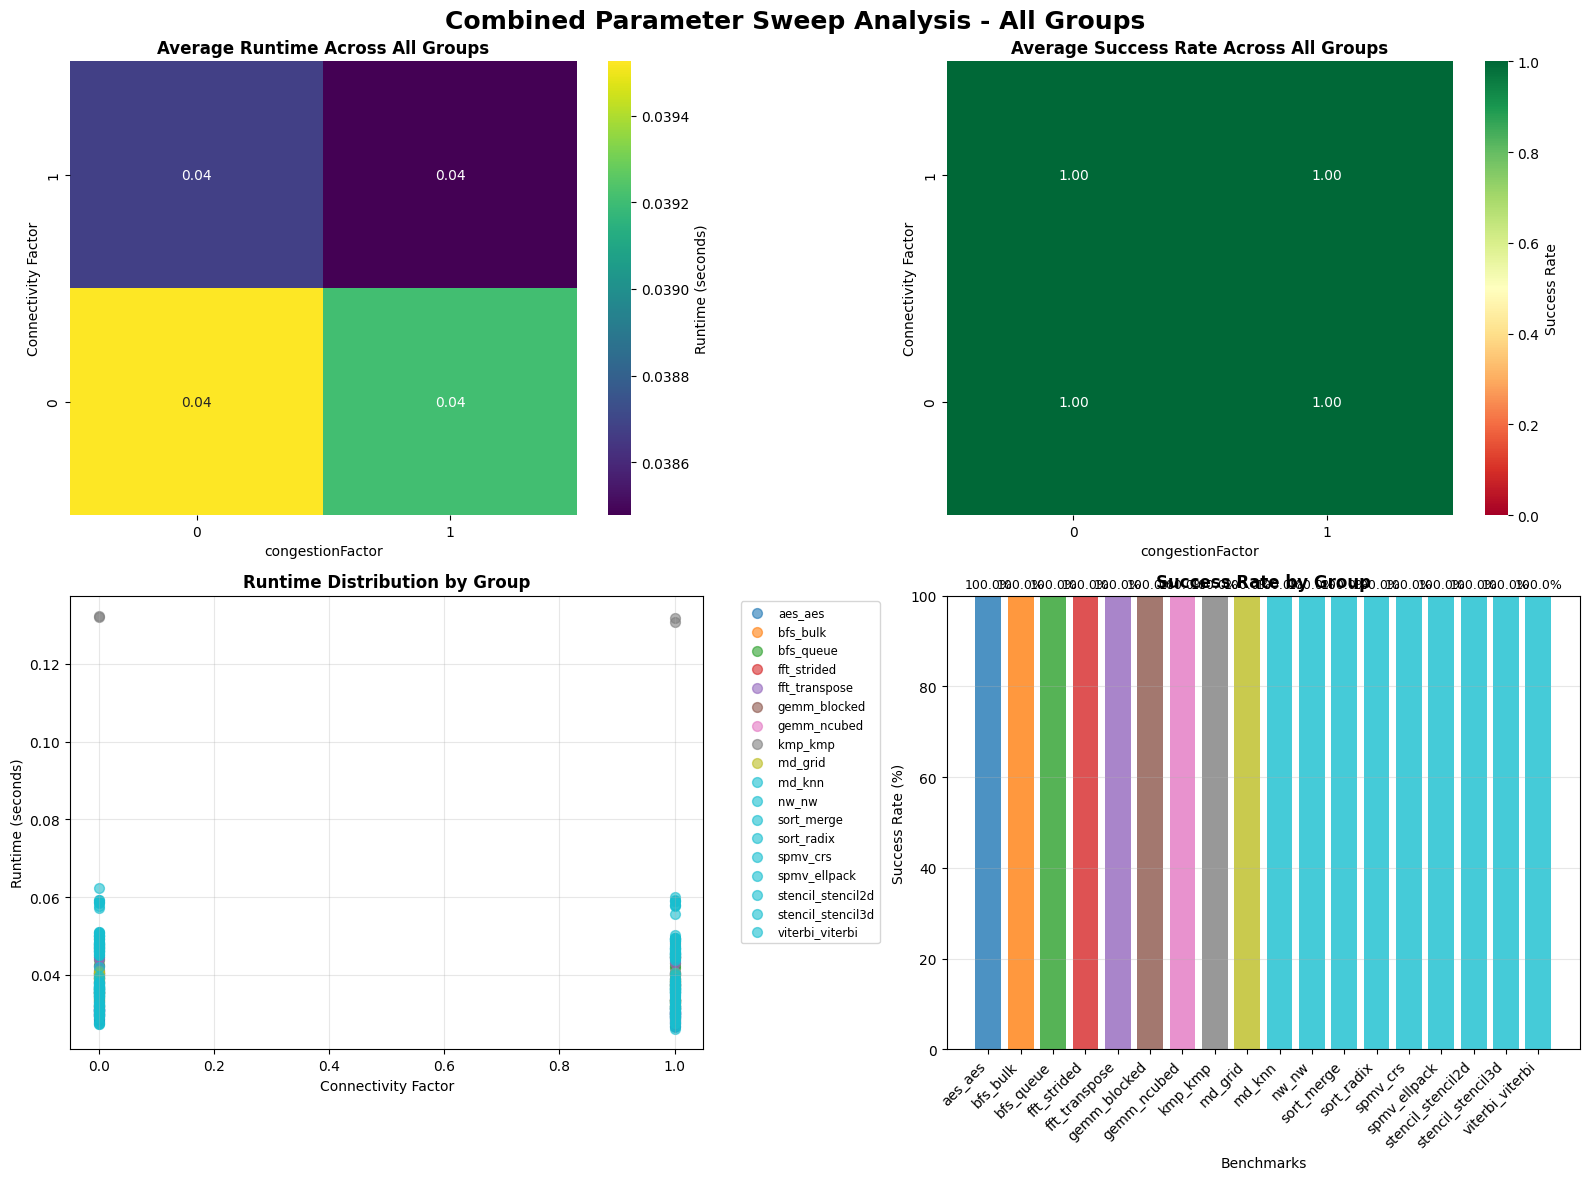

2025-06-20T18:14:17.683008+0100 | INFO | Combined analysis visualization saved: /home/kelvin/FABulous_fork/myProject/PnR/results/parameter_sweep_combined_analysis_20250620_181408.png
2025-06-20T18:14:17.685047+0100 | INFO | Creating enhanced failure detection visualizations...
2025-06-20T18:14:17.860595+0100 | ERROR | Error creating enhanced visualizations: name 'hasMultipleFiles' is not defined
Error in enhanced visualization: name 'hasMultipleFiles' is not defined

PARAMETER SWEEP COMPLETE
Total parameter combinations tested: 432
Successful runs: 432
Results directory: /home/kelvin/FABulous_fork/myProject/PnR/results

=== Environment Variables ===
You can customize the following settings by setting environment variables:
- MY_FAB_ROOT: FABulous root directory (default: /home/kelvin/FABulous_fork)
- FAB_PROJ_DIR: Project directory name (default: myProject)
- GENERATED_VERILOG_DIR: Directory containing generated Verilog files
- OUTPUT_DIR: Results output directory
- BETA_VALUE: Placer 

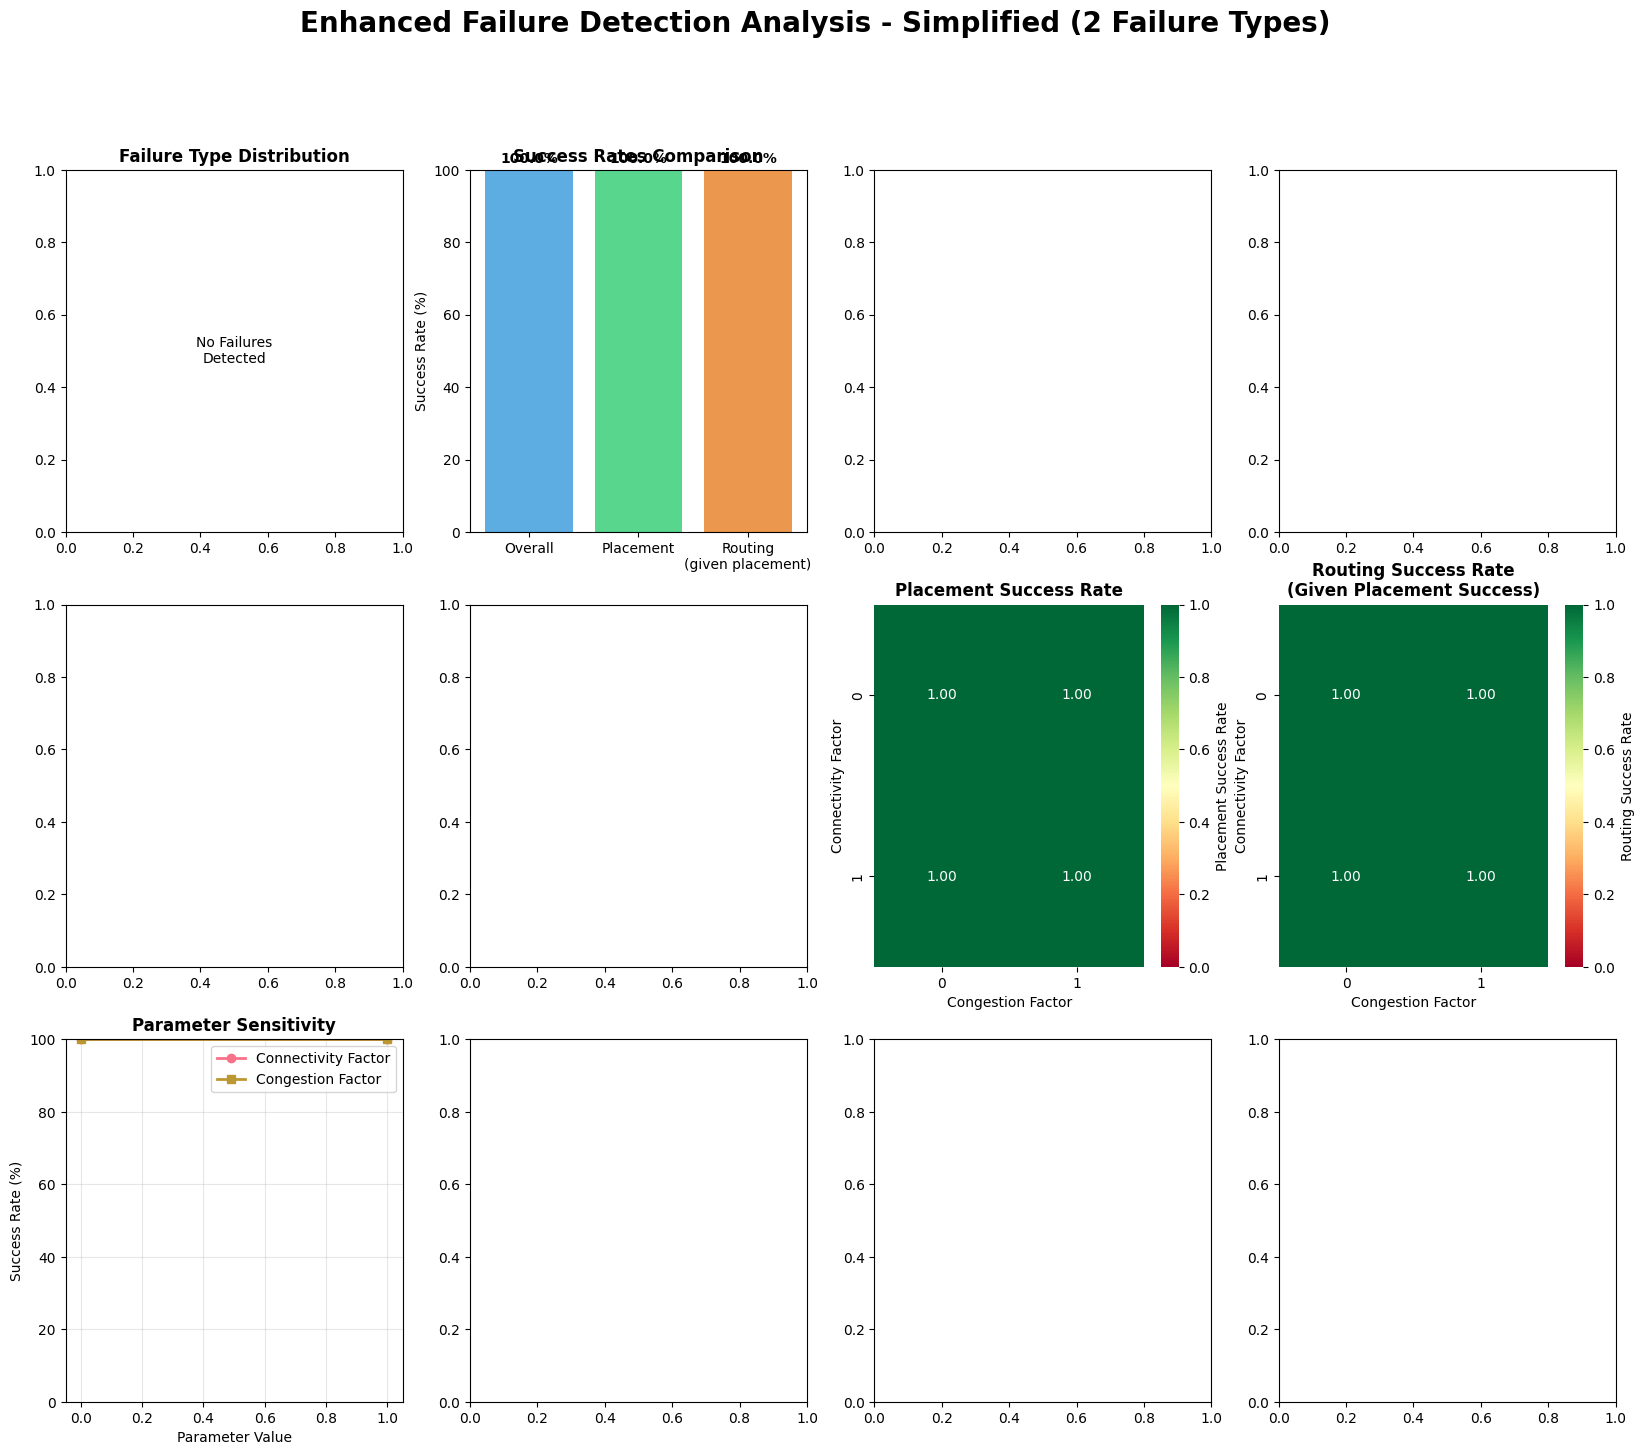

In [12]:
# Optional: Create visualizations if matplotlib is available
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if df['success'].any():
        successful_df = df[df['success']]

        # Round axis values to 2 decimal places to avoid floating point artifacts
        successful_df = successful_df.copy()
        successful_df["connectivityFactor"] = successful_df["connectivityFactor"].round(2)
        successful_df["congestionFactor"] = successful_df["congestionFactor"].round(2)
        df_rounded = df.copy()
        df_rounded["connectivityFactor"] = df_rounded["connectivityFactor"].round(2)
        df_rounded["congestionFactor"] = df_rounded["congestionFactor"].round(2)

        # Ensure both axes are sorted - congestion ascending (left to right), connectivity descending (bottom to top)
        connectivityOrder = sorted(successful_df["connectivityFactor"].unique(), reverse=True)  # Reverse to put 0.0 at bottom
        congestionOrder = sorted(successful_df["congestionFactor"].unique())  # Normal order to put 0.0 at left

        # Determine if we have grouping dimensions
        groupingCol = None
        groupingValues = None
        
        if 'benchmarkName' in df.columns and df['benchmarkName'].nunique() > 1:
            groupingCol = 'benchmarkName'
            groupingValues = sorted(df['benchmarkName'].unique())
        elif 'sourceFileName' in df.columns and df['sourceFileName'].nunique() > 1:
            groupingCol = 'sourceFileName'
            groupingValues = sorted(df['sourceFileName'].unique())
        
        # Generate group-specific visualizations if we have multiple groups
        if groupingCol and groupingValues:
            logger.info(f"Creating visualizations for {len(groupingValues)} {groupingCol.replace('Name', 's').lower()}...")
            
            for groupValue in groupingValues:
                groupSuccessful = successful_df[successful_df[groupingCol] == groupValue]
                groupAll = df_rounded[df_rounded[groupingCol] == groupValue]
                
                if len(groupSuccessful) == 0:
                    logger.info(f"Skipping {groupValue} - no successful runs")
                    continue
                
                displayName = Path(groupValue).stem if 'fileName' in groupingCol else groupValue
                logger.info(f"Creating visualization for: {displayName}")
                
                plt.figure(figsize=(14, 10))
                plt.suptitle(f"Parameter Sweep Analysis - {displayName}", fontsize=16)
                
                # Runtime heatmap
                plt.subplot(2, 1, 1)
                try:
                    runtimePivot = groupSuccessful.pivot_table(
                        values="runtime",
                        index="connectivityFactor",
                        columns="congestionFactor",
                        aggfunc="mean"
                    ).reindex(index=connectivityOrder, columns=congestionOrder)
                    
                    sns.heatmap(runtimePivot, annot=True, fmt=".2f", cmap="viridis",
                               cbar_kws={'label': 'Runtime (seconds)'})
                    plt.title(f"Runtime (seconds) - {displayName}")
                    plt.ylabel("Connectivity Factor")
                except Exception as e:
                    plt.text(0.5, 0.5, f'Runtime data not available\n{str(e)}',
                            ha='center', va='center', transform=plt.gca().transAxes)
                    plt.title(f"Runtime Analysis - {displayName}")
                
                # Success rate heatmap
                plt.subplot(2, 1, 2)
                try:
                    successPivot = groupAll.pivot_table(
                        values="success",
                        index="connectivityFactor",
                        columns="congestionFactor",
                        aggfunc="mean"
                    ).reindex(index=connectivityOrder, columns=congestionOrder)
                    
                    sns.heatmap(successPivot, annot=True, fmt=".2f", cmap="RdYlGn", 
                               vmin=0, vmax=1, cbar_kws={'label': 'Success Rate'})
                    plt.title(f"Success Rate - {displayName}")
                    plt.ylabel("Connectivity Factor")
                    plt.xlabel("Congestion Factor")
                except Exception as e:
                    plt.text(0.5, 0.5, f'Success rate data not available\n{str(e)}',
                            ha='center', va='center', transform=plt.gca().transAxes)
                    plt.title(f"Success Rate Analysis - {displayName}")
                
                plt.tight_layout()
                
                # Save individual plot
                cleanName = displayName.replace(".", "_").replace(" ", "_")
                plotFile = OUTPUT_DIR / f"parameter_sweep_{cleanName}_{timestamp}.png"
                plt.savefig(plotFile, dpi=300, bbox_inches="tight")
                plt.show()
                
                logger.info(f"Individual visualization saved: {plotFile}")
            
            # Create combined analysis visualization
            logger.info("Creating combined analysis visualization...")
            plt.figure(figsize=(16, 12))
            plt.suptitle("Combined Parameter Sweep Analysis - All Groups", fontsize=18, fontweight='bold')
            
            # Combined runtime heatmap (average across all groups)
            plt.subplot(2, 2, 1)
            try:
                combinedRuntimePivot = successful_df.pivot_table(
                    values="runtime",
                    index="connectivityFactor",
                    columns="congestionFactor",
                    aggfunc="mean"
                ).reindex(index=connectivityOrder, columns=congestionOrder)
                
                sns.heatmap(combinedRuntimePivot, annot=True, fmt=".2f", cmap="viridis",
                           cbar_kws={'label': 'Runtime (seconds)'})
                plt.title("Average Runtime Across All Groups", fontweight='bold')
                plt.ylabel("Connectivity Factor")
            except Exception as e:
                plt.text(0.5, 0.5, f'Combined runtime data\nnot available',
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title("Combined Runtime Analysis")
            
            # Combined success rate heatmap
            plt.subplot(2, 2, 2)
            try:
                combinedSuccessPivot = df_rounded.pivot_table(
                    values="success",
                    index="connectivityFactor",
                    columns="congestionFactor",
                    aggfunc="mean"
                ).reindex(index=connectivityOrder, columns=congestionOrder)
                
                sns.heatmap(combinedSuccessPivot, annot=True, fmt=".2f", cmap="RdYlGn",
                           vmin=0, vmax=1, cbar_kws={'label': 'Success Rate'})
                plt.title("Average Success Rate Across All Groups", fontweight='bold')
                plt.ylabel("Connectivity Factor")
            except Exception as e:
                plt.text(0.5, 0.5, f'Combined success data\nnot available',
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title("Combined Success Rate Analysis")
            
            # Runtime distribution by group
            plt.subplot(2, 2, 3)
            try:
                groupColors = plt.cm.tab10(range(len(groupingValues)))
                for i, groupValue in enumerate(groupingValues):
                    groupData = successful_df[successful_df[groupingCol] == groupValue]
                    if len(groupData) > 0:
                        displayName = Path(groupValue).stem if 'fileName' in groupingCol else groupValue
                        plt.scatter(groupData['connectivityFactor'], groupData['runtime'],
                                  alpha=0.6, label=displayName, s=50, color=groupColors[i])
                
                plt.xlabel("Connectivity Factor")
                plt.ylabel("Runtime (seconds)")
                plt.title("Runtime Distribution by Group", fontweight='bold')
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
                plt.grid(True, alpha=0.3)
            except Exception as e:
                plt.text(0.5, 0.5, f'Runtime distribution\nnot available',
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title("Runtime Distribution Analysis")
            
            # Success rate by group
            plt.subplot(2, 2, 4)
            try:
                groupSuccessRates = []
                groupNames = []
                
                for groupValue in groupingValues:
                    groupData = df_rounded[df_rounded[groupingCol] == groupValue]
                    successRate = groupData['success'].mean() * 100
                    groupSuccessRates.append(successRate)
                    displayName = Path(groupValue).stem if 'fileName' in groupingCol else groupValue
                    groupNames.append(displayName)
                
                bars = plt.bar(range(len(groupNames)), groupSuccessRates,
                              color=groupColors[:len(groupNames)], alpha=0.8)
                plt.xlabel(f"{groupingCol.replace('Name', 's').title()}")
                plt.ylabel("Success Rate (%)")
                plt.title("Success Rate by Group", fontweight='bold')
                plt.xticks(range(len(groupNames)), groupNames, rotation=45, ha='right')
                plt.grid(True, alpha=0.3, axis='y')
                plt.ylim(0, 100)
                
                # Add value labels on bars
                for bar, value in zip(bars, groupSuccessRates):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                            f'{value:.1f}%', ha='center', va='bottom', fontsize=9)
            except Exception as e:
                plt.text(0.5, 0.5, f'Success rate by group\nnot available',
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title("Group Success Rate Analysis")
            
            plt.tight_layout()
            
            # Save combined plot
            combinedPlotFile = OUTPUT_DIR / f"parameter_sweep_combined_analysis_{timestamp}.png"
            plt.savefig(combinedPlotFile, dpi=300, bbox_inches="tight")
            plt.show()
            
            logger.info(f"Combined analysis visualization saved: {combinedPlotFile}")
        
        else:
            # Single group visualization
            logger.info("Creating single-group visualization...")
            plt.figure(figsize=(12, 8))
            
            # Runtime heatmap
            plt.subplot(2, 1, 1)
            try:
                runtimePivot = successful_df.pivot_table(
                    values="runtime",
                    index="connectivityFactor",
                    columns="congestionFactor",
                    aggfunc="mean"
                ).reindex(index=connectivityOrder, columns=congestionOrder)
                
                sns.heatmap(runtimePivot, annot=True, fmt=".2f", cmap="viridis",
                           cbar_kws={'label': 'Runtime (seconds)'})
                plt.title("Runtime (seconds) - Parameter Combination Analysis")
                plt.ylabel("Connectivity Factor")
            except Exception as e:
                plt.text(0.5, 0.5, f'Runtime data not available\n{str(e)}',
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title("Runtime Analysis")
            
            # Success rate heatmap
            plt.subplot(2, 1, 2)
            try:
                successPivot = df_rounded.pivot_table(
                    values="success",
                    index="connectivityFactor",
                    columns="congestionFactor",
                    aggfunc="mean"
                ).reindex(index=connectivityOrder, columns=congestionOrder)
                
                sns.heatmap(successPivot, annot=True, fmt=".2f", cmap="RdYlGn",
                           vmin=0, vmax=1, cbar_kws={'label': 'Success Rate'})
                plt.title("Success Rate - Parameter Combination Analysis")
                plt.ylabel("Connectivity Factor")
                plt.xlabel("Congestion Factor")
            except Exception as e:
                plt.text(0.5, 0.5, f'Success rate data not available\n{str(e)}',
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title("Success Rate Analysis")
            
            plt.tight_layout()
            
            # Save plot
            plotFile = OUTPUT_DIR / f"parameter_sweep_analysis_{timestamp}.png"
            plt.savefig(plotFile, dpi=300, bbox_inches="tight")
            plt.show()
            
            logger.info(f"Single-group visualization saved: {plotFile}")
    
    else:
        logger.warning("No successful runs to visualize")
        
except ImportError:
    logger.info("matplotlib/seaborn not available. Skipping visualization.")
    print("To enable visualizations, install matplotlib and seaborn:")
    print("pip install matplotlib seaborn")

# Enhanced visualizations for failure detection analysis
try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Helper function to round to 2 significant figures
    def round_to_2sf(x):
        """Round to 2 significant figures"""
        if x == 0:
            return 0
        from math import log10, floor
        return round(x, -int(floor(log10(abs(x)))) + 1)
    
    # Only create enhanced visualizations if we have the new failure detection data
    if len(df) > 0 and 'failureType' in df.columns:
        logger.info("Creating enhanced failure detection visualizations...")
        
        # Create a copy with rounded axis values
        df_viz = df.copy()
        df_viz['connectivityFactor'] = df_viz['connectivityFactor'].apply(round_to_2sf)
        df_viz['congestionFactor'] = df_viz['congestionFactor'].apply(round_to_2sf)
        
        # Set up the plot style
        plt.style.use('default')
        sns.set_palette("husl")
        
        # Create comprehensive failure analysis visualization
        fig = plt.figure(figsize=(20, 16))
        fig.suptitle('Enhanced Failure Detection Analysis - Simplified (2 Failure Types)', fontsize=20, fontweight='bold', y=0.98)
        
        # 1. Failure Type Distribution (Pie Chart) - Only show actual failure types
        ax1 = plt.subplot(3, 4, 1)
        failureTypeCounts = df_viz['failureType'].value_counts()
        
        # Filter to only show placement and routing failures (exclude success)
        failureOnly = failureTypeCounts[failureTypeCounts.index != 'none']
        if len(failureOnly) > 0:
            colors = ['#e74c3c', '#f39c12']  # Red for placement, orange for routing
            labels = []
            for failureType in failureOnly.index:
                if failureType == 'placement':
                    labels.append('Placement Fail\n(includes routing)')
                elif failureType == 'routing':
                    labels.append('Routing Fail\n(placement OK)')
                else:
                    labels.append(failureType)
            
            wedges, texts, autotexts = ax1.pie(failureOnly.values, labels=labels, 
                                              autopct='%1.1f%%', startangle=90, colors=colors[:len(failureOnly)])
            ax1.set_title('Failure Type Distribution\n(Failures Only)', fontweight='bold', fontsize=12)
        else:
            ax1.text(0.5, 0.5, 'No Failures\nDetected', ha='center', va='center', transform=ax1.transAxes)
            ax1.set_title('Failure Type Distribution', fontweight='bold', fontsize=12)
        
        # 2. Placement vs Routing Success Rates (Bar Chart)
        ax2 = plt.subplot(3, 4, 2)
        if 'placementSuccess' in df_viz.columns and 'routingSuccess' in df_viz.columns:
            successRates = {
                'Overall': df_viz['success'].mean() * 100,
                'Placement': df_viz['placementSuccess'].mean() * 100,
                'Routing\n(given placement)': df_viz[df_viz['placementSuccess']]['routingSuccess'].mean() * 100 if df_viz['placementSuccess'].any() else 0
            }
            bars = ax2.bar(successRates.keys(), successRates.values(), 
                          color=['#3498db', '#2ecc71', '#e67e22'], alpha=0.8)
            ax2.set_ylabel('Success Rate (%)')
            ax2.set_title('Success Rates Comparison', fontweight='bold', fontsize=12)
            ax2.set_ylim(0, 100)
            
            # Add value labels on bars
            for bar, value in zip(bars, successRates.values()):
                ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                        f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # 3. Failure Type Heatmap by Parameters
        ax3 = plt.subplot(3, 4, 3)
        if len(df_viz) > 1:
            # Create heatmap showing failure count per parameter combination
            failureHeatmapData = df_viz[df_viz['failureType'] != 'none'].pivot_table(
                values='success', 
                index='connectivityFactor', 
                columns='congestionFactor', 
                aggfunc=lambda x: len(x)  # Count failures
            )
            
            if not failureHeatmapData.empty:
                sns.heatmap(failureHeatmapData, annot=True, fmt='d', cmap='Reds', 
                           cbar_kws={'label': 'Number of Failures'}, ax=ax3)
                ax3.set_title('Failure Count Heatmap', fontweight='bold', fontsize=12)
                ax3.set_xlabel('Congestion Factor')
                ax3.set_ylabel('Connectivity Factor')
        
        # 4. Arc Queue Size Distribution
        ax4 = plt.subplot(3, 4, 4)
        if 'arcQueueSize' in df_viz.columns:
            arcQueueSizes = df_viz['arcQueueSize'].dropna()
            if len(arcQueueSizes) > 0:
                ax4.hist(arcQueueSizes, bins=20, alpha=0.7, color='#3498db', edgecolor='black')
                ax4.set_xlabel('Arc Queue Size')
                ax4.set_ylabel('Frequency')
                ax4.set_title('Arc Queue Size Distribution', fontweight='bold', fontsize=12)
                ax4.axvline(arcQueueSizes.mean(), color='r', linestyle='--', 
                           label=f'Mean: {arcQueueSizes.mean():.1f}')
                ax4.legend()
        
        # 5. Runtime vs Failure Type (Box Plot) - Only show the 2 failure types
        ax5 = plt.subplot(3, 4, 5)
        if len(df_viz) > 1:
            dfForBoxplot = df_viz[df_viz['runtime'] < df_viz['runtime'].quantile(0.95)]  # Remove outliers
            failureData = dfForBoxplot[dfForBoxplot['failureType'] != 'none']
            if len(failureData) > 0:
                sns.boxplot(data=failureData, x='failureType', y='runtime', ax=ax5)
                ax5.set_title('Runtime by Failure Type\n(Failures Only)', fontweight='bold', fontsize=12)
                ax5.set_xlabel('Failure Type')
                ax5.set_ylabel('Runtime (seconds)')
                ax5.set_xticklabels(['Placement Fail', 'Routing Fail'])
        
        # 6. Arc Queue Size vs Success (Scatter Plot)
        ax6 = plt.subplot(3, 4, 6)
        if 'arcQueueSize' in df_viz.columns:
            arcQueueData = df_viz.dropna(subset=['arcQueueSize'])
            if len(arcQueueData) > 0:
                successData = arcQueueData[arcQueueData['success'] == True]
                placementFailData = arcQueueData[arcQueueData['failureType'] == 'placement']
                routingFailData = arcQueueData[arcQueueData['failureType'] == 'routing']
                
                if len(successData) > 0:
                    ax6.scatter(successData['arcQueueSize'], successData['runtime'], 
                              c='green', alpha=0.6, label='Success', s=50)
                if len(placementFailData) > 0:
                    ax6.scatter(placementFailData['arcQueueSize'], placementFailData['runtime'], 
                              c='red', alpha=0.6, label='Placement Fail', s=50)
                if len(routingFailData) > 0:
                    ax6.scatter(routingFailData['arcQueueSize'], routingFailData['runtime'], 
                              c='orange', alpha=0.6, label='Routing Fail', s=50)
                
                ax6.set_xlabel('Arc Queue Size')
                ax6.set_ylabel('Runtime (seconds)')
                ax6.set_title('Arc Queue Size vs Runtime', fontweight='bold', fontsize=12)
                ax6.legend()
                ax6.grid(True, alpha=0.3)
        
        # 7. Placement Success Heatmap
        ax7 = plt.subplot(3, 4, 7)
        if 'placementSuccess' in df_viz.columns and len(df_viz) > 1:
            placementSuccessHeatmap = df_viz.pivot_table(
                values='placementSuccess', 
                index='connectivityFactor', 
                columns='congestionFactor', 
                aggfunc='mean'
            )
            
            if not placementSuccessHeatmap.empty:
                sns.heatmap(placementSuccessHeatmap, annot=True, fmt='.2f', cmap='RdYlGn', vmin=0, vmax=1,
                           cbar_kws={'label': 'Placement Success Rate'}, ax=ax7)
                ax7.set_title('Placement Success Rate', fontweight='bold', fontsize=12)
                ax7.set_xlabel('Congestion Factor')
                ax7.set_ylabel('Connectivity Factor')
        
        # 8. Routing Success Heatmap (given placement succeeded)
        ax8 = plt.subplot(3, 4, 8)
        if 'routingSuccess' in df_viz.columns and 'placementSuccess' in df_viz.columns:
            placementSuccessfulRuns = df_viz[df_viz['placementSuccess'] == True]
            if len(placementSuccessfulRuns) > 1:
                routingSuccessHeatmap = placementSuccessfulRuns.pivot_table(
                    values='routingSuccess', 
                    index='connectivityFactor', 
                    columns='congestionFactor', 
                    aggfunc='mean'
                )
                
                if not routingSuccessHeatmap.empty:
                    sns.heatmap(routingSuccessHeatmap, annot=True, fmt='.2f', cmap='RdYlGn', vmin=0, vmax=1,
                               cbar_kws={'label': 'Routing Success Rate'}, ax=ax8)
                    ax8.set_title('Routing Success Rate\n(Given Placement Success)', 
                                 fontweight='bold', fontsize=12)
                    ax8.set_xlabel('Congestion Factor')
                    ax8.set_ylabel('Connectivity Factor')
        
        # 9. Parameter Sensitivity Analysis
        ax9 = plt.subplot(3, 4, 9)
        if len(df_viz) > 1:
            # Calculate success rate for each parameter value
            connSuccessRates = df_viz.groupby('connectivityFactor')['success'].mean()
            congSuccessRates = df_viz.groupby('congestionFactor')['success'].mean()
            
            ax9.plot(connSuccessRates.index, connSuccessRates.values * 100, 
                    'o-', label='Connectivity Factor', linewidth=2, markersize=6)
            ax9.plot(congSuccessRates.index, congSuccessRates.values * 100, 
                    's-', label='Congestion Factor', linewidth=2, markersize=6)
            ax9.set_xlabel('Parameter Value')
            ax9.set_ylabel('Success Rate (%)')
            ax9.set_title('Parameter Sensitivity', fontweight='bold', fontsize=12)
            ax9.legend()
            ax9.grid(True, alpha=0.3)
            ax9.set_ylim(0, 100)
        
        # 10. Failure Type by Parameter Combination (Stacked Bar) - Only failures
        ax10 = plt.subplot(3, 4, 10)
        if len(df_viz) > 1:
            # Create parameter combination labels
            df_viz['paramCombo'] = df_viz['connectivityFactor'].astype(str) + ',' + df_viz['congestionFactor'].astype(str)
            failureData = df_viz[df_viz['failureType'] != 'none']
            
            if len(failureData) > 0:
                failureByCombo = failureData.groupby(['paramCombo', 'failureType']).size().unstack(fill_value=0)
                
                if not failureByCombo.empty:
                    colors = ['#e74c3c', '#f39c12']  # Red for placement, orange for routing
                    failureByCombo.plot(kind='bar', stacked=True, ax=ax10, 
                                       color=colors[:len(failureByCombo.columns)])
                    ax10.set_title('Failure Types by Parameter Combo\n(Failures Only)', fontweight='bold', fontsize=12)
                    ax10.set_xlabel('Connectivity,Congestion')
                    ax10.set_ylabel('Count')
                    ax10.legend(title='Failure Type', bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.setp(ax10.get_xticklabels(), rotation=45, ha='right')
        
        # 11. Arc Queue Size vs Parameters (3D-like effect using color)
        ax11 = plt.subplot(3, 4, 11)
        if 'arcQueueSize' in df_viz.columns:
            arcQueueData = df_viz.dropna(subset=['arcQueueSize'])
            if len(arcQueueData) > 0:
                scatter = ax11.scatter(arcQueueData['connectivityFactor'], 
                                     arcQueueData['congestionFactor'],
                                     c=arcQueueData['arcQueueSize'], 
                                     s=100, alpha=0.7, cmap='viridis')
                ax11.set_xlabel('Connectivity Factor')
                ax11.set_ylabel('Congestion Factor')
                ax11.set_title('Arc Queue Size by Parameters', fontweight='bold', fontsize=12)
                plt.colorbar(scatter, ax=ax11, label='Arc Queue Size')
        
        # 12. Success Rate Trend
        ax12 = plt.subplot(3, 4, 12)
        if hasMultipleFiles and len(df_viz) > 1:
            # Success rate by source file
            sourceFileStats = df_viz.groupby('sourceFileName')['success'].agg(['mean', 'count']).reset_index()
            sourceFileStats = sourceFileStats.sort_values('mean', ascending=True)
            
            bars = ax12.barh(range(len(sourceFileStats)), sourceFileStats['mean'] * 100, 
                           color='skyblue', alpha=0.8)
            ax12.set_yticks(range(len(sourceFileStats)))
            ax12.set_yticklabels([Path(f).stem for f in sourceFileStats['sourceFileName']], fontsize=10)
            ax12.set_xlabel('Success Rate (%)')
            ax12.set_title('Success Rate by Source File', fontweight='bold', fontsize=12)
            ax12.set_xlim(0, 100)
            
            # Add value labels
            for i, (bar, value) in enumerate(zip(bars, sourceFileStats['mean'] * 100)):
                ax12.text(value + 1, bar.get_y() + bar.get_height()/2, 
                         f'{value:.1f}%', va='center', fontweight='bold')
        else:
            # Simple success rate summary for single file
            overallSuccessRate = df_viz['success'].mean() * 100
            ax12.bar(['Overall Success Rate'], [overallSuccessRate], color='lightgreen', alpha=0.8)
            ax12.set_ylabel('Success Rate (%)')
            ax12.set_title('Overall Success Rate', fontweight='bold', fontsize=12)
            ax12.set_ylim(0, 100)
            ax12.text(0, overallSuccessRate + 2, f'{overallSuccessRate:.1f}%', 
                     ha='center', va='bottom', fontweight='bold')
        
        # Adjust layout and save
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save enhanced analysis plot
        enhanced_plot_file = OUTPUT_DIR / f"enhanced_failure_analysis_{timestamp}.png"
        plt.savefig(enhanced_plot_file, dpi=300, bbox_inches="tight")
        plt.show()
        
        logger.info(f"Enhanced failure analysis visualization saved to: {enhanced_plot_file}")
        
        # Create additional specialized visualizations if we have enough data
        if len(df_viz) > 4:
            logger.info("Creating additional specialized visualizations...")
            
            # Arc Queue Size Analysis Plot
            if 'arcQueueSize' in df_viz.columns:
                arcQueueData = df_viz.dropna(subset=['arcQueueSize'])
                if len(arcQueueData) > 0:
                    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
                    fig.suptitle('Arc Queue Size Analysis - Simplified Failure Types', fontsize=16, fontweight='bold')
                    
                    # Arc queue size by success/failure - now with 2 failure types
                    successfulArcs = arcQueueData[arcQueueData['success'] == True]['arcQueueSize']
                    placementFailArcs = arcQueueData[arcQueueData['failureType'] == 'placement']['arcQueueSize']
                    routingFailArcs = arcQueueData[arcQueueData['failureType'] == 'routing']['arcQueueSize']
                    
                    data_to_plot = []
                    labels = []
                    colors = []
                    
                    if len(successfulArcs) > 0:
                        data_to_plot.append(successfulArcs)
                        labels.append('Successful')
                        colors.append('green')
                    if len(placementFailArcs) > 0:
                        data_to_plot.append(placementFailArcs)
                        labels.append('Placement Fail')
                        colors.append('red')
                    if len(routingFailArcs) > 0:
                        data_to_plot.append(routingFailArcs)
                        labels.append('Routing Fail')
                        colors.append('orange')
                    
                    if data_to_plot:
                        ax1.hist(data_to_plot, bins=15, alpha=0.7, label=labels, color=colors)
                        ax1.set_xlabel('Arc Queue Size')
                        ax1.set_ylabel('Frequency')
                        ax1.set_title('Arc Queue Size Distribution by Outcome')
                        ax1.legend()
                    
                    # Arc queue size vs runtime with failure type coloring
                    failureTypeColors = {'none': 'green', 'placement': 'red', 'routing': 'orange'}
                    
                    for failureType in arcQueueData['failureType'].unique():
                        typeData = arcQueueData[arcQueueData['failureType'] == failureType]
                        label = 'Success' if failureType == 'none' else f'{failureType.title()} Fail'
                        ax2.scatter(typeData['arcQueueSize'], typeData['runtime'], 
                                  alpha=0.7, label=label, 
                                  color=failureTypeColors.get(failureType, 'gray'), s=60)
                    
                    ax2.set_xlabel('Arc Queue Size')
                    ax2.set_ylabel('Runtime (seconds)')
                    ax2.set_title('Arc Queue Size vs Runtime by Failure Type')
                    ax2.legend()
                    ax2.grid(True, alpha=0.3)
                    
                    # Arc queue size heatmap
                    if len(arcQueueData) > 1:
                        arcQueueHeatmap = arcQueueData.pivot_table(
                            values='arcQueueSize', 
                            index='connectivityFactor', 
                            columns='congestionFactor', 
                            aggfunc='mean'
                        )
                        
                        if not arcQueueHeatmap.empty:
                            sns.heatmap(arcQueueHeatmap, annot=True, fmt='.0f', cmap='plasma', ax=ax3)
                            ax3.set_title('Average Arc Queue Size by Parameters')
                            ax3.set_xlabel('Congestion Factor')
                            ax3.set_ylabel('Connectivity Factor')
                    
                    # Arc queue size box plot by parameter values
                    if len(arcQueueData) > 4:
                        combinedData = []
                        labels = []
                        for conn in sorted(arcQueueData['connectivityFactor'].unique()):
                            for cong in sorted(arcQueueData['congestionFactor'].unique()):
                                paramData = arcQueueData[
                                    (arcQueueData['connectivityFactor'] == conn) & 
                                    (arcQueueData['congestionFactor'] == cong)
                                ]['arcQueueSize']
                                if len(paramData) > 0:
                                    combinedData.append(paramData.values)
                                    labels.append(f'{conn},{cong}')
                        
                        if combinedData:
                            ax4.boxplot(combinedData, tick_labels=labels)
                            ax4.set_xlabel('Connectivity, Congestion')
                            ax4.set_ylabel('Arc Queue Size')
                            ax4.set_title('Arc Queue Size Distribution by Parameters')
                            plt.setp(ax4.get_xticklabels(), rotation=45, ha='right')
                    
                    plt.tight_layout()
                    
                    # Save arc queue analysis
                    arc_plot_file = OUTPUT_DIR / f"arc_queue_analysis_{timestamp}.png"
                    plt.savefig(arc_plot_file, dpi=300, bbox_inches="tight")
                    plt.show()
                    
                    logger.info(f"Arc queue analysis saved to: {arc_plot_file}")
    
    else:
        logger.info("Enhanced failure detection data not available - skipping enhanced visualizations")
        
except ImportError:
    logger.info("matplotlib/seaborn not available for enhanced visualizations.")
    
except Exception as e:
    logger.error(f"Error creating enhanced visualizations: {e}")
    print(f"Error in enhanced visualization: {e}")

# Final summary
print("\n" + "="*50)
print("PARAMETER SWEEP COMPLETE")
print("="*50)
print(f"Total parameter combinations tested: {len(df)}")
print(f"Successful runs: {df['success'].sum()}")
print(f"Results directory: {OUTPUT_DIR}")
print("="*50)

# Environment variables that can be set:
print("\n=== Environment Variables ===")
print("You can customize the following settings by setting environment variables:")
print("- MY_FAB_ROOT: FABulous root directory (default: /home/kelvin/FABulous_fork)")
print("- FAB_PROJ_DIR: Project directory name (default: myProject)")
print("- GENERATED_VERILOG_DIR: Directory containing generated Verilog files")
print("- OUTPUT_DIR: Results output directory")
print("- BETA_VALUE: Placer heap beta value (default: 0.9)")
print("- PLACE_TRIALS: Number of place trials (default: 1)")
print("- ROUTER_TIMEOUT: Router timeout in seconds (default: 20000)")
print("="*50)

2025-06-20T18:14:18.210828+0100 | INFO | Creating enhanced failure detection visualizations...


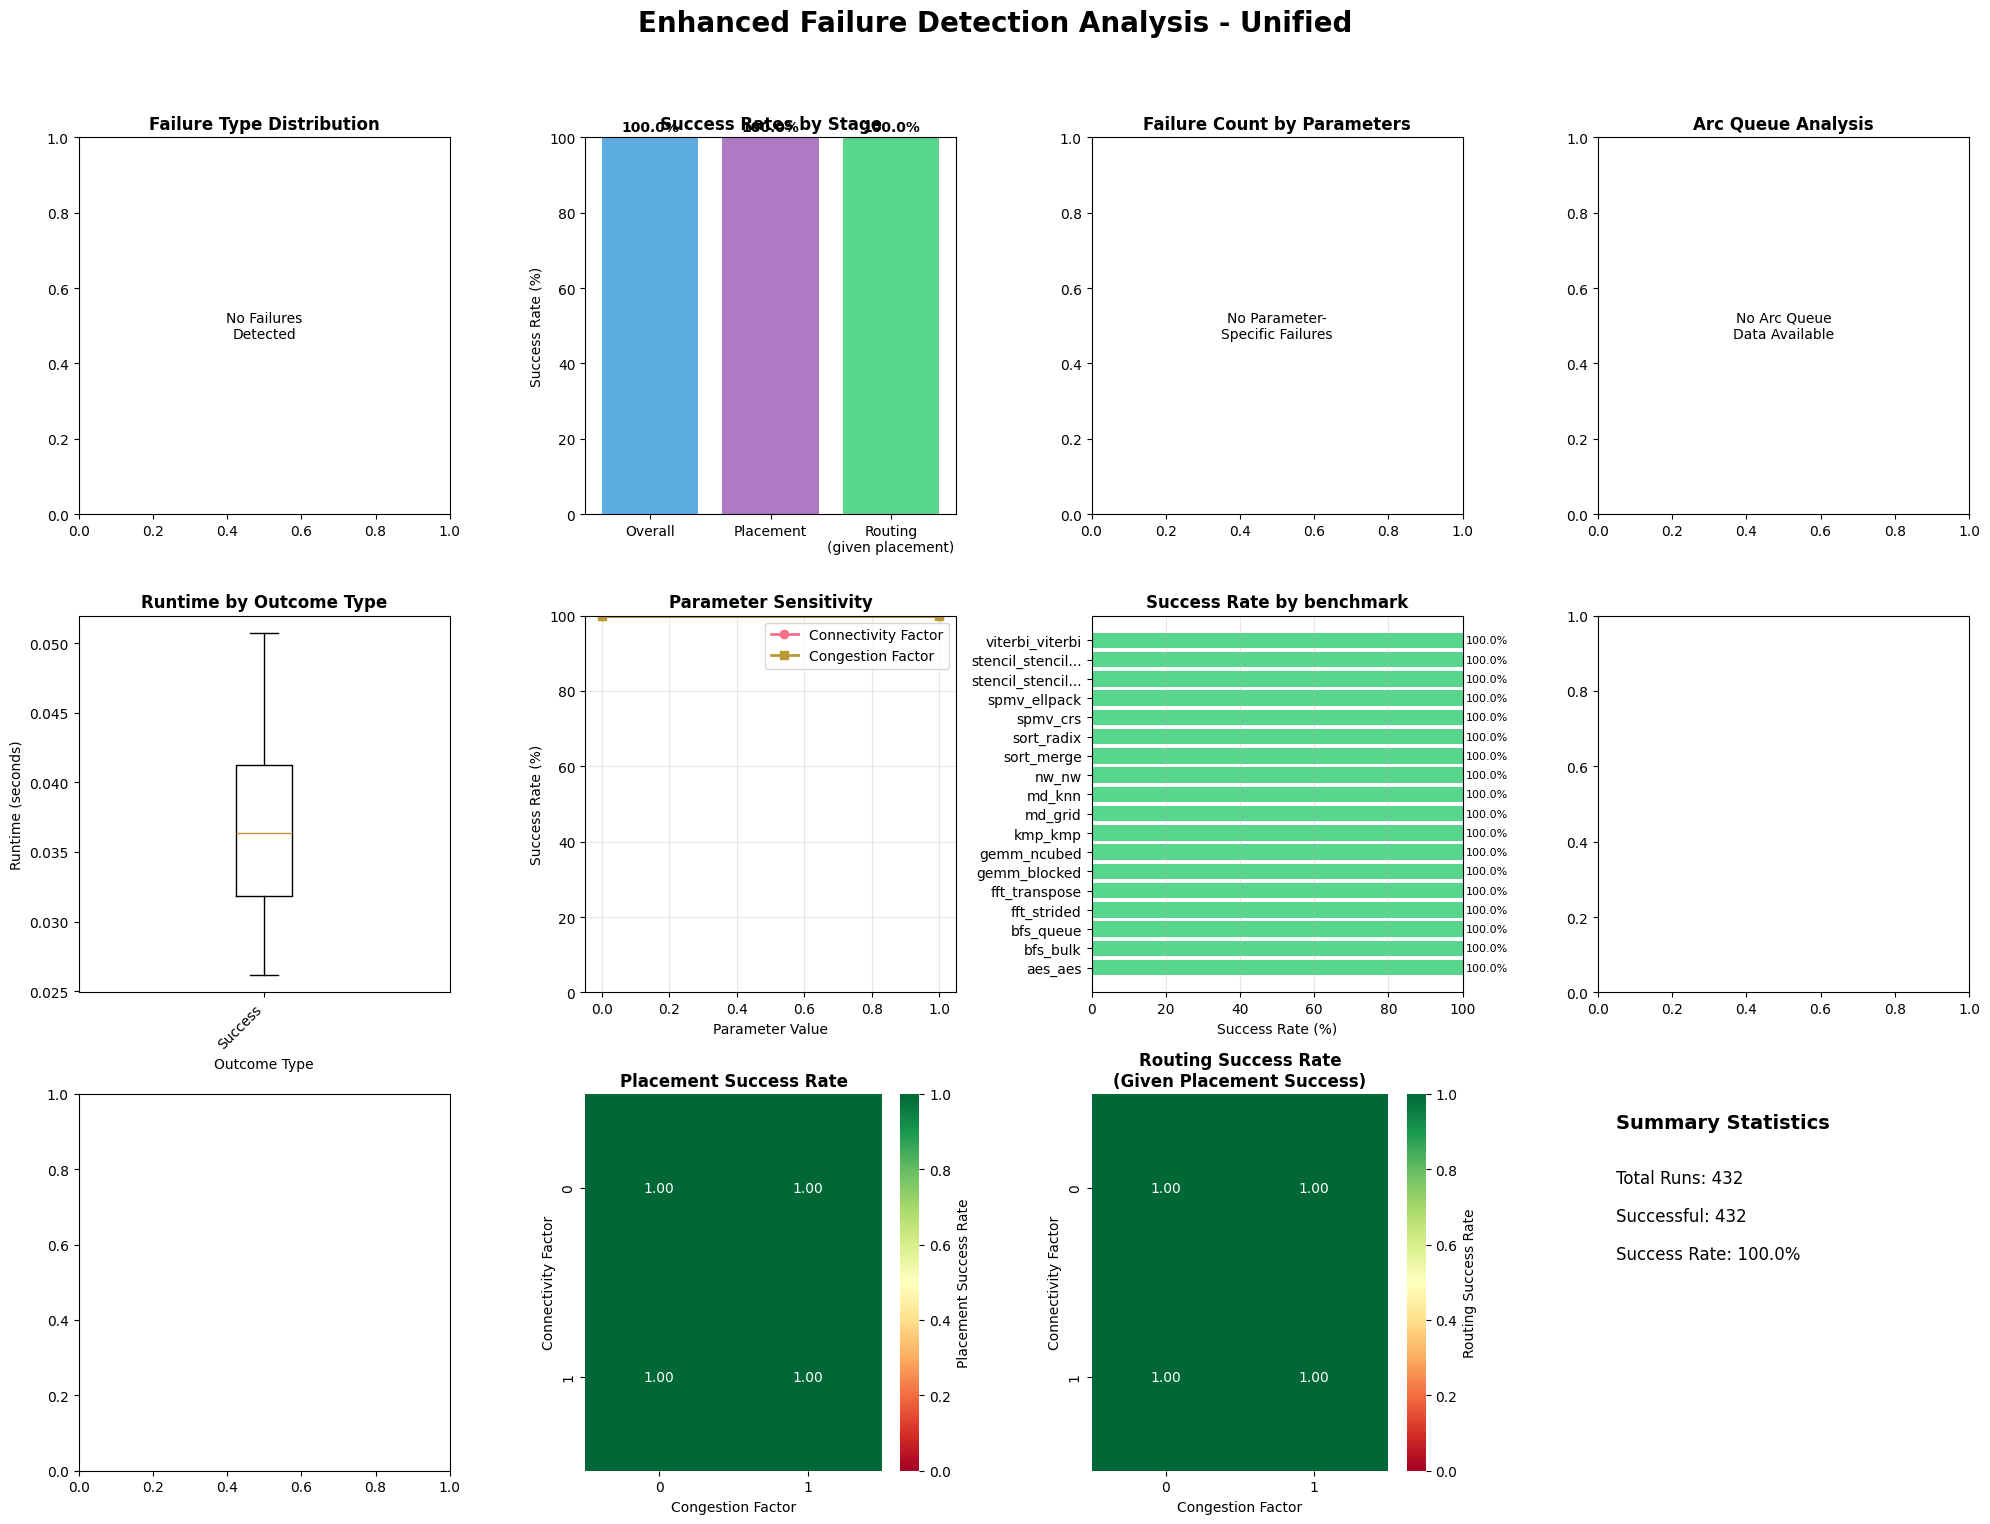

2025-06-20T18:14:19.851976+0100 | INFO | Enhanced failure analysis visualization saved to: /home/kelvin/FABulous_fork/myProject/PnR/results/enhanced_failure_analysis_20250620_181408.png


In [13]:
# Unified Enhanced Failure Detection Visualizations
def generateEnhancedFailureVisualizations(dataFrame: pd.DataFrame) -> None:
    """
    Generate enhanced failure detection visualizations for any data structure.
    
    Parameters
    ----------
    dataFrame : pd.DataFrame
        DataFrame containing the results with failure detection data
    """
    
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np
        
        # Helper function to round to 2 significant figures
        def round_to_2sf(x):
            if x == 0:
                return 0
            from math import log10, floor
            return round(x, -int(floor(log10(abs(x)))) + 1)
        
        if len(dataFrame) == 0 or 'failureType' not in dataFrame.columns:
            logger.info("Enhanced failure detection data not available - skipping enhanced visualizations")
            return
        
        logger.info("Creating enhanced failure detection visualizations...")
        
        # Create a copy with rounded axis values
        dfViz = dataFrame.copy()
        dfViz['connectivityFactor'] = dfViz['connectivityFactor'].apply(round_to_2sf)
        dfViz['congestionFactor'] = dfViz['congestionFactor'].apply(round_to_2sf)
        
        # Set up the plot style
        plt.style.use('default')
        sns.set_palette("husl")
        
        # Create comprehensive failure analysis visualization
        fig = plt.figure(figsize=(20, 16))
        fig.suptitle('Enhanced Failure Detection Analysis - Unified', fontsize=20, fontweight='bold', y=0.98)
        
        # 1. Failure Type Distribution (Pie Chart)
        ax1 = plt.subplot(3, 4, 1)
        failureTypeCounts = dfViz['failureType'].value_counts()
        failureOnly = failureTypeCounts[failureTypeCounts.index != 'none']
        
        if len(failureOnly) > 0:
            colors = ['#e74c3c', '#f39c12', '#9b59b6']  # Red, orange, purple
            labels = []
            for failureType in failureOnly.index:
                if failureType == 'synthesis':
                    labels.append('Synthesis Fail')
                elif failureType == 'placement':
                    labels.append('Placement Fail\n(includes routing)')
                elif failureType == 'routing':
                    labels.append('Routing Fail\n(placement OK)')
                else:
                    labels.append(failureType.title())
            
            ax1.pie(failureOnly.values, labels=labels, autopct='%1.1f%%',
                   colors=colors[:len(failureOnly)], startangle=90)
            ax1.set_title('Failure Type Distribution\n(Failures Only)', fontweight='bold', fontsize=12)
        else:
            ax1.text(0.5, 0.5, 'No Failures\nDetected', ha='center', va='center', transform=ax1.transAxes)
            ax1.set_title('Failure Type Distribution', fontweight='bold', fontsize=12)
        
        # 2. Stage Success Rates (Bar Chart)
        ax2 = plt.subplot(3, 4, 2)
        successRates = {'Overall': dfViz['success'].mean() * 100}
        
        if 'synthesisSuccess' in dfViz.columns:
            successRates['Synthesis'] = dfViz['synthesisSuccess'].mean() * 100
        if 'placementSuccess' in dfViz.columns:
            successRates['Placement'] = dfViz['placementSuccess'].mean() * 100
        if 'routingSuccess' in dfViz.columns and 'placementSuccess' in dfViz.columns:
            placementSuccessfulRuns = dfViz[dfViz['placementSuccess']]
            if len(placementSuccessfulRuns) > 0:
                successRates['Routing\n(given placement)'] = placementSuccessfulRuns['routingSuccess'].mean() * 100
        
        bars = ax2.bar(successRates.keys(), successRates.values(),
                      color=['#3498db', '#9b59b6', '#2ecc71', '#e67e22'], alpha=0.8)
        ax2.set_ylabel('Success Rate (%)')
        ax2.set_title('Success Rates by Stage', fontweight='bold', fontsize=12)
        ax2.set_ylim(0, 100)
        
        # Add value labels on bars
        for bar, value in zip(bars, successRates.values()):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')
        
        # 3. Failure Count Heatmap by Parameters
        ax3 = plt.subplot(3, 4, 3)
        if len(dfViz) > 1 and 'connectivityFactor' in dfViz.columns:
            failureHeatmapData = dfViz[dfViz['failureType'] != 'none'].pivot_table(
                values='success',
                index='connectivityFactor',
                columns='congestionFactor',
                aggfunc=lambda x: len(x)  # Count failures
            )
            
            if not failureHeatmapData.empty:
                sns.heatmap(failureHeatmapData, annot=True, fmt='d', cmap='Reds',
                           cbar_kws={'label': 'Number of Failures'}, ax=ax3)
                ax3.set_title('Failure Count Heatmap', fontweight='bold', fontsize=12)
                ax3.set_xlabel('Congestion Factor')
                ax3.set_ylabel('Connectivity Factor')
            else:
                ax3.text(0.5, 0.5, 'No Parameter-\nSpecific Failures', ha='center', va='center', transform=ax3.transAxes)
                ax3.set_title('Failure Count by Parameters', fontweight='bold', fontsize=12)
        
        # 4. Arc Queue Size Distribution
        ax4 = plt.subplot(3, 4, 4)
        if 'arcQueueSize' in dfViz.columns:
            arcQueueSizes = dfViz['arcQueueSize'].dropna()
            if len(arcQueueSizes) > 0:
                ax4.hist(arcQueueSizes, bins=20, alpha=0.7, color='#3498db', edgecolor='black')
                ax4.set_xlabel('Arc Queue Size')
                ax4.set_ylabel('Frequency')
                ax4.set_title('Arc Queue Size Distribution', fontweight='bold', fontsize=12)
                ax4.axvline(arcQueueSizes.mean(), color='r', linestyle='--',
                           label=f'Mean: {arcQueueSizes.mean():.1f}')
                ax4.legend()
            else:
                ax4.text(0.5, 0.5, 'No Arc Queue\nData Available', ha='center', va='center', transform=ax4.transAxes)
                ax4.set_title('Arc Queue Analysis', fontweight='bold', fontsize=12)
        
        # 5. Runtime vs Failure Type (Box Plot)
        ax5 = plt.subplot(3, 4, 5)
        if len(dfViz) > 1 and 'runtime' in dfViz.columns:
            dfForBoxplot = dfViz[dfViz['runtime'] < dfViz['runtime'].quantile(0.95)]  # Remove outliers
            
            # Prepare data for boxplot
            failureTypes = dfForBoxplot['failureType'].unique()
            runtimeByType = []
            typeLabels = []
            
            for fType in sorted(failureTypes):
                typeData = dfForBoxplot[dfForBoxplot['failureType'] == fType]['runtime']
                if len(typeData) > 0:
                    runtimeByType.append(typeData.values)
                    if fType == 'none':
                        typeLabels.append('Success')
                    elif fType == 'synthesis':
                        typeLabels.append('Synthesis Fail')
                    elif fType == 'placement':
                        typeLabels.append('Placement Fail')
                    elif fType == 'routing':
                        typeLabels.append('Routing Fail')
                    else:
                        typeLabels.append(fType.title())
            
            if runtimeByType:
                ax5.boxplot(runtimeByType, tick_labels=typeLabels)
                ax5.set_title('Runtime by Outcome Type', fontweight='bold', fontsize=12)
                ax5.set_xlabel('Outcome Type')
                ax5.set_ylabel('Runtime (seconds)')
                plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')
            else:
                ax5.text(0.5, 0.5, 'Insufficient Data\nfor Runtime Analysis', ha='center', va='center', transform=ax5.transAxes)
                ax5.set_title('Runtime Analysis', fontweight='bold', fontsize=12)
        
        # 6. Parameter Sensitivity Analysis
        ax6 = plt.subplot(3, 4, 6)
        if len(dfViz) > 1 and 'connectivityFactor' in dfViz.columns:
            connSuccessRates = dfViz.groupby('connectivityFactor')['success'].mean()
            congSuccessRates = dfViz.groupby('congestionFactor')['success'].mean()
            
            ax6.plot(connSuccessRates.index, connSuccessRates.values * 100,
                    'o-', label='Connectivity Factor', linewidth=2, markersize=6)
            ax6.plot(congSuccessRates.index, congSuccessRates.values * 100,
                    's-', label='Congestion Factor', linewidth=2, markersize=6)
            ax6.set_xlabel('Parameter Value')
            ax6.set_ylabel('Success Rate (%)')
            ax6.set_title('Parameter Sensitivity', fontweight='bold', fontsize=12)
            ax6.legend()
            ax6.grid(True, alpha=0.3)
            ax6.set_ylim(0, 100)
        
        # 7. Group-Specific Analysis (if grouping data available)
        ax7 = plt.subplot(3, 4, 7)
        groupingCol = None
        if 'benchmarkName' in dfViz.columns and dfViz['benchmarkName'].nunique() > 1:
            groupingCol = 'benchmarkName'
        elif 'sourceFileName' in dfViz.columns and dfViz['sourceFileName'].nunique() > 1:
            groupingCol = 'sourceFileName'
        
        if groupingCol:
            groupStats = []
            groupNames = []
            for groupValue in sorted(dfViz[groupingCol].unique()):
                groupData = dfViz[dfViz[groupingCol] == groupValue]
                successRate = groupData['success'].mean() * 100
                groupStats.append(successRate)
                displayName = Path(groupValue).stem if 'fileName' in groupingCol else groupValue
                groupNames.append(displayName)
            
            # Sort by success rate
            sortedData = sorted(zip(groupNames, groupStats), key=lambda x: x[1])
            sortedNames, sortedRates = zip(*sortedData) if sortedData else ([], [])
            
            if sortedNames:
                bars = ax7.barh(range(len(sortedNames)), sortedRates,
                               color=['#e74c3c' if rate < 50 else '#f39c12' if rate < 90 else '#2ecc71'
                                     for rate in sortedRates], alpha=0.8)
                ax7.set_yticks(range(len(sortedNames)))
                ax7.set_yticklabels([name[:15] + '...' if len(name) > 15 else name for name in sortedNames])
                ax7.set_xlabel('Success Rate (%)')
                ax7.set_title(f'Success Rate by {groupingCol.replace("Name", "")}', fontweight='bold', fontsize=12)
                ax7.grid(True, alpha=0.3, axis='x')
                ax7.set_xlim(0, 100)
                
                # Add value labels
                for i, (bar, value) in enumerate(zip(bars, sortedRates)):
                    ax7.text(value + 1, bar.get_y() + bar.get_height()/2,
                            f'{value:.1f}%', va='center', ha='left', fontsize=8)
        else:
            # Overall success rate display
            overallSuccess = dfViz['success'].mean() * 100
            ax7.bar(['Overall'], [overallSuccess], color='lightgreen', alpha=0.8)
            ax7.set_ylabel('Success Rate (%)')
            ax7.set_title('Overall Success Rate', fontweight='bold', fontsize=12)
            ax7.set_ylim(0, 100)
            ax7.text(0, overallSuccess + 2, f'{overallSuccess:.1f}%',
                    ha='center', va='bottom', fontweight='bold')
        
        # 8. Success vs Failure Arc Queue Analysis
        ax8 = plt.subplot(3, 4, 8)
        if 'arcQueueSize' in dfViz.columns:
            arcQueueData = dfViz.dropna(subset=['arcQueueSize'])
            if len(arcQueueData) > 0:
                successData = arcQueueData[arcQueueData['success'] == True]
                failureData = arcQueueData[arcQueueData['success'] == False]
                
                data_to_plot = []
                labels = []
                colors = []
                
                if len(successData) > 0:
                    data_to_plot.append(successData['arcQueueSize'])
                    labels.append('Success')
                    colors.append('green')
                
                if len(failureData) > 0:
                    data_to_plot.append(failureData['arcQueueSize'])
                    labels.append('Failure')
                    colors.append('red')
                
                if data_to_plot:
                    ax8.hist(data_to_plot, bins=15, alpha=0.7, label=labels, color=colors)
                    ax8.set_xlabel('Arc Queue Size')
                    ax8.set_ylabel('Frequency')
                    ax8.set_title('Arc Queue Size by Outcome', fontweight='bold', fontsize=12)
                    ax8.legend()
        
        # 9-12: Additional analysis panels
        # 9. Synthesis Error Details (if available)
        ax9 = plt.subplot(3, 4, 9)
        if 'synthesisError' in dfViz.columns and 'failureType' in dfViz.columns:
            synthesisFailures = dfViz[dfViz['failureType'] == 'synthesis']
            if len(synthesisFailures) > 0:
                errorCounts = synthesisFailures['synthesisError'].value_counts().head(5)
                if len(errorCounts) > 0:
                    bars = ax9.barh(range(len(errorCounts)), errorCounts.values, color='#e74c3c', alpha=0.7)
                    ax9.set_yticks(range(len(errorCounts)))
                    ax9.set_yticklabels([str(err)[:20] + '...' if len(str(err)) > 20 else str(err)
                                        for err in errorCounts.index])
                    ax9.set_xlabel('Count')
                    ax9.set_title('Top Synthesis Errors', fontweight='bold', fontsize=12)
                    
                    # Add value labels
                    for bar, value in zip(bars, errorCounts.values):
                        ax9.text(value + 0.1, bar.get_y() + bar.get_height()/2,
                                f'{value}', va='center', ha='left')
        
        # Fill remaining subplots with parameter combination analysis
        for idx, subplot_num in enumerate([10, 11, 12]):
            ax = plt.subplot(3, 4, subplot_num)
            
            if idx == 0 and 'placementSuccess' in dfViz.columns:
                # Placement success heatmap
                if len(dfViz) > 1:
                    placementHeatmap = dfViz.pivot_table(
                        values='placementSuccess',
                        index='connectivityFactor',
                        columns='congestionFactor',
                        aggfunc='mean'
                    )
                    
                    if not placementHeatmap.empty:
                        sns.heatmap(placementHeatmap, annot=True, fmt='.2f', cmap='RdYlGn',
                                   vmin=0, vmax=1, cbar_kws={'label': 'Placement Success Rate'}, ax=ax)
                        ax.set_title('Placement Success Rate', fontweight='bold', fontsize=12)
                        ax.set_xlabel('Congestion Factor')
                        ax.set_ylabel('Connectivity Factor')
            
            elif idx == 1 and 'routingSuccess' in dfViz.columns:
                # Routing success heatmap (given placement success)
                placementSuccessfulRuns = dfViz[dfViz['placementSuccess'] == True]
                if len(placementSuccessfulRuns) > 1:
                    routingHeatmap = placementSuccessfulRuns.pivot_table(
                        values='routingSuccess',
                        index='connectivityFactor',
                        columns='congestionFactor',
                        aggfunc='mean'
                    )
                    
                    if not routingHeatmap.empty:
                        sns.heatmap(routingHeatmap, annot=True, fmt='.2f', cmap='RdYlGn',
                                   vmin=0, vmax=1, cbar_kws={'label': 'Routing Success Rate'}, ax=ax)
                        ax.set_title('Routing Success Rate\n(Given Placement Success)', fontweight='bold', fontsize=12)
                        ax.set_xlabel('Congestion Factor')
                        ax.set_ylabel('Connectivity Factor')
            
            else:
                # Summary statistics
                totalRuns = len(dfViz)
                successfulRuns = dfViz['success'].sum()
                failureBreakdown = dfViz['failureType'].value_counts()
                
                ax.text(0.05, 0.95, 'Summary Statistics', fontsize=14, fontweight='bold',
                       transform=ax.transAxes, va='top')
                ax.text(0.05, 0.80, f'Total Runs: {totalRuns}', fontsize=12, transform=ax.transAxes, va='top')
                ax.text(0.05, 0.70, f'Successful: {successfulRuns}', fontsize=12, transform=ax.transAxes, va='top')
                ax.text(0.05, 0.60, f'Success Rate: {successfulRuns/totalRuns*100:.1f}%', fontsize=12, 
                       transform=ax.transAxes, va='top')
                
                yPos = 0.45
                for failureType, count in failureBreakdown.items():
                    if failureType != 'none':
                        emoji = "🔧" if failureType == "synthesis" else "📍" if failureType == "placement" else "🔀"
                        ax.text(0.05, yPos, f'{emoji} {failureType.title()}: {count}', fontsize=10,
                               transform=ax.transAxes, va='top')
                        yPos -= 0.10
                
                ax.set_xlim(0, 1)
                ax.set_ylim(0, 1)
                ax.axis('off')
        
        # Adjust layout and save
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # Save enhanced analysis plot
        enhancedPlotFile = OUTPUT_DIR / f"enhanced_failure_analysis_{timestamp}.png"
        plt.savefig(enhancedPlotFile, dpi=300, bbox_inches="tight")
        plt.show()
        
        logger.info(f"Enhanced failure analysis visualization saved to: {enhancedPlotFile}")
        
    except ImportError:
        logger.info("matplotlib/seaborn not available for enhanced visualizations.")
    except Exception as e:
        logger.error(f"Error creating enhanced visualizations: {e}")

# Generate enhanced failure visualizations
if len(df) > 0:
    generateEnhancedFailureVisualizations(df)
else:
    logger.warning("No data available for enhanced failure visualization")

## 7. Interactive Dashboard

Interactive dashboard for exploring results across different Verilog files with combined analysis and file-specific views.

In [14]:
# Unified Interactive Dashboard for Parameter Sweep Results
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from pathlib import Path
    
    def createUnifiedInteractiveDashboard(dataFrame: pd.DataFrame) -> None:
        """
        Create a unified interactive dashboard that works for any data structure.
        
        Parameters
        ----------
        dataFrame : pd.DataFrame
            DataFrame containing the results to analyze
        """
        
        if len(dataFrame) == 0:
            print("No data available for dashboard. Please run the parameter sweep first.")
            return
        
        logger.info("Creating unified interactive dashboard...")
        
        # Prepare data
        dfCombined = dataFrame.copy()
        dfCombined["connectivityFactor"] = dfCombined["connectivityFactor"].round(2)
        dfCombined["congestionFactor"] = dfCombined["congestionFactor"].round(2)
        
        # Calculate combined summary statistics
        combinedStats = {
            "totalRuns": len(dfCombined),
            "successfulRuns": dfCombined["success"].sum(),
            "successRate": dfCombined["success"].mean() * 100,
            "avgRuntime": dfCombined[dfCombined["success"]]["runtime"].mean() if dfCombined["success"].any() else 0,
            "totalFailures": len(dfCombined) - dfCombined["success"].sum()
        }
        
        # Determine available grouping options
        fileOptions = ["All Data (Combined)"]
        groupingCol = None
        
        # Check for benchmark structure
        if 'benchmarkName' in dfCombined.columns and dfCombined['benchmarkName'].nunique() > 1:
            groupingCol = 'benchmarkName'
            combinedStats["uniqueGroups"] = dfCombined['benchmarkName'].nunique()
            fileOptions.extend([f"Benchmark: {name}" for name in sorted(dfCombined['benchmarkName'].unique())])
        # Check for multiple source files
        elif 'sourceFileName' in dfCombined.columns and dfCombined['sourceFileName'].nunique() > 1:
            groupingCol = 'sourceFileName'
            combinedStats["uniqueGroups"] = dfCombined['sourceFileName'].nunique()
            fileOptions.extend([f"File: {Path(name).stem}" for name in sorted(dfCombined['sourceFileName'].unique())])
        else:
            combinedStats["uniqueGroups"] = 1
        
        # Create widgets
        fileSelector = widgets.Dropdown(
            options=fileOptions,
            value="All Data (Combined)",
            description="Select Group:",
            style={"description_width": "initial"}
        )
        
        vizOptions = [
            "Summary Statistics",
            "Success Rate Heatmap",
            "Runtime Heatmap",
            "Failure Analysis",
            "Parameter Sensitivity",
            "Detailed Data Table"
        ]
        
        vizSelector = widgets.Dropdown(
            options=vizOptions,
            value="Summary Statistics",
            description="View Type:",
            style={"description_width": "initial"}
        )
        
        # Output widget for displaying results
        outputWidget = widgets.Output()
        
        def updateDashboard(change=None):
            """Update the dashboard based on current selections"""
            with outputWidget:
                clear_output(wait=True)
                
                selectedFile = fileSelector.value
                selectedViz = vizSelector.value
                
                # Filter data based on selection
                if selectedFile == "All Data (Combined)":
                    filteredData = dfCombined.copy()
                    titlePrefix = "All Data Combined"
                else:
                    # Parse the selection to get the actual value
                    if selectedFile.startswith("Benchmark: "):
                        groupValue = selectedFile.replace("Benchmark: ", "")
                        filteredData = dfCombined[dfCombined['benchmarkName'] == groupValue].copy()
                        titlePrefix = f"Benchmark: {groupValue}"
                    elif selectedFile.startswith("File: "):
                        displayName = selectedFile.replace("File: ", "")
                        # Find the actual filename that matches this display name
                        actualFileName = None
                        for fileName in dfCombined['sourceFileName'].unique():
                            if Path(fileName).stem == displayName:
                                actualFileName = fileName
                                break
                        if actualFileName:
                            filteredData = dfCombined[dfCombined['sourceFileName'] == actualFileName].copy()
                            titlePrefix = f"File: {displayName}"
                        else:
                            print(f"Could not find file matching: {displayName}")
                            return
                    else:
                        filteredData = dfCombined.copy()
                        titlePrefix = "Unknown Selection"
                
                if len(filteredData) == 0:
                    print(f"No data available for {selectedFile}")
                    return
                
                # Display selected visualization
                try:
                    if selectedViz == "Summary Statistics":
                        displaySummaryStats(filteredData, titlePrefix)
                    elif selectedViz == "Success Rate Heatmap":
                        displaySuccessHeatmap(filteredData, titlePrefix)
                    elif selectedViz == "Runtime Heatmap":
                        displayRuntimeHeatmap(filteredData, titlePrefix)
                    elif selectedViz == "Failure Analysis":
                        displayFailureAnalysis(filteredData, titlePrefix)
                    elif selectedViz == "Parameter Sensitivity":
                        displayParameterSensitivity(filteredData, titlePrefix)
                    elif selectedViz == "Detailed Data Table":
                        displayDataTable(filteredData, titlePrefix)
                except Exception as e:
                    print(f"Error displaying {selectedViz}: {e}")
        
        def displaySummaryStats(data, titlePrefix):
            """Display summary statistics"""
            print(f"=== {titlePrefix} - Summary Statistics ===\n")
            
            successCount = data["success"].sum()
            totalCount = len(data)
            successRate = (successCount / totalCount * 100) if totalCount > 0 else 0
            
            print(f"📊 Total Runs: {totalCount}")
            print(f"✅ Successful Runs: {successCount}")
            print(f"📈 Success Rate: {successRate:.1f}%")
            
            if successCount > 0:
                avgRuntime = data[data["success"]]["runtime"].mean()
                print(f"⏱️ Average Runtime (successful): {avgRuntime:.2f}s")
            
            # Stage-by-stage success rates
            if "synthesisSuccess" in data.columns:
                synthesisRate = data["synthesisSuccess"].mean() * 100
                print(f"\n--- Stage Success Rates ---")
                print(f"🔧 Synthesis: {synthesisRate:.1f}%")
                
                if "placementSuccess" in data.columns:
                    placementRate = data["placementSuccess"].mean() * 100
                    print(f"📍 Placement: {placementRate:.1f}%")
                    
                if "routingSuccess" in data.columns:
                    routingRate = data["routingSuccess"].mean() * 100
                    print(f"🔀 Routing: {routingRate:.1f}%")
            
            # Failure breakdown if available
            if "failureType" in data.columns:
                print(f"\n--- Failure Analysis ---")
                failureCounts = data["failureType"].value_counts()
                for failureType, count in failureCounts.items():
                    if failureType != "none":
                        percentage = (count / totalCount) * 100
                        emoji = "🔧" if failureType == "synthesis" else "📍" if failureType == "placement" else "🔀" if failureType == "routing" else "❓"
                        print(f"{emoji} {failureType.title()} Failures: {count} ({percentage:.1f}%)")
                
                # Show synthesis error details if available
                if "synthesisError" in data.columns:
                    synthesisFailures = data[data["failureType"] == "synthesis"]
                    if len(synthesisFailures) > 0:
                        print(f"\n--- Common Synthesis Errors ---")
                        errorCounts = synthesisFailures["synthesisError"].value_counts().head(3)
                        for error, count in errorCounts.items():
                            if error and str(error) != "nan":
                                shortError = str(error)[:60] + "..." if len(str(error)) > 60 else str(error)
                                print(f"   {count}x: {shortError}")
            
            # Parameter performance
            print(f"\n--- Parameter Performance ---")
            if len(data) > 1:
                connSuccess = data.groupby("connectivityFactor")["success"].mean()
                congSuccess = data.groupby("congestionFactor")["success"].mean()
                
                if len(connSuccess) > 0:
                    bestConn = connSuccess.idxmax()
                    print(f"🎯 Best Connectivity Factor: {bestConn} ({connSuccess[bestConn]*100:.1f}% success)")
                if len(congSuccess) > 0:
                    bestCong = congSuccess.idxmax()
                    print(f"🎯 Best Congestion Factor: {bestCong} ({congSuccess[bestCong]*100:.1f}% success)")
            
            # Arc queue statistics if available
            if "arcQueueSize" in data.columns:
                arcSizes = data["arcQueueSize"].dropna()
                if len(arcSizes) > 0:
                    print(f"\n--- Arc Queue Statistics ---")
                    print(f"📏 Average Arc Queue Size: {arcSizes.mean():.1f}")
                    print(f"📏 Arc Queue Range: {arcSizes.min()} - {arcSizes.max()}")
        
        def displaySuccessHeatmap(data, titlePrefix):
            """Display success rate heatmap"""
            if len(data) <= 1:
                print(f"Not enough data for heatmap visualization")
                return
                
            plt.figure(figsize=(10, 6))
            
            try:
                successPivot = data.pivot_table(
                    values="success",
                    index="connectivityFactor",
                    columns="congestionFactor",
                    aggfunc="mean"
                )
                
                if not successPivot.empty:
                    sns.heatmap(successPivot, annot=True, fmt=".2f", cmap="RdYlGn",
                               vmin=0, vmax=1, cbar_kws={"label": "Success Rate"})
                    plt.title(f"{titlePrefix} - Success Rate Heatmap")
                    plt.ylabel("Connectivity Factor")
                    plt.xlabel("Congestion Factor")
                    plt.tight_layout()
                    plt.show()
                else:
                    print("No data available for success heatmap")
            except Exception as e:
                print(f"Error creating success heatmap: {e}")
        
        def displayRuntimeHeatmap(data, titlePrefix):
            """Display runtime heatmap"""
            successfulData = data[data["success"]]
            
            if len(successfulData) <= 1:
                print(f"Not enough successful runs for runtime heatmap")
                return
                
            plt.figure(figsize=(10, 6))
            
            try:
                runtimePivot = successfulData.pivot_table(
                    values="runtime",
                    index="connectivityFactor",
                    columns="congestionFactor",
                    aggfunc="mean"
                )
                
                if not runtimePivot.empty:
                    sns.heatmap(runtimePivot, annot=True, fmt=".2f", cmap="viridis",
                               cbar_kws={"label": "Runtime (seconds)"})
                    plt.title(f"{titlePrefix} - Runtime Heatmap (Successful Runs)")
                    plt.ylabel("Connectivity Factor")
                    plt.xlabel("Congestion Factor")
                    plt.tight_layout()
                    plt.show()
                else:
                    print("No successful runs available for runtime heatmap")
            except Exception as e:
                print(f"Error creating runtime heatmap: {e}")
        
        def displayFailureAnalysis(data, titlePrefix):
            """Display failure analysis charts"""
            if "failureType" not in data.columns:
                print("Failure type data not available")
                return
                
            plt.figure(figsize=(15, 10))
            
            try:
                # Failure type distribution
                plt.subplot(2, 3, 1)
                failureCounts = data["failureType"].value_counts()
                failureOnly = failureCounts[failureCounts.index != "none"]
                
                if len(failureOnly) > 0:
                    colors = ["#e74c3c", "#f39c12", "#9b59b6"]
                    labels = []
                    for failureType in failureOnly.index:
                        if failureType == "synthesis":
                            labels.append("Synthesis Fail")
                        elif failureType == "placement":
                            labels.append("Placement Fail")
                        elif failureType == "routing":
                            labels.append("Routing Fail")
                        else:
                            labels.append(failureType.title())
                    
                    plt.pie(failureOnly.values, labels=labels, autopct="%1.1f%%",
                           colors=colors[:len(failureOnly)])
                    plt.title("Failure Type Distribution")
                
                # Success rates comparison
                plt.subplot(2, 3, 2)
                successRates = {"Overall": data["success"].mean() * 100}
                
                if "synthesisSuccess" in data.columns:
                    successRates["Synthesis"] = data["synthesisSuccess"].mean() * 100
                if "placementSuccess" in data.columns:
                    successRates["Placement"] = data["placementSuccess"].mean() * 100
                if "routingSuccess" in data.columns and "placementSuccess" in data.columns:
                    routingData = data[data["placementSuccess"]]
                    if len(routingData) > 0:
                        successRates["Routing"] = routingData["routingSuccess"].mean() * 100
                
                bars = plt.bar(successRates.keys(), successRates.values(),
                              color=["#3498db", "#9b59b6", "#2ecc71", "#e67e22"])
                plt.ylabel("Success Rate (%)")
                plt.title("Success Rates by Stage")
                plt.ylim(0, 100)
                
                # Add value labels
                for bar, value in zip(bars, successRates.values()):
                    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                            f"{value:.1f}%", ha="center", va="bottom")
                
                # Additional analysis subplots can be added here
                plt.suptitle(f"{titlePrefix} - Failure Analysis", fontsize=16, fontweight="bold")
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Error creating failure analysis: {e}")
        
        def displayParameterSensitivity(data, titlePrefix):
            """Display parameter sensitivity analysis"""
            if len(data) <= 1:
                print("Not enough data for parameter sensitivity analysis")
                return
                
            plt.figure(figsize=(12, 8))
            
            try:
                # Success rate by parameter values
                plt.subplot(2, 2, 1)
                connSuccess = data.groupby("connectivityFactor")["success"].mean()
                congSuccess = data.groupby("congestionFactor")["success"].mean()
                
                plt.plot(connSuccess.index, connSuccess.values * 100, "o-",
                        label="Connectivity Factor", linewidth=2, markersize=8)
                plt.plot(congSuccess.index, congSuccess.values * 100, "s-",
                        label="Congestion Factor", linewidth=2, markersize=8)
                plt.xlabel("Parameter Value")
                plt.ylabel("Success Rate (%)")
                plt.title("Success Rate by Parameter")
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.ylim(0, 100)
                
                plt.suptitle(f"{titlePrefix} - Parameter Sensitivity Analysis", fontsize=16, fontweight="bold")
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Error creating parameter sensitivity analysis: {e}")
        
        def displayDataTable(data, titlePrefix):
            """Display detailed data table"""
            print(f"=== {titlePrefix} - Detailed Data Table ===\n")
            
            # Select key columns for display
            displayCols = ["connectivityFactor", "congestionFactor", "success", "runtime"]
            
            if "failureType" in data.columns:
                displayCols.append("failureType")
            if "placementSuccess" in data.columns:
                displayCols.append("placementSuccess")
            if "routingSuccess" in data.columns:
                displayCols.append("routingSuccess")
            if "arcQueueSize" in data.columns:
                displayCols.append("arcQueueSize")
            
            # Filter to existing columns
            availableCols = [col for col in displayCols if col in data.columns]
            
            # Display sample data
            print(f"Showing first 20 rows (Total: {len(data)} rows)\n")
            sampleData = data[availableCols].head(20).copy()
            
            # Format the data for better display
            if "runtime" in sampleData.columns:
                sampleData["runtime"] = sampleData["runtime"].round(2)
            if "arcQueueSize" in sampleData.columns:
                sampleData["arcQueueSize"] = sampleData["arcQueueSize"].fillna(0).astype(int)
            
            print(sampleData.to_string(index=False))
            
            # Show summary statistics
            print(f"\n--- Summary Statistics ---")
            print(f"Total Rows: {len(data)}")
            print(f"Unique Parameter Combinations: {len(data.groupby(['connectivityFactor', 'congestionFactor']))}")
        
        # Set up interactive callbacks
        fileSelector.observe(updateDashboard, names="value")
        vizSelector.observe(updateDashboard, names="value")
        
        # Display the dashboard
        print("=== Unified Interactive Parameter Sweep Dashboard ===\n")
        
        # Show combined statistics first
        print("📊 Combined Statistics:")
        print(f"   Total Runs: {combinedStats['totalRuns']}")
        print(f"   Successful Runs: {combinedStats['successfulRuns']}")
        print(f"   Success Rate: {combinedStats['successRate']:.1f}%")
        if groupingCol:
            groupType = "Benchmarks" if "benchmark" in groupingCol.lower() else "Files"
            print(f"   Unique {groupType}: {combinedStats['uniqueGroups']}")
        if combinedStats['successfulRuns'] > 0:
            print(f"   Avg Runtime: {combinedStats['avgRuntime']:.2f}s")
        print()
        
        # Display the interactive controls
        controlsBox = widgets.HBox([fileSelector, vizSelector])
        display(controlsBox)
        display(outputWidget)
        
        # Initialize with default view
        updateDashboard()
        
        logger.info("Unified interactive dashboard created successfully!")
    
    # Create the unified dashboard
    if len(df) > 0:
        createUnifiedInteractiveDashboard(df)
    else:
        print("No data available for dashboard. Please run the parameter sweep first.")
        
except ImportError as e:
    print(f"Required packages not available for interactive dashboard: {e}")
    print("To enable the interactive dashboard, install:")
    print("pip install ipywidgets")
    print("And enable the extension:")
    print("jupyter nbextension enable --py widgetsnbextension")
    
except Exception as e:
    print(f"Error creating interactive dashboard: {e}")
    import traceback
    traceback.print_exc()

2025-06-20T18:14:19.876996+0100 | INFO | Creating unified interactive dashboard...
=== Unified Interactive Parameter Sweep Dashboard ===

📊 Combined Statistics:
   Total Runs: 432
   Successful Runs: 432
   Success Rate: 100.0%
   Unique Benchmarks: 18
   Avg Runtime: 0.04s



Output()

2025-06-20T18:14:19.882295+0100 | INFO | Unified interactive dashboard created successfully!


📊 UNIFIED PARAMETER SWEEP RESULTS DASHBOARD

🎯 OVERALL RESULTS
   Total Parameter Combinations: 432
   Successful Runs: 432
   Overall Success Rate: 100.0%
   Average Runtime (successful): 0.04s

📁 BENCHMARKS BREAKDOWN (18 items)
--------------------------------------------------
 1. aes_aes                   │  48/ 48 │ 100.0%
    └─ Loop0                │   8/  8 │ 100.0%
    └─ Loop1                │   8/  8 │ 100.0%
    └─ Loop2                │   8/  8 │ 100.0%
    └─ Loop3                │   8/  8 │ 100.0%
    └─ Loop4                │   8/  8 │ 100.0%
    └─ Loop5                │   8/  8 │ 100.0%
 2. bfs_bulk                  │  16/ 16 │ 100.0%
 3. bfs_queue                 │  16/ 16 │ 100.0%
 4. fft_strided               │  16/ 16 │ 100.0%
 5. fft_transpose             │  48/ 48 │ 100.0%
    └─ Loop0                │   8/  8 │ 100.0%
    └─ Loop1                │   8/  8 │ 100.0%
    └─ Loop2                │   8/  8 │ 100.0%
    └─ Loop3                │   8/  8 │ 100.0%
    

/home/kelvin/FABulous_fork/.venv/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipykernel_452192/1612079815.py:295: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/kelvin/FABulous_fork/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


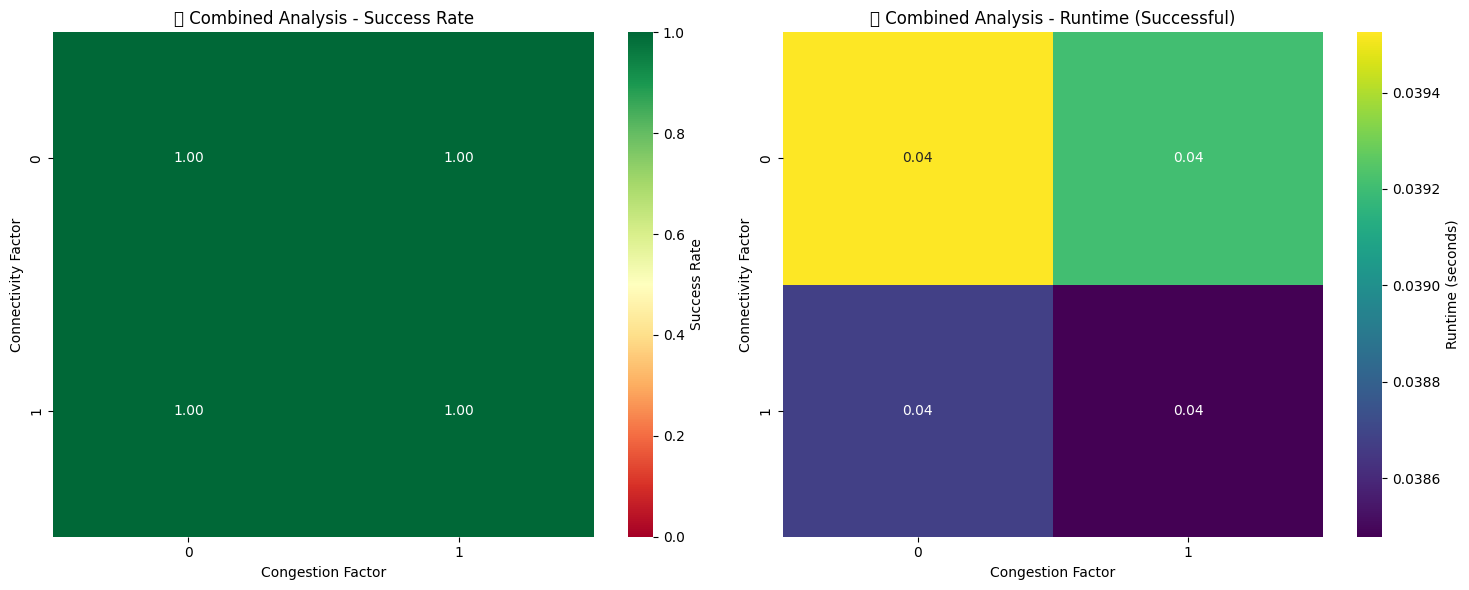


💡 To view details for individual benchmarks, run:
# Choose any of these benchmarks:
# 1. showUnifiedGroupDetails(dashboardData, 'aes_aes', 'benchmarkName')  # aes_aes
# 2. showUnifiedGroupDetails(dashboardData, 'bfs_bulk', 'benchmarkName')  # bfs_bulk
# 3. showUnifiedGroupDetails(dashboardData, 'bfs_queue', 'benchmarkName')  # bfs_queue
# 4. showUnifiedGroupDetails(dashboardData, 'fft_strided', 'benchmarkName')  # fft_strided
# 5. showUnifiedGroupDetails(dashboardData, 'fft_transpose', 'benchmarkName')  # fft_transpose
# 6. showUnifiedGroupDetails(dashboardData, 'gemm_blocked', 'benchmarkName')  # gemm_blocked
# 7. showUnifiedGroupDetails(dashboardData, 'gemm_ncubed', 'benchmarkName')  # gemm_ncubed
# 8. showUnifiedGroupDetails(dashboardData, 'kmp_kmp', 'benchmarkName')  # kmp_kmp
# 9. showUnifiedGroupDetails(dashboardData, 'md_grid', 'benchmarkName')  # md_grid
# 10. showUnifiedGroupDetails(dashboardData, 'md_knn', 'benchmarkName')  # md_knn
# 11. showUnifiedGroupDetails(dashboardDat

In [15]:
# Unified Simplified Dashboard (No External Dependencies)
def createUnifiedSimpleDashboard(dataFrame: pd.DataFrame):
    """
    Create a unified simple text-based dashboard that works for any data structure.
    
    Parameters
    ----------
    dataFrame : pd.DataFrame
        DataFrame containing the results to analyze
        
    Returns
    -------
    tuple
        (processed_dataframe, available_groups) for further analysis
    """
    
    if len(dataFrame) == 0:
        print("No data available for dashboard. Please run the parameter sweep first.")
        return pd.DataFrame(), []
    
    print("="*60)
    print("📊 UNIFIED PARAMETER SWEEP RESULTS DASHBOARD")
    print("="*60)
    
    # Prepare data
    dfRounded = dataFrame.copy()
    dfRounded["connectivityFactor"] = dfRounded["connectivityFactor"].round(2)
    dfRounded["congestionFactor"] = dfRounded["congestionFactor"].round(2)
    
    # Calculate overall statistics
    totalRuns = len(dfRounded)
    successfulRuns = dfRounded["success"].sum()
    successRate = (successfulRuns / totalRuns * 100) if totalRuns > 0 else 0
    
    print(f"\n🎯 OVERALL RESULTS")
    print(f"   Total Parameter Combinations: {totalRuns}")
    print(f"   Successful Runs: {successfulRuns}")
    print(f"   Overall Success Rate: {successRate:.1f}%")
    
    if successfulRuns > 0:
        avgRuntime = dfRounded[dfRounded["success"]]["runtime"].mean()
        print(f"   Average Runtime (successful): {avgRuntime:.2f}s")
    
    # Determine grouping structure and display breakdown
    groupingCol = None
    availableGroups = []
    
    # Check for benchmark structure
    if 'benchmarkName' in dfRounded.columns and dfRounded['benchmarkName'].nunique() > 1:
        groupingCol = 'benchmarkName'
        availableGroups = sorted(dfRounded['benchmarkName'].unique())
        groupType = "BENCHMARKS"
        displayFunc = lambda x: x  # Benchmark names are already clean
        
    # Check for multiple source files
    elif 'sourceFileName' in dfRounded.columns and dfRounded['sourceFileName'].nunique() > 1:
        groupingCol = 'sourceFileName'
        availableGroups = sorted(dfRounded['sourceFileName'].unique())
        groupType = "FILES"
        displayFunc = lambda x: Path(x).stem  # Clean up file paths
    
    # Display group breakdown if available
    if groupingCol and availableGroups:
        print(f"\n📁 {groupType} BREAKDOWN ({len(availableGroups)} items)")
        print("-" * 50)
        
        for i, groupValue in enumerate(availableGroups, 1):
            groupData = dfRounded[dfRounded[groupingCol] == groupValue]
            groupSuccessful = groupData["success"].sum()
            groupTotal = len(groupData)
            groupSuccessRate = (groupSuccessful / groupTotal * 100) if groupTotal > 0 else 0
            
            displayName = displayFunc(groupValue)
            print(f"{i:2d}. {displayName:<25} │ {groupSuccessful:3d}/{groupTotal:3d} │ {groupSuccessRate:5.1f}%")
            
            # Show sub-level breakdown for benchmarks (if loop data available)
            if groupingCol == 'benchmarkName' and 'loopName' in dfRounded.columns:
                loopData = groupData['loopName'].unique()
                if len(loopData) > 1:
                    for loopName in sorted(loopData):
                        loopResults = groupData[groupData['loopName'] == loopName]
                        loopSuccess = loopResults['success'].sum()
                        loopTotal = len(loopResults)
                        loopRate = (loopSuccess / loopTotal * 100) if loopTotal > 0 else 0
                        print(f"    └─ {loopName:<20} │ {loopSuccess:3d}/{loopTotal:3d} │ {loopRate:5.1f}%")
    
    # Best parameter combinations overall
    print(f"\n🏆 TOP PERFORMING PARAMETER COMBINATIONS")
    print("-" * 50)
    
    if len(dfRounded) > 1:
        paramSuccess = dfRounded.groupby(["connectivityFactor", "congestionFactor"]).agg({
            "success": ["sum", "count", "mean"],
            "runtime": "mean"
        }).round(3)
        
        paramSuccess.columns = ["successful", "total", "successRate", "avgRuntime"]
        paramSuccess = paramSuccess.sort_values("successRate", ascending=False)
        
        topParams = paramSuccess.head(5)
        for i, ((conn, cong), stats) in enumerate(topParams.iterrows(), 1):
            successPct = stats["successRate"] * 100
            runtime = stats["avgRuntime"] if not pd.isna(stats["avgRuntime"]) else 0
            print(f"{i}. Conn={conn:4.2f}, Cong={cong:4.2f} │ {stats['successful']:3.0f}/{stats['total']:3.0f} │ {successPct:5.1f}% │ {runtime:6.2f}s")
    else:
        print("   Insufficient data for parameter combination analysis")
    
    # Unified failure analysis
    if "failureType" in dfRounded.columns:
        print(f"\n❌ FAILURE ANALYSIS")
        print("-" * 50)
        
        failureCounts = dfRounded["failureType"].value_counts()
        for failureType, count in failureCounts.items():
            percentage = (count / totalRuns) * 100
            if failureType == "none":
                print(f"✅ Success: {count:3d} ({percentage:5.1f}%)")
            elif failureType == "synthesis":
                print(f"🔧 Synthesis Failures: {count:3d} ({percentage:5.1f}%)")
            elif failureType == "placement":
                print(f"📍 Placement Failures: {count:3d} ({percentage:5.1f}%)")
            elif failureType == "routing":
                print(f"🔀 Routing Failures: {count:3d} ({percentage:5.1f}%)")
            else:
                print(f"❓ {failureType.title()} Failures: {count:3d} ({percentage:5.1f}%)")
        
        # Show synthesis error details if available
        if "synthesisError" in dfRounded.columns:
            synthesisFailures = dfRounded[dfRounded["failureType"] == "synthesis"]
            if len(synthesisFailures) > 0:
                print(f"\n🔧 SYNTHESIS ERROR DETAILS")
                print("-" * 50)
                errorCounts = synthesisFailures["synthesisError"].value_counts()
                for error, count in errorCounts.head(5).items():
                    if error and str(error) != "nan":
                        print(f"   {count:2d}x: {error}")
                
                # Show which groups had synthesis failures
                if groupingCol:
                    print(f"\n📁 {groupType} WITH SYNTHESIS FAILURES")
                    print("-" * 50)
                    groupFailureCounts = synthesisFailures[groupingCol].value_counts()
                    for groupValue, count in groupFailureCounts.items():
                        displayName = displayFunc(groupValue)
                        totalForGroup = len(dfRounded[dfRounded[groupingCol] == groupValue])
                        percentage = (count / totalForGroup) * 100
                        print(f"   {displayName}: {count}/{totalForGroup} ({percentage:.1f}%)")
    
    print("\n" + "="*60)
    
    return dfRounded, availableGroups

def showUnifiedGroupDetails(dfRounded: pd.DataFrame, groupValue: str = None, groupingCol: str = None):
    """
    Show detailed analysis for a specific group or combined view.
    
    Parameters
    ----------
    dfRounded : pd.DataFrame
        Processed DataFrame with rounded values
    groupValue : str, optional
        Specific group value to analyze
    groupingCol : str, optional
        Column name for grouping (benchmarkName or sourceFileName)
    """
    
    if groupValue and groupValue != "combined" and groupingCol:
        groupData = dfRounded[dfRounded[groupingCol] == groupValue].copy()
        if 'fileName' in groupingCol:
            title = f"📁 {Path(groupValue).stem}"
        else:
            title = f"🎯 {groupValue}"
    else:
        groupData = dfRounded.copy()
        title = "📊 Combined Analysis"
    
    if len(groupData) == 0:
        print(f"No data found for {groupValue}")
        return
    
    print(f"\n{title}")
    print("=" * 60)
    
    # Basic statistics
    successCount = groupData["success"].sum()
    totalCount = len(groupData)
    successRate = (successCount / totalCount * 100) if totalCount > 0 else 0
    
    print(f"Total Runs: {totalCount}")
    print(f"Successful: {successCount} ({successRate:.1f}%)")
    
    if successCount > 0:
        avgRuntime = groupData[groupData["success"]]["runtime"].mean()
        print(f"Avg Runtime: {avgRuntime:.2f}s")
    
    # Stage-specific success rates
    if "synthesisSuccess" in groupData.columns:
        synthesisRate = groupData["synthesisSuccess"].mean() * 100
        print(f"\nStage Success Rates:")
        print(f"  🔧 Synthesis: {synthesisRate:.1f}%")
        
        if "placementSuccess" in groupData.columns:
            placementRate = groupData["placementSuccess"].mean() * 100
            print(f"  📍 Placement: {placementRate:.1f}%")
            
        if "routingSuccess" in groupData.columns:
            routingRate = groupData["routingSuccess"].mean() * 100
            print(f"  🔀 Routing: {routingRate:.1f}%")
    
    # Failure type breakdown
    if "failureType" in groupData.columns:
        print(f"\nFailure Types:")
        failureCounts = groupData["failureType"].value_counts()
        for failureType, count in failureCounts.items():
            percentage = (count / totalCount) * 100
            if failureType == "none":
                print(f"  ✅ Success: {count} ({percentage:.1f}%)")
            elif failureType == "synthesis":
                print(f"  🔧 Synthesis: {count} ({percentage:.1f}%)")
            elif failureType == "placement":
                print(f"  📍 Placement: {count} ({percentage:.1f}%)")
            elif failureType == "routing":
                print(f"  🔀 Routing: {count} ({percentage:.1f}%)")
            else:
                print(f"  ❓ {failureType}: {count} ({percentage:.1f}%)")
    
    # Show synthesis errors if present
    if "synthesisError" in groupData.columns and "failureType" in groupData.columns:
        synthesisFailures = groupData[groupData["failureType"] == "synthesis"]
        if len(synthesisFailures) > 0:
            print(f"\nSynthesis Error Details:")
            errorCounts = synthesisFailures["synthesisError"].value_counts()
            for error, count in errorCounts.head(3).items():
                if error and str(error) != "nan":
                    shortError = str(error)[:50] + "..." if len(str(error)) > 50 else str(error)
                    print(f"  {count}x: {shortError}")
    
    # Parameter breakdown
    if len(groupData) > 1:
        print(f"\n🎯 Parameter Combination Results:")
        paramResults = groupData.groupby(["connectivityFactor", "congestionFactor"]).agg({
            "success": ["sum", "count", "mean"],
            "runtime": "mean"
        }).round(3)
        
        paramResults.columns = ["successful", "total", "successRate", "avgRuntime"]
        paramResults = paramResults.sort_values("successRate", ascending=False)
        
        print("Conn | Cong | Success | Rate  | Runtime")
        print("-" * 40)
        for (conn, cong), stats in paramResults.iterrows():
            runtime = stats["avgRuntime"] if not pd.isna(stats["avgRuntime"]) else 0
            print(f"{conn:4.2f} | {cong:4.2f} | {stats['successful']:3.0f}/{stats['total']:3.0f} | {stats['successRate']*100:5.1f}% | {runtime:6.2f}s")
    
    # Show heatmaps if matplotlib available
    try:
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        if len(groupData) > 1:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # Success rate heatmap
            successPivot = groupData.pivot_table(
                values="success",
                index="connectivityFactor",
                columns="congestionFactor",
                aggfunc="mean"
            )
            
            if not successPivot.empty:
                sns.heatmap(successPivot, annot=True, fmt=".2f", cmap="RdYlGn",
                           vmin=0, vmax=1, ax=ax1, cbar_kws={"label": "Success Rate"})
                ax1.set_title(f"{title} - Success Rate")
                ax1.set_ylabel("Connectivity Factor")
                ax1.set_xlabel("Congestion Factor")
            
            # Runtime heatmap for successful runs
            successfulData = groupData[groupData["success"]]
            if len(successfulData) > 0:
                runtimePivot = successfulData.pivot_table(
                    values="runtime",
                    index="connectivityFactor",
                    columns="congestionFactor",
                    aggfunc="mean"
                )
                
                if not runtimePivot.empty:
                    sns.heatmap(runtimePivot, annot=True, fmt=".2f", cmap="viridis",
                               ax=ax2, cbar_kws={"label": "Runtime (seconds)"})
                    ax2.set_title(f"{title} - Runtime (Successful)")
                    ax2.set_ylabel("Connectivity Factor")
                    ax2.set_xlabel("Congestion Factor")
            
            plt.tight_layout()
            plt.show()
    
    except ImportError:
        print("Matplotlib not available - skipping visualizations")

# Create the unified dashboard
dashboardData, availableGroups = createUnifiedSimpleDashboard(df)

# Show combined analysis by default
print("\n🔍 Showing combined analysis...")
showUnifiedGroupDetails(dashboardData, "combined")

# Instructions for viewing individual groups
if availableGroups:
    # Determine grouping type
    groupingCol = None
    if 'benchmarkName' in df.columns and df['benchmarkName'].nunique() > 1:
        groupingCol = 'benchmarkName'
        groupType = "benchmark"
    elif 'sourceFileName' in df.columns and df['sourceFileName'].nunique() > 1:
        groupingCol = 'sourceFileName'
        groupType = "file"
    
    if groupingCol:
        print(f"\n💡 To view details for individual {groupType}s, run:")
        print(f"# Choose any of these {groupType}s:")
        for i, groupValue in enumerate(availableGroups, 1):
            if 'fileName' in groupingCol:
                displayName = Path(groupValue).stem
                print(f"# {i}. showUnifiedGroupDetails(dashboardData, '{groupValue}', '{groupingCol}')  # {displayName}")
            else:
                print(f"# {i}. showUnifiedGroupDetails(dashboardData, '{groupValue}', '{groupingCol}')  # {groupValue}")
        
        print(f"\n# Or copy and run any of these commands:")
        for groupValue in availableGroups[:3]:  # Show first 3 as examples
            if 'fileName' in groupingCol:
                displayName = Path(groupValue).stem
                print(f"showUnifiedGroupDetails(dashboardData, '{groupValue}', '{groupingCol}')  # View {displayName}")
            else:
                print(f"showUnifiedGroupDetails(dashboardData, '{groupValue}', '{groupingCol}')  # View {groupValue}")
        
        if len(availableGroups) > 3:
            print(f"# ... and {len(availableGroups) - 3} more {groupType}s")

print("\n" + "="*60)

## 7.1. Dashboard Features

The notebook now provides two dashboard options:

### 🎛️ **Interactive Dashboard** (if ipywidgets available)
- **File Selector**: Choose between "All Files (Combined)" or individual Verilog files
- **View Type Selector**: Switch between different analysis views:
  - Summary Statistics
  - Success Rate Heatmap
  - Runtime Heatmap  
  - Failure Analysis
  - Parameter Sensitivity
  - Detailed Data Table
- **Real-time Updates**: Dashboard updates automatically when selections change

### 📊 **Simplified Dashboard** (Always available)
- **Combined Overview**: Shows overall statistics across all files
- **File-by-File Breakdown**: Lists success rates for each Verilog file
- **Top Parameter Combinations**: Identifies best performing parameter sets
- **Failure Analysis**: Breakdown of failure types
- **Individual File Analysis**: Use `showFileDetails()` function to analyze specific files

### 🔍 **Key Benefits**
1. **Combined View**: See overall trends across all Verilog files at once
2. **File Selection**: Drill down into specific files for detailed analysis
3. **No Dependencies**: Simplified dashboard works without additional packages
4. **Visual Analysis**: Heatmaps and charts for parameter combinations
5. **Easy Comparison**: Quick comparison between different source files

### 📝 **Usage Examples**
```python
# View combined analysis (default)
showFileDetails(dashboardData, "combined")

# View specific file details
showFileDetails(dashboardData, "path/to/specific/file.v")

# The dashboard automatically shows commands for each available file
```

This approach provides both the combined information you requested and the ability to select individual files for detailed analysis, all within the notebook environment.

## 🎯 Summary: Synthesis Error Measurement Integration

This notebook now comprehensively measures **synthesis errors** as a critical metric in the nextpnr parameter sweep analysis. 

### 🔧 What's New - Synthesis Error Tracking

The enhanced parameter sweep now captures and analyzes synthesis errors at multiple levels:

#### **1. Error Detection & Classification**
- **Synthesis Error Patterns**: Detects common synthesis failures like JSON parsing errors, netlist issues, and elaboration failures
- **Error Categorization**: Classifies failures into synthesis, placement, routing, timeout, and exception types
- **Detailed Error Messages**: Captures specific error messages for debugging

#### **2. Comprehensive Analysis**
- **Success Rate Tracking**: Reports synthesis success rates alongside placement and routing rates
- **File-Specific Analysis**: Identifies which Verilog files have synthesis issues
- **Parameter Independence**: Determines if synthesis failures are parameter-dependent or file-specific
- **Error Pattern Analysis**: Shows most common synthesis error types

#### **3. Enhanced Visualizations**
- **Synthesis Dashboard**: Dedicated 4-panel visualization showing synthesis success rates, error types, file-specific issues, and parameter impacts
- **Success Rate Heatmaps**: Parameter combination analysis for synthesis success
- **Error Breakdown Charts**: Visual analysis of synthesis error patterns
- **File Ranking**: Success rates sorted by file to identify problematic designs

### ⚡ Key Benefits

1. **Early Problem Detection**: Identifies synthesis issues before spending time on placement/routing optimization
2. **Design Quality Assessment**: Helps evaluate which generated benchmarks are viable for parameter sweeps
3. **Debugging Guidance**: Provides specific error messages and failure patterns for fixing source files
4. **Resource Optimization**: Prevents wasted computation on designs that cannot synthesize
5. **Comprehensive Reporting**: Tracks synthesis alongside placement and routing for complete pipeline analysis

### 📊 Metrics Now Measured

- ✅ **Synthesis Success Rate**: Percentage of designs that synthesize successfully
- 🔧 **Synthesis Error Types**: Categorized error patterns with counts
- 📁 **File-Specific Success**: Per-file synthesis success rates
- 🎛️ **Parameter Impact**: Whether synthesis failures depend on connectivity/congestion factors
- 📈 **Error Trends**: Most common synthesis failures across the benchmark suite

### 🚨 Action Items When Synthesis Errors Are Found

1. **Review Source Files**: Check Verilog syntax and module dependencies
2. **Validate JSON Input**: Ensure nextpnr JSON format is correct and complete
3. **Fix High-Priority Files**: Focus on files with highest synthesis failure rates
4. **Update Benchmarks**: Replace problematic designs with working alternatives
5. **Parameter Analysis**: Determine if synthesis is parameter-dependent (unusual but possible)

### 🎯 Next Steps

With synthesis error measurement now integrated, the parameter sweep provides a complete view of the nextpnr pipeline from synthesis through routing. This enables:

- **Better Benchmark Curation**: Remove or fix designs that consistently fail synthesis
- **Focused Optimization**: Concentrate parameter tuning on designs that actually synthesize
- **Pipeline Health Monitoring**: Track synthesis success as a key quality metric
- **Debugging Workflows**: Quickly identify and resolve synthesis issues

The notebook now serves as a comprehensive tool for evaluating both design quality (synthesis) and parameter optimization (placement/routing) in a unified analysis framework.